# Load Dataset

In [1]:
import os
import time
import tqdm
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.distributions import MultivariateNormal, Categorical, Normal
from models_modules import MLP, CNNFastEncoder, CNNFastDecoder
from model_neuralmsm import NeuralMSM
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [3]:
class BouncingBallDataLoader(Dataset):

    def __init__(self, root_dir):
        if isinstance(root_dir,str):
            self.root_dir = root_dir
            self.file_list = sorted(os.listdir(root_dir))
            self.multiple = False
            self.filenames = None
        else:
            self.root_dir = root_dir
            self.file_list = []
            for dir in root_dir:
                for filename in sorted(os.listdir(dir)):
                    self.file_list.append(os.path.join(dir,filename))
            self.multiple = True

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, i):
        sample = np.load(os.path.join(
            self.root_dir, self.file_list[i])) if not self.multiple else np.load(self.file_list[i])
        im = sample['arr_0']
        if len(im.shape) == 3:
            im = im[:,np.newaxis,:,:]
        else:
            im = im.astype(float)
            if im.max() > 2.0:
                im /= 255.0
            im = im.transpose((0,3,1,2)) - 0.5
        return (im,)

In [4]:
seed = 24 # 23 24 25 26 27
num_states = 3
dim_obs = 2
dim_latent = 2
T = 20
data_size = 5000
sparsity_prob = 0.0
data_type = 'cosine'
degree = 3
restarts_num = 10
images = True



path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/images_train_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}/".format(data_size,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)
test_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/images_test_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}/".format(data_size//10,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)

dl = BouncingBallDataLoader(path)
test_dl = BouncingBallDataLoader(test_path)
exp_name = 'inferred_params_images_N_{}_T_{}_dim_latent_{}_state_{}_sparsity_{}_net_{}_seed_{}'.format(data_size,
        T, dim_latent, num_states, sparsity_prob, data_type, seed)

final_temperature = 1


pre_train_check = 10
init_temperature = 10
iter_update_temp = 50
iter_check_temp = 200
epoch_num = 200
learning_rate = 5e-4
gamma_decay = 0.8
scheduler_epochs = 80
decay_rate = 0.975

best_elbo = -torch.inf

dataloader = DataLoader(dl, batch_size=16, shuffle=True) 
test_dataloader = DataLoader(test_dl, batch_size=64, shuffle=False)

In [5]:
np.min(dataloader.dataset[0][0]+0.5), np.max(dataloader.dataset[0][0]+0.5)

(0.31764705882352934, 0.996078431372549)

In [6]:
def imshow_grid(images, n_row=8, n_col=8, title="", fig_size_a=10, fig_size_b=10):
    # fig_size_a is width
    # fig_size_b is length    
    fig, axes = plt.subplots(n_row, n_col, figsize=(fig_size_a, fig_size_b))
    fig.suptitle(title)
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow((np.transpose(images[i,j],(1,2,0))+0.5))
            axes[i, j].axis('off')
    plt.show()

# Visualize

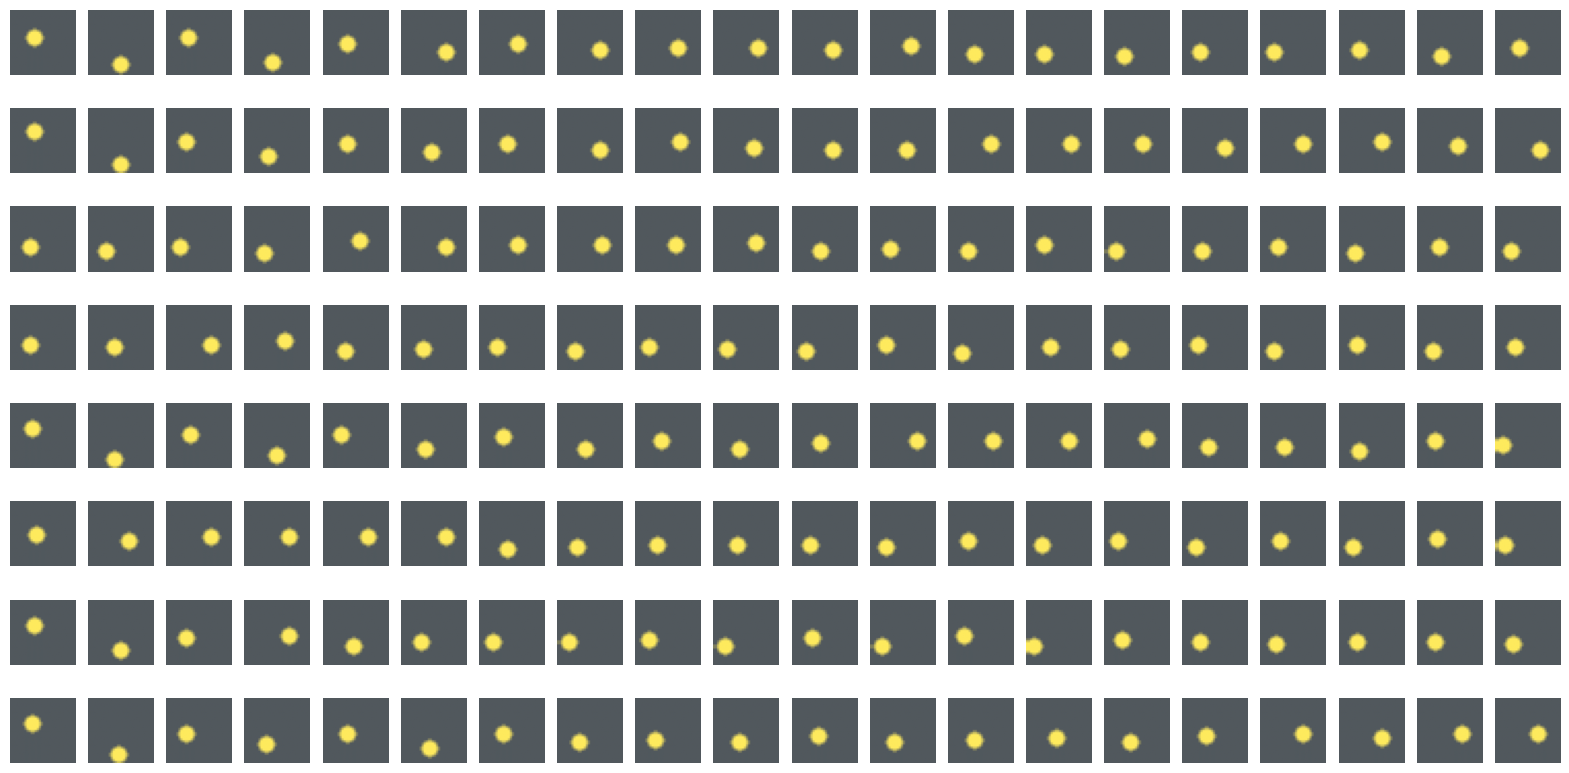

In [20]:
# Visualize a batch of training data
(batch_images,) = next(iter(dataloader))
imshow_grid(batch_images[0:8],n_col=20,fig_size_a=20)  # Displaying the first batch

In [7]:
def plot_models(gamma, gamma2, gamma3, latents_states,N=10):
    # gamma: [B, T, num_states]
    # latents_states: [B, num_states]
    T = gamma.shape[1]
    states = torch.zeros(T, 3)
    states[range(T), latents_states[N, :].long()] = 1    

    # Plotting
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5.5, 3.5), sharex=True)

    # Plotting Model 1
    im1 = axes[0].imshow(states[:T, :].T, vmin=0, vmax=1)

    # Plotting Model 2
    im2 = axes[1].imshow(gamma[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    # Plotting Model 3
    im3 = axes[2].imshow(gamma2[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    # Plotting Model 4
    im4 = axes[3].imshow(gamma3[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    for ax in axes:
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)     # Hide the top spine
        ax.spines['right'].set_visible(False)   # Hide the right spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
        ax.spines['left'].set_visible(False)    # Hide the left spine
        ax.grid(False)
        # Remove tick marks
        ax.tick_params(axis='x', which='both', length=0, width=0)  # Remove x-axis ticks
        ax.tick_params(axis='y', which='both', length=0, width=0)  # Remove y-axis ticks

    # Adding model names to the left of each subplot
    axes[0].text(-0.01, 0.5, 'Ground Truth', va='center', ha='right', transform=axes[0].transAxes, fontsize=10)
    axes[1].text(-0.01, 0.5, 'ELBO', va='center', ha='right', transform=axes[1].transAxes, fontsize=10)
    axes[2].text(-0.01, 0.5, 'IWAE', va='center', ha='right', transform=axes[2].transAxes, fontsize=10)
    axes[3].text(-0.01, 0.5, 'FIVO', va='center', ha='right', transform=axes[3].transAxes, fontsize=10)

    # Adjust layout to remove space between subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)

    # Add a colorbar to the center right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im2, cax=cbar_ax)

    axes[0].set_xlim((0, T))

    # Set the x-axis label on the bottom plot only
    axes[3].set_xlabel('Timestep')
    
    plt.show()

def plot_2_models(gamma, latents_states, title='ELBO',N=10):
    # gamma: [B, T, num_states]
    # latents_states: [B, num_states]
    T = gamma.shape[1]
    states = torch.zeros(T, 3)
    states[range(T), latents_states[N, :].long()] = 1    

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 1.5), sharex=True)

    # Plotting Model 1
    im1 = axes[0].imshow(states[:T, :].T, vmin=0, vmax=1)

    # Plotting Model 2
    im2 = axes[1].imshow(gamma[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    for ax in axes:
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)     # Hide the top spine
        ax.spines['right'].set_visible(False)   # Hide the right spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
        ax.spines['left'].set_visible(False)    # Hide the left spine
        ax.grid(False)
        # Remove tick marks
        ax.tick_params(axis='x', which='both', length=0, width=0)  # Remove x-axis ticks
        ax.tick_params(axis='y', which='both', length=0, width=0)  # Remove y-axis ticks

    # Adding model names to the left of each subplot
    axes[0].text(-0.01, 0.5, 'Ground Truth', va='center', ha='right', transform=axes[0].transAxes, fontsize=10)
    axes[1].text(-0.01, 0.5, title, va='center', ha='right', transform=axes[1].transAxes, fontsize=10)


    # Adjust layout to remove space between subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)

    # Add a colorbar to the center right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im2, cax=cbar_ax)

    axes[0].set_xlim((0, T))

    # Set the x-axis label on the bottom plot only
    axes[1].set_xlabel('Timestep')
    
    plt.show()    

In [ ]:
def best_f1_score(ground_truth, posterior_probs):
    """
    Calculate the best F1 score for the given ground truth and posterior probabilities tensors.

    Parameters:
    - ground_truth: A numpy array of shape [B, T] with integers 0, 1, 2 representing the ground truth states.
    - posterior_probs: A numpy array of shape [B, T, 3] with posterior probabilities for each state.

    Returns:
    - best_f1: The best F1 score after testing all permutations of the states.
    """
    # Find the predicted states by taking the argmax over the last dimension
    predicted_states = np.argmax(posterior_probs, axis=-1)

    # List all possible permutations of (0, 1, 2)
    state_permutations = list(permutations([0, 1, 2]))

    best_f1 = 0.0
    
    # Iterate over all permutations
    for perm in state_permutations:
        # Map predicted states according to the current permutation
        mapped_predictions = np.copy(predicted_states)
        for original_state, new_state in enumerate(perm):
            mapped_predictions[predicted_states == original_state] = new_state
        
        # Calculate F1 score for this permutation
        f1 = f1_score(ground_truth.flatten(), mapped_predictions.flatten(), average='macro')
        
        # Update best F1 score
        if f1 > best_f1:
            best_f1 = f1
    
    return best_f1


def best_cross_entropy_loss(ground_truth, posterior_probs):
    """
    Calculate the best cross-entropy loss for the given ground truth and posterior probabilities tensors.

    Parameters:
    - ground_truth: A numpy array of shape [B, T] with integers 0, 1, 2 representing the ground truth states.
    - posterior_probs: A numpy array of shape [B, T, 3] with posterior probabilities for each state.

    Returns:
    - best_cross_entropy: The lowest cross-entropy loss after testing all permutations of the states.
    """
    ground_truth = ground_truth.astype(int)

    # List all possible permutations of (0, 1, 2)
    state_permutations = list(permutations([0, 1, 2]))

    best_cross_entropy = np.inf
    
    # Iterate over all permutations
    for perm in state_permutations:
        # Map the posterior probabilities according to the current permutation
        mapped_probs = np.zeros_like(posterior_probs)
        for i, new_state in enumerate(perm):
            mapped_probs[..., new_state] = posterior_probs[..., i]
        
        # Calculate cross-entropy loss for this permutation
        # One-hot encode the ground truth
        ground_truth_one_hot = np.eye(3)[ground_truth]
        
        # Clip the mapped probabilities to avoid log(0)
        clipped_probs = np.clip(mapped_probs, 1e-12, 1 - 1e-12)
        
        # Calculate cross-entropy loss
        cross_entropy = -np.sum(ground_truth_one_hot * np.log(clipped_probs)) / ground_truth.size
        
        # Update best cross-entropy loss
        if cross_entropy < best_cross_entropy:
            best_cross_entropy = cross_entropy
    
    return best_cross_entropy


# Create Model

### Helper Functions

In [8]:
def normal_logprob(x,mu,sigma):
    """
    Function that calculates the log probability of a multivariate normal distribution
    with diagonal covariance matrix.
    
    Args:
        x (torch.Tensor): Value at which the log probability is evaluated. Shape: [B,d]
        mu (torch.Tensor): Mean of the multivariate distribution. Shape: [B,d]
        sigma (torch.Tensor): Diagonal values of the covariance matrix of the
                              multivariate distribution. Shape: [B,d]
    """
    dev = x.device
    B,d = mu.shape
    
    if len(sigma.shape) == 0:
        sigma = sigma.repeat(B,d)

    a = torch.tensor(([-(d/2) * torch.log(torch.tensor(2)*torch.pi)]*B), device=dev)
    b = - 0.5 * torch.log(sigma).sum(1)
    c = - 0.5 * (((x - mu)**2/sigma).sum(1))
    return a+b+c

def resample(x,weights,N):
    """
    Modified from https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/system/fivo.py
    Function that resamples N particles based on their weight
    Args: 
        x (torch.Tensor): Shape is [P,B,H]
        weights (torch.Tensor): Log weights. Shape is [P,B]
        N (int): Number of particles to resample
    Returns:
        torch.Tensor: Resampled particles of shape [P,B,H] 
    """
    weights = weights - torch.logsumexp(weights, dim=0) # Normalise log weights
    categorical = Categorical(logits=weights.permute([1,0]))    
    indices = categorical.sample(torch.Size([N])) # shape [P,B]
    x = torch.gather(x, 0, indices.unsqueeze(2).repeat(1,1,x.size(2)))
    return x

### Model Definition

In [9]:
class VariationalSNLDS(nn.Module):
    ## Class could be combined with Abstract class MSM for code efficiency
    ## The model allows different settings where annealing=True implements schedule from
    ## Dong et al. (2020) https://proceedings.mlr.press/v119/dong20e.html;
    ## and inference=='alpha' implements Ansari et al. (2023) loss function
    ## https://arxiv.org/abs/2110.13878
    ## We recommend the setting with annealing=False and inference='alpha' and recurent encoder
    ## which is the best that worked for estimation.
    def __init__(self, obs_dim, latent_dim, hidden_dim, num_states, beta=1, encoder_type='recurent', device='cpu', annealing=False, inference='alpha'):
        super(VariationalSNLDS, self).__init__()
        self.obs_dim = obs_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_states = num_states
        self.device = device
        self.beta = beta
        self.var = torch.tensor(5e-4).to(device)
        self.scaling = 0
        self.temperature = 1
        self.annealing = annealing
        self.inference = inference
        if annealing:
            self.scaling = 1e6
            self.temperature = 1e6
        self.encoder_type = encoder_type
        n_feat = 64
        n_layers = 2
        ## Neural net params
        # Transitions p(z_t|z_t-1,s_t)
        self.transitions = nn.ModuleList([MLP(latent_dim, latent_dim, hidden_dim, 'softplus') for _ in range(self.num_states)]).to(device).float()
        # Encoder q(z|x)
        if self.encoder_type=='factored':
            #self.encoder = nn.Linear(obs_dim, 2*latent_dim).to(device).float()
            self.encoder = MLP(obs_dim, 2*latent_dim, hidden_dim, 'leakyrelu').to(device).float()
        elif self.encoder_type=='video':
            self.img_embedding = CNNFastEncoder(3, hidden_dim, n_feat, n_layers=n_layers).to(device).float()
            self.encoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device).float()
            self.encoder_causal = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=2, batch_first=True, bidirectional=False).to(device).float()
            self.encoder_mean_var = nn.Linear(hidden_dim, 2*latent_dim).to(device).float()
        else:
            self.encoder = nn.LSTM(obs_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device).float()
            self.encoder_causal = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=2, batch_first=True, bidirectional=False).to(device).float()
            self.encoder_mean_var = nn.Linear(hidden_dim, 2*latent_dim).to(device).float()
        # Decoder p(x|z)
        if self.encoder_type=='video':
            self.decoder = CNNFastDecoder(latent_dim, 3, n_feat, n_layers=n_layers).to(device).float()
        else:
            self.decoder = MLP(latent_dim, obs_dim, hidden_dim, 'leakyrelu').to(device).float()
        #self.decoder = nn.Linear(latent_dim, obs_dim).to(device)
        ## MSM params
        # logits of p(s_t|s_t-1)
        self.Q = nn.Parameter(torch.zeros(self.num_states, self.num_states).to(device).float())
        # logits of p(s_1)
        self.pi = nn.Parameter(torch.zeros(num_states).to(device).float())
        #self.pi = torch.zeros(num_states).to(device)
        # Init mean and covariances
        self.init_mean = nn.Parameter(torch.randn(self.num_states, self.latent_dim).to(device).float())
        self.init_cov = nn.Parameter(((torch.rand(self.num_states,1,1)*torch.eye(self.latent_dim)[None,:,:])*5).to(device).float())
        self.covs = nn.Parameter((torch.eye(self.latent_dim)[None,:,:]).repeat(self.num_states,1,1).to(device).float()) # identity covariance
    
    def _encode_obs(self, x):
        if self.encoder_type=='factored':
            (B, T, D) = x.shape
            (z_mu, z_log_var) = self.encoder(x.reshape(B*T,-1)).split(self.latent_dim, dim=-1)
        elif self.encoder_type=='video':
            (B, T, C, W, H) = x.shape
            x = self.img_embedding(x.reshape(B*T,C,W,H)).reshape(B,T,-1)
            output, _ = self.encoder(x)
            # output contains h^x_{1:T}
            output, _ = self.encoder_causal(output)
            (z_mu, z_log_var) = self.encoder_mean_var(output).split(self.latent_dim, dim=-1)
        else:
            output, _ = self.encoder(x)
            # output contains h^x_{1:T}
            output, _ = self.encoder_causal(output)
            (z_mu, z_log_var) = self.encoder_mean_var(output).split(self.latent_dim, dim=-1)
        eps = torch.normal(mean=torch.zeros_like(z_mu)).to(x.device)
        z_std = (z_log_var*0.5).exp()
        sample = z_mu + z_std*eps
        return sample, z_mu, z_log_var

    def _compute_local_evidence(self, z):
        T = z.size(1)
        init_distrib_ = torch.distributions.MultivariateNormal(self.init_mean, torch.matmul(self.init_cov,self.init_cov.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(self.device))
        log_local_evidence_1 = init_distrib_.log_prob(z[:,0:1,None,:].repeat(1,1,self.num_states,1)) # shape [B,1,num_states]
        if T==1:
            return log_local_evidence_1
        means_ = torch.cat([self.transitions[i](z[:,:-1, None,:]) for i in range(self.num_states)], dim=2) # shape [B,T-1,num_states,latent_dim]
        covs = torch.matmul(self.covs,self.covs.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(self.device) # [num_states,latent_dim,2]
        distribs = [torch.distributions.MultivariateNormal(means_[:,:,i,:], covs[i,:,:]) for i in range(self.num_states)]
        log_local_evidence_T = torch.cat([distribs[i].log_prob(z[:,1:,:])[:,:,None] for i in range(self.num_states)], dim=2) # [B,T-1,num_states]
        return torch.cat([log_local_evidence_1, log_local_evidence_T], dim=1) # [B,T,num_states]
    
    def next_evidence(self,z):
        T = z.size(1)
        means_ = torch.cat([self.transitions[i](z[:,:-1, None,:]) for i in range(num_states)], dim=2) # shape [B,T-1,num_states,latent_dim]
        covs = torch.matmul(self.covs,self.covs.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(device) # [num_states,latent_dim,2]
        distribs = [torch.distributions.MultivariateNormal(means_[:,:,i,:], covs[i,:,:]) for i in range(num_states)]  
        log_local_evidence_T = torch.cat([distribs[i].log_prob(z[:,1:,:])[:,:,None] for i in range(num_states)], dim=2) # [B,T-1,num_states]
        return log_local_evidence_T      

    def _alpha(self, local_evidence):
        N, T, _ = local_evidence.shape
        log_Z = torch.zeros((N,T)).to(self.device)
        log_alpha = torch.zeros((N, T, self.num_states)).to(self.device)
        # softmax is just to normalise the probabilities
        # shape: [B,num_states]
        log_prob = local_evidence[:,0,:] + torch.log((self.pi/self.temperature).softmax(-1)) # log p(z_1|s_1) - log p(s_1)
        log_Z[:,0] = torch.logsumexp(log_prob, dim=-1) # log p(z_1), [B]
        log_alpha[:,0,:] = log_prob - log_Z[:,0,None] # log p(s_1|z_1) [B,num_states]
        Q = (self.Q[None,None,:,:].expand(N,T,-1,-1)/self.temperature).softmax(-1).transpose(2,3).log() # [B,T,num_states,num_states]
        for t in range(1, T):
            #log_prob = local_evidence[:,t,:] + torch.log(torch.matmul((Q.transpose(2,3))[:,t,:,:],alpha[:,t-1,:,None]))[:,:,0]
            log_prob = torch.logsumexp(local_evidence[:,t,:, None] + Q[:,t,:,:] + log_alpha[:,t-1,None,:], dim=-1) 
            
            log_Z[:,t] = torch.logsumexp(log_prob, dim=-1)
            log_alpha[:,t,:] = log_prob - log_Z[:,t,None]
        return log_alpha, log_Z # shapes [B,T,num_states], [B,T] // log_Z: p(z_t|z_{1:t-1}) 

    def next_z(self,local_evidence,log_alpha,log_Z):
        """
        Function that updates the log_Z for the next T timesteps.
        Args:
            local_evidence (torch.Tensor): Shape [B,T,num_states]
            log_alpha (torch.Tensor): Shape [B,num_states]
            log_Z (torch.Tensor): Shape [B]
        """
        B, T, _ = local_evidence.shape
        log_Z_new = torch.zeros((B,T+1)).to(device)
        log_alpha_new = torch.zeros((B, T+1, num_states)).to(device)

        log_Z_new[:,0] = log_Z
        log_alpha_new[:,0,:] = log_alpha

        Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1).transpose(2,3).log() # [B,T,num_states,num_states]
        for t in range(1,T+1):
            log_prob = torch.logsumexp(local_evidence[:,t-1,:, None] + Q[:,t-1,:,:] + log_alpha_new[:,t-1,None,:], dim=-1) 
            log_Z_new[:,t] = torch.logsumexp(log_prob, dim=-1)
            log_alpha_new[:,t,:] = log_prob - log_Z_new[:,t,None]

        return log_alpha_new[:,1:], log_Z_new[:,1:]             

    def _beta(self, local_evidence, log_Z):
        N, T, _ = local_evidence.shape
        log_beta = torch.zeros((N, T, self.num_states)).to(self.device)
        Q = (self.Q[None,None,:,:].expand(N,T,-1,-1)/self.temperature).softmax(-1).log()
        for t in reversed(range(1, T)):
            #beta_ = torch.matmul(Q[:,t,:,:], (torch.exp(local_evidence[:,t,:])*beta[:,t,:])[:,:,None])[:,:,0]
            beta_ = torch.logsumexp(Q[:,t,:,:] + local_evidence[:,t,None,:] + log_beta[:,t,None,:], dim=-1)
            log_beta[:,t-1,:] = beta_ - log_Z[:,t,None]
        return log_beta
    
    def _compute_posteriors(self, log_evidence):
        log_alpha, log_Z = self._alpha(log_evidence)
        log_beta = self._beta(log_evidence, log_Z)
        log_gamma = log_alpha + log_beta
        B, T, _ = log_evidence.shape
        #alpha_beta_evidence = torch.matmul(alpha[:,:T-1,:,None], (beta*torch.exp(log_evidence))[:,1:,None,:])
        log_alpha_beta_evidence = log_alpha[:,:T-1,:,None] + log_beta[:,1:,None,:] + log_evidence[:,1:,None,:]
        Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1).log()
        #paired_marginals = Q[:,1:,:,:]*(alpha_beta_evidence/torch.exp(log_Z[:,1:,None,None])).float()
        log_paired_marginals = Q[:,1:,:,:] + log_alpha_beta_evidence - log_Z[:,1:,None,None]
        
        return log_gamma.exp().detach(), log_paired_marginals.exp().detach()

    def _decode(self, z):
        return self.decoder(z)

    def _compute_elbo(self, x, x_hat, z_mu, z_log_var, z_sample, log_Z=None, gamma=None, paired_marginals=None, log_evidence=None):

        (B, T, D) = x.size()
        # max: ELBO = log p(x_t|z_t) - (log q(z) + log q(s) - log p(z_t | s_t) - log p(s_t| s_t-1))
        # min: -ELBO =  - log p(x_t|z_t) + log q(z) + log q(s) - log p(z_t | s_t) - log p(s_t| s_t-1)
        # Fixed variance
        # Reconstruction Loss p(x_t | z_t)
        #decoder_x_1 = MultivariateNormal(x_hat, covariance_matrix=torch.eye(D).to(self.device)*self.var)
        #p_x_1 = (decoder_x_1.log_prob(x)).sum(-1)
        #recon_loss = (p_x_1).sum()/B


        decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
        p_x_2 = (decoder_x_2.log_prob(x)).sum(-1)
        recon_loss = (p_x_2).sum()/(B)
        #print(recon_loss)
        #print(recon_loss_2)
        ## KL terms
        q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
        entropy_q = -(q_z.log_prob(z_sample)).sum()/B
        if self.beta==0:
            msm_loss = 0
            CE_term = 0
        else:
            if self.inference=='alpha':
                msm_loss = log_Z.sum()/B
            else:
                # pi
                msm_loss = (gamma[:,0,:]*torch.log((self.pi/self.temperature).softmax(-1)[None,:])).sum()/B
                # Q
                Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1)
                msm_loss += (paired_marginals*torch.log(Q[:,1:,:,:])).sum()/B
                # p(z_t|z_t-1)
                msm_loss += (gamma[:,:]*log_evidence[:,:]).sum()/B
            CE_term = 0
            if self.annealing:
                CE_term = self.scaling*self.kl_categorical_uniform(gamma)# +  self.scaling*self.kl_categorical_uniform((self.pi).softmax(-1))
        elbo = recon_loss + entropy_q + self.beta*msm_loss
        losses = {
            'kld': entropy_q,
            'elbo': elbo,
            'loss': -elbo + CE_term,
            'recon_loss': recon_loss,
            'msm_loss': msm_loss,
            'CE': CE_term
        }
        return losses
    
    def kl_categorical_uniform(self, gamma, eps=1e-16):
        """Based on https://github.com/ethanfetaya/NRI (MIT License)."""
        prob = (1/self.num_states)
        kl_div = prob * (torch.log(torch.tensor(prob)) - torch.log(gamma + eps))
        return kl_div.sum() / (gamma.size(0))

    def forward(self, x):
        # input is [B, T, D]
        (B, T, *_) = x.shape
        z_sample, z_mu, z_log_var = self._encode_obs(x)
        z_sample = z_sample.reshape(B,T,-1)
        z_mu = z_mu.reshape(B,T,-1)
        z_log_var = z_log_var.reshape(B,T,-1)
        if self.beta==0:
            log_evidence, gamma, paired_marginals, log_Z = None, None, None, None
        else:
            log_evidence = self._compute_local_evidence(z_sample)
            if self.inference=='alpha':
                if self.annealing:
                    log_alpha, log_Z = self._alpha(log_evidence)
                    log_beta = self._beta(log_evidence, log_Z)
                    gamma = (log_alpha + log_beta).exp()
                else:
                    log_Z = self._alpha(log_evidence)[1].sum(-1)
                    gamma = None
                paired_marginals = None
            else:
                with torch.no_grad():
                    gamma, paired_marginals = self._compute_posteriors(log_evidence)
                    log_Z = None
        x_hat = self._decode(z_sample.reshape(B*T,-1)).reshape(B,T,-1)
        # ELBO
        losses = self._compute_elbo(x.reshape(B,T,-1), x_hat, z_mu, z_log_var, z_sample, log_Z, gamma, paired_marginals, log_evidence)
        return x_hat, z_sample, gamma, losses

    def gamma(self, x):
        # input is [B, T, D]
        (B, T, *_) = x.shape
        z_sample, _, _ = self._encode_obs(x)
        z_sample = z_sample.reshape(B,T,-1)  
        log_evidence = self._compute_local_evidence(z_sample)   
        gamma, _ = self._compute_posteriors(log_evidence)
        return gamma # shape [B,T,num_states]

    def iwae(self, x, N):
        # input is [B, T, D]

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))

        # Encode
        z_sample, z_mu, z_log_var = self._encode_obs(inputs) # shape [B*N,latent_dim]

        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            q_z = MultivariateNormal(z_mu[:,t], torch.diag_embed(torch.exp(z_log_var[:,t])))
            log_q_t = q_z.log_prob(z_sample[:,t])

            z[t] = z[t] + z_sample[:,t]

            # Calculate the products
            current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
            local_evidence = self._compute_local_evidence(current_z)
            _, log_Z = self._alpha(local_evidence)
            prod_1_t = log_Z[:,t]

            # Decode
            x_hat = self._decode(z_sample[:,t]).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp((log_p_x+prod_1-log_q).sum(axis=0), dim=0).mean() - math.log(N)
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW  

    def iwae_efficient(self,x,N):
        # input is [B, T, D]

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,P,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            

        z_sample, z_mu, z_log_var = self._encode_obs(inputs)
        local_evidence = self._compute_local_evidence(z_sample)
        _, log_Z = self._alpha(local_evidence) # shape [B*N,T]

        q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
        log_q = q_z.log_prob(z_sample)       

        x_hat = self._decode(z_sample.reshape(B*T*N,-1)).reshape(B*N,T,-1)

        decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
        log_p_x = (decoder_x_2.log_prob(inputs.reshape(B*N,T,-1))).sum(-1) # shape is [B*N,T]

        log_p_x = log_p_x.reshape((T,N,B))
        log_q = log_q.reshape((T,N,B))
        log_Z = log_Z.reshape((B,N,T)).transpose(0,2)

        logW = torch.logsumexp((log_p_x+log_Z-log_q).sum(axis=0), dim=0).mean() - math.log(N)
        return -logW, (log_p_x,log_Z,log_q) # Note the minus in front of logW  

    def fivo(self, x, N):
        # input is [B, T, D]
        # the log incremental weights are:
        # log p(x_t|z_t) + p(z_t|z_{1:t-1}) - log q(z_t|x_t)

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            # Encode
            z_sample, z_mu, z_log_var = self._encode_obs(inputs[:,t].unsqueeze(1)) # shape [B*N,latent_dim]

            z_sample = z_sample.reshape(B*N,-1)
            z_mu = z_mu.reshape(B*N,-1)
            z_log_var = z_log_var.reshape(B*N,-1)

            q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
            log_q_t = q_z.log_prob(z_sample)

            z[t] = z[t] + z_sample

            # Calculate the products 

            current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
            local_evidence = self._compute_local_evidence(current_z)
            _, log_Z = self._alpha(local_evidence)
            prod_1_t = log_Z[:,t]

            # Decode
            x_hat = self._decode(z_sample).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            # Resampling step
            log_W_t = log_p_x_t + prod_1_t - log_q_t - math.log(N)

            z_sample = z_sample.reshape((N,B,-1))
            z_sample = resample(z_sample,log_W_t,N)
            z_sample = z_sample.reshape((N*B,-1))

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp(log_p_x+prod_1-log_q-math.log(N), dim=1).sum(axis=0).mean()
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW                

    def fivo_efficient(self, x, N):
        # input is [B, T, D]
        # the log incremental weights are:
        # log p(x_t|z_t) + p(z_t|z_{1:t-1}) - log q(z_t|x_t)

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        # Encode
        z_sample, z_mu, z_log_var = self._encode_obs(inputs) 
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            q_z = MultivariateNormal(z_mu[:,t], torch.diag_embed(torch.exp(z_log_var[:,t])))
            log_q_t = q_z.log_prob(z_sample[:,t])

            z[t] = z[t] + z_sample[:,t]

            # Calculate the products
            if t < 2:
                current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
                local_evidence = self._compute_local_evidence(current_z)
                log_alpha, log_Z = self._alpha(local_evidence)
            else:    
                current_z = torch.stack(z[(t-2):(t+1)],dim=1)
                local_evidence = self.next_evidence(current_z)
                log_alpha, log_Z = self.next_z(local_evidence,log_alpha[:,-2],log_Z[:,-2]) 
            prod_1_t = log_Z[:,-1]   

            # Decode
            x_hat = self._decode(z_sample[:,t]).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            # Resampling step
            log_W_t = log_p_x_t + prod_1_t - log_q_t - math.log(N)

            new_z = z_sample[:,t]
            new_z = new_z.reshape((N,B,-1))
            new_z = resample(new_z,log_W_t,N)
            new_z = new_z.reshape((N*B,-1))

            z[t] = z[t] - z_sample[:,t] + new_z

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp(log_p_x+prod_1-log_q-math.log(N), dim=1).sum(axis=0).mean()
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW 

    def predict_sequence(self, input, seq_len=None):
        (B, T, *_) = input.size()
        if seq_len is None:
            seq_len = T
        z_sample, _, _ = self._encode_obs(input)
        z_sample = z_sample.reshape(B,T,-1)
        log_evidence = self._compute_local_evidence(z_sample)
        gamma, _ = self._compute_posteriors(log_evidence)
        #last_discrete = Categorical(gamma[:,-1,:]).sample()
        last_discrete = gamma[:,-1,:].argmax(-1)
        last_continous = z_sample[:,-1,:]
        latent_seq = torch.zeros(B,seq_len,self.latent_dim).to(input.device)
        Q = self.Q
        for t in range(seq_len):
            # next discrete state
            last_discrete_distrib = torch.cat([Q[last_discrete[b].long(),:][None,:] for b in range(B)], dim=0)
            last_discrete = Categorical(logits=last_discrete_distrib).sample()
            # next observation mean
            last_continous = torch.cat([self.transitions[last_discrete[b]](last_continous[b,None,:]) for b in range(B)], dim=0)
            latent_seq[:,t,:] = last_continous
        # decode
        return self._decode(latent_seq.reshape(B*seq_len,-1)).reshape(B,seq_len,-1)
    
    def sample(self, n_samples, seq_len):
        latent_seq = torch.zeros(n_samples,seq_len,self.latent_dim).to(device)

        # Initial discrete state
        last_discrete_distrib = torch.cat([self.pi[None,:] for _ in range(n_samples)], dim=0)
        last_discrete = Categorical(logits=last_discrete_distrib).sample()

        # Initial continuous state
        last_continous = torch.stack([self.init_mean[last_discrete[b]] for b in range(n_samples)], dim=0)
        latent_seq[:,0,:] = last_continous

        for t in range(1, seq_len):
            # next discrete state
            last_discrete_distrib = torch.cat([self.Q[last_discrete[b].long(),:][None,:] for b in range(n_samples)], dim=0)
            last_discrete = Categorical(logits=last_discrete_distrib).sample()
            # next observation mean
            last_continous = torch.cat([self.transitions[last_discrete[b]](last_continous[b,None,:]) for b in range(n_samples)], dim=0)
            latent_seq[:,t,:] = last_continous
        # decode
        return self._decode(latent_seq.reshape(n_samples*seq_len,-1)).reshape(n_samples,seq_len,-1)                    

# Train Functions

### VI

In [11]:
def train(model, optimizer, num_states, dim_latent, T):
    # Save in memory for plots
    elbo_losses = []
    test_mse_losses = [] 
    predict_mse_losses = []  

    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
    model.temperature = init_temperature

    #############################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    #############################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            obs_var = obs_var + 0.5
            optimizer.zero_grad()
            x_hat, _, _, losses = model(obs_var)
            # Compute loss and optimize params
            losses['loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            if images:
                mse = torch.nn.functional.mse_loss(x_hat.reshape(B, T, C, H, W), obs_var, reduction='sum')/(B)
            else:
                mse = torch.nn.functional.mse_loss(x_hat, obs_var, reduction='sum')/(B)
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            elbo_losses.append(losses['loss'].item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%50==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'ELBO {loss:.4f}\t MSE: {mse:.4f}\t MSM: {msm:.4e}'.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=losses['elbo'], mse=mse, msm=losses['msm_loss']))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)
            
            with torch.inference_mode():
                s = model.sample(2,20)
                s = s.cpu().reshape(2,20,3,32,32)
                s = torch.clamp(s - 0.5,max=0.5).numpy()
            imshow_grid(s, n_row=2, n_col=20, fig_size_a=20, fig_size_b=2)             

        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:
                    B, T, C, H, W = sample.size()                    
                    obs_var = sample.float().to(device)
                    obs_var = obs_var + 0.5
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=17)
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
                    preds = preds.cpu().reshape(B, 17, C, H, W).numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")                                 
        scheduler.step()
    return elbo_losses, test_mse_losses, predict_mse_losses

### IWAE

In [12]:
def train_iwae(N, model, optimizer, num_states, dim_latent, T):
    latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/states_test_N_500_T_20_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
    latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
    latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
    latents_states = next(iter(latent_loader))[0]

    # Save in memory for plots
    iwae_losses = []
    test_mse_losses = []  
    predict_mse_losses = []  
    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()

    model.temperature = init_temperature
    #############################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    ############################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            obs_var = obs_var + 0.5
            optimizer.zero_grad()
            iwae_loss, incr_weight_terms = model.iwae_efficient(obs_var,N)
            # Compute loss and optimize params
            iwae_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            iwae_losses.append(iwae_loss.item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%50==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'Loss {loss:.4f}\t '.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=iwae_loss))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)
            
            with torch.inference_mode():
                s = model.sample(5,20)
                s = s.cpu().reshape(5,20,3,32,32)
                s = torch.clamp(s - 0.5,max=0.5).numpy()
                imshow_grid(s, n_row=5, n_col=20, fig_size_a=20, fig_size_b=5)
                obs = next(iter(test_dataloader))[0]
                obs = obs.float().to(device)
                obs = obs + 0.5
                gamma = model.gamma(obs)
                plot_2_models(gamma, latents_states, title='IWAE')  
            
        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:
                    B, T, C, H, W = sample.size()                    
                    obs_var = sample.float().to(device)
                    obs_var = obs_var + 0.5
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=17)
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
                    preds = preds.cpu().reshape(B, 17, C, H, W).numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")                                 
        scheduler.step()
    return iwae_losses, test_mse_losses, predict_mse_losses

### FIVO

In [13]:
def train_fivo(N, model, optimizer, num_states, dim_latent, T):
    latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/states_test_N_500_T_20_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
    latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
    latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
    latents_states = next(iter(latent_loader))[0]    
    # Save in memory for plots
    fivo_losses = []
    test_mse_losses = []
    predict_mse_losses = []

    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()

    model.temperature = init_temperature
    ###########################################################################################
    # obs = np.load(path)
    # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    ###########################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            obs_var = obs_var + 0.5
            optimizer.zero_grad()
            fivo_loss, incr_weight_terms = model.fivo_efficient(obs_var,N)
            # Compute loss and optimize params
            fivo_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            fivo_losses.append(fivo_loss.item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%50==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'Loss {loss:.4f}\t '.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=fivo_loss))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)
            
            with torch.inference_mode():
                s = model.sample(2,20)
                s = s.cpu().reshape(2,20,3,32,32)
                s = torch.clamp(s - 0.5,max=0.5).numpy()
                imshow_grid(s, n_row=2, n_col=20, fig_size_a=20, fig_size_b=2)
                obs = next(iter(test_dataloader))[0]
                obs = obs.float().to(device)
                obs = obs + 0.5
                gamma = model.gamma(obs)
                plot_2_models(gamma, latents_states, title='FIVO') 
            
        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:
                    B, T, C, H, W = sample.size()                    
                    obs_var = sample.float().to(device)
                    obs_var = obs_var + 0.5
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=17)
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
                    preds = preds.cpu().reshape(B, 17, C, H, W).numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")                                 
        scheduler.step()
    return fivo_losses, test_mse_losses, predict_mse_losses

# VI

In [14]:
epoch_num = 100
T = 20
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][50/313]	Time 0.082	ELBO -458852.0625	 MSE: 635.9520	 MSM: 0.0000e+00
Epoch: [0][100/313]	Time 0.085	ELBO -306603.7812	 MSE: 483.7015	 MSM: 0.0000e+00
Epoch: [0][150/313]	Time 0.083	ELBO -304807.0000	 MSE: 481.9052	 MSM: 0.0000e+00
Epoch: [0][200/313]	Time 0.083	ELBO -162205.1875	 MSE: 339.2676	 MSM: 0.0000e+00
Epoch: [0][250/313]	Time 0.083	ELBO -66761.4922	 MSE: 243.8048	 MSM: 0.0000e+00
Epoch: [0][300/313]	Time 0.084	ELBO -20617.0000	 MSE: 197.6263	 MSM: 0.0000e+00
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
9.268593749999999


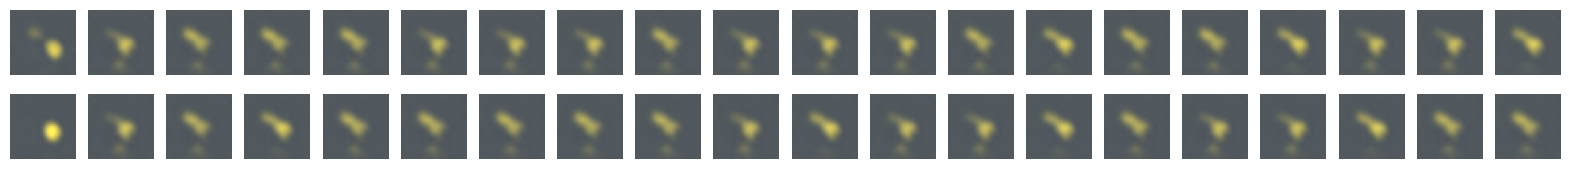

MSE: 0.00251
Pred MSE: 0.01217
Epoch: [1][50/313]	Time 0.085	ELBO 49597.6836	 MSE: 127.3829	 MSM: 0.0000e+00
Epoch: [1][100/313]	Time 0.085	ELBO 54975.0977	 MSE: 121.9905	 MSM: 0.0000e+00
Epoch: [1][150/313]	Time 0.093	ELBO 56080.4141	 MSE: 120.8755	 MSM: 0.0000e+00
Epoch: [1][200/313]	Time 0.084	ELBO 67167.3516	 MSE: 109.7829	 MSM: 0.0000e+00
Epoch: [1][250/313]	Time 0.085	ELBO 81385.0391	 MSE: 95.5579	 MSM: 0.0000e+00
Epoch: [1][300/313]	Time 0.085	ELBO 101371.2422	 MSE: 75.5680	 MSM: 0.0000e+00
MSE: 0.00129
Pred MSE: 0.02241
Epoch: [2][50/313]	Time 0.085	ELBO 104679.5234	 MSE: 72.2500	 MSM: 0.0000e+00
Epoch: [2][100/313]	Time 0.084	ELBO 110176.9219	 MSE: 66.7533	 MSM: 0.0000e+00
Epoch: [2][150/313]	Time 0.085	ELBO 133798.0469	 MSE: 43.1248	 MSM: 0.0000e+00
Epoch: [2][200/313]	Time 0.085	ELBO 123733.9531	 MSE: 53.1827	 MSM: 0.0000e+00
Epoch: [2][250/313]	Time 0.082	ELBO 151793.0312	 MSE: 25.1159	 MSM: 0.0000e+00
Epoch: [2][300/313]	Time 0.083	ELBO 157126.9531	 MSE: 19.7782	 MSM: 0.00

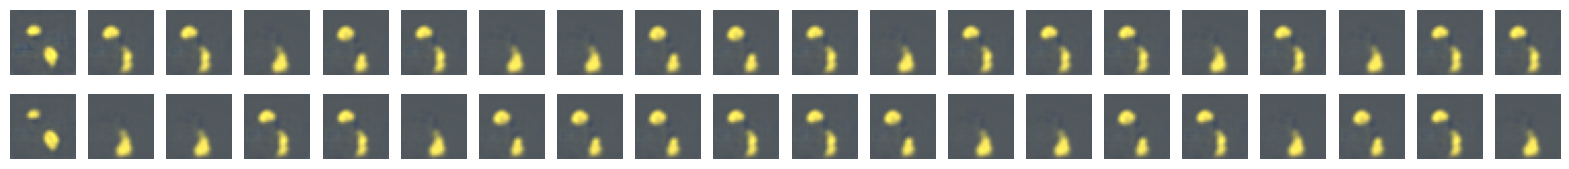

MSE: 0.00035
Pred MSE: 0.02193
Epoch: [3][50/313]	Time 0.085	ELBO 155701.1719	 MSE: 21.1974	 MSM: 0.0000e+00
Epoch: [3][100/313]	Time 0.084	ELBO 155349.6562	 MSE: 21.5487	 MSM: 0.0000e+00
Epoch: [3][150/313]	Time 0.084	ELBO 155894.9844	 MSE: 20.9952	 MSM: 0.0000e+00
Epoch: [3][200/313]	Time 0.085	ELBO 156810.8438	 MSE: 20.0780	 MSM: 0.0000e+00
Epoch: [3][250/313]	Time 0.086	ELBO 160195.8438	 MSE: 16.6890	 MSM: 0.0000e+00
Epoch: [3][300/313]	Time 0.085	ELBO 161010.9375	 MSE: 15.8766	 MSM: 0.0000e+00
MSE: 0.00020
Pred MSE: 0.02025
Epoch: [4][50/313]	Time 0.083	ELBO 163688.1562	 MSE: 13.1931	 MSM: 0.0000e+00
Epoch: [4][100/313]	Time 0.083	ELBO 165244.0625	 MSE: 11.6326	 MSM: 0.0000e+00
Epoch: [4][150/313]	Time 0.085	ELBO 164023.5781	 MSE: 12.8509	 MSM: 0.0000e+00
Epoch: [4][200/313]	Time 0.087	ELBO 158791.0312	 MSE: 18.0833	 MSM: 0.0000e+00
Epoch: [4][250/313]	Time 0.085	ELBO 165285.7188	 MSE: 11.5885	 MSM: 0.0000e+00
Epoch: [4][300/313]	Time 0.085	ELBO 167658.0312	 MSE: 9.2169	 MSM: 0.00

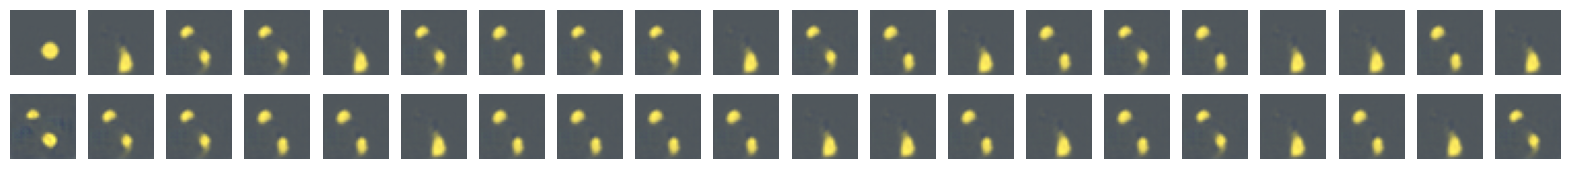

MSE: 0.00022
Pred MSE: 0.01933
Epoch: [5][50/313]	Time 0.086	ELBO 168835.8906	 MSE: 8.0349	 MSM: 0.0000e+00
Epoch: [5][100/313]	Time 0.083	ELBO 165501.3125	 MSE: 11.3636	 MSM: 0.0000e+00
Epoch: [5][150/313]	Time 0.083	ELBO 170677.4688	 MSE: 6.1883	 MSM: 0.0000e+00
Epoch: [5][200/313]	Time 0.083	ELBO 170081.2969	 MSE: 6.7831	 MSM: 0.0000e+00
Epoch: [5][250/313]	Time 0.085	ELBO 167257.6562	 MSE: 9.6045	 MSM: 0.0000e+00
Epoch: [5][300/313]	Time 0.085	ELBO 169873.6406	 MSE: 6.9906	 MSM: 0.0000e+00
MSE: 0.00012
Pred MSE: 0.02023
Epoch: [6][50/313]	Time 0.083	ELBO 168107.3125	 MSE: 8.7506	 MSM: 0.0000e+00
Epoch: [6][100/313]	Time 0.087	ELBO 168240.3281	 MSE: 8.6160	 MSM: 0.0000e+00
Epoch: [6][150/313]	Time 0.084	ELBO 170446.2656	 MSE: 6.4162	 MSM: 0.0000e+00
Epoch: [6][200/313]	Time 0.084	ELBO 171049.1719	 MSE: 5.8043	 MSM: 0.0000e+00
Epoch: [6][250/313]	Time 0.085	ELBO 170096.6250	 MSE: 6.7598	 MSM: 0.0000e+00
Epoch: [6][300/313]	Time 0.085	ELBO 170430.8906	 MSE: 6.4258	 MSM: 0.0000e+00
ten

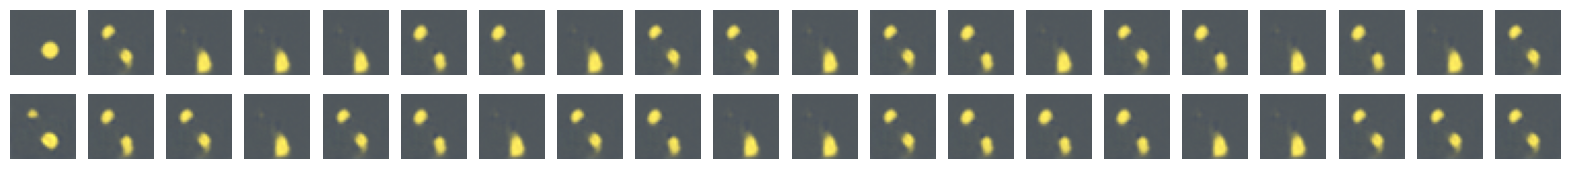

MSE: 0.00014
Pred MSE: 0.02049
Epoch: [7][50/313]	Time 0.086	ELBO 171007.5156	 MSE: 5.8474	 MSM: 0.0000e+00
Epoch: [7][100/313]	Time 0.085	ELBO 169773.3750	 MSE: 7.0767	 MSM: 0.0000e+00
Epoch: [7][150/313]	Time 0.092	ELBO 165667.0781	 MSE: 11.1806	 MSM: 0.0000e+00
Epoch: [7][200/313]	Time 0.086	ELBO 169912.9375	 MSE: 6.9392	 MSM: 0.0000e+00
Epoch: [7][250/313]	Time 0.086	ELBO 170258.3281	 MSE: 6.5918	 MSM: 0.0000e+00
Epoch: [7][300/313]	Time 0.086	ELBO 173139.8906	 MSE: 3.7115	 MSM: 0.0000e+00
MSE: 0.00010
Pred MSE: 0.02033
Epoch: [8][50/313]	Time 0.087	ELBO 166321.9531	 MSE: 10.5267	 MSM: 0.0000e+00
Epoch: [8][100/313]	Time 0.084	ELBO 169933.7188	 MSE: 6.9140	 MSM: 0.0000e+00
Epoch: [8][150/313]	Time 0.087	ELBO 171234.6094	 MSE: 5.6118	 MSM: 0.0000e+00
Epoch: [8][200/313]	Time 0.086	ELBO 168934.4688	 MSE: 7.9134	 MSM: 0.0000e+00
Epoch: [8][250/313]	Time 0.088	ELBO 167605.6875	 MSE: 9.2395	 MSM: 0.0000e+00
Epoch: [8][300/313]	Time 0.086	ELBO 167985.3906	 MSE: 8.8572	 MSM: 0.0000e+00
te

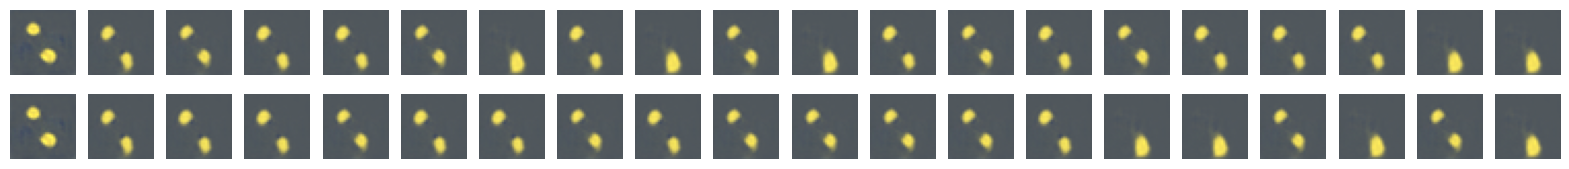

MSE: 0.00009
Pred MSE: 0.01985
Epoch: [9][50/313]	Time 0.087	ELBO 172201.4062	 MSE: 4.6436	 MSM: 0.0000e+00
Epoch: [9][100/313]	Time 0.087	ELBO 169490.2656	 MSE: 7.3563	 MSM: 0.0000e+00
Epoch: [9][150/313]	Time 0.087	ELBO 171550.3594	 MSE: 5.2917	 MSM: 0.0000e+00
Epoch: [9][200/313]	Time 0.087	ELBO 172381.3906	 MSE: 4.4609	 MSM: 0.0000e+00
Epoch: [9][250/313]	Time 0.088	ELBO 172687.0781	 MSE: 4.1570	 MSM: 0.0000e+00
Epoch: [9][300/313]	Time 0.087	ELBO 171993.4531	 MSE: 4.8509	 MSM: 0.0000e+00
MSE: 0.00008
Pred MSE: 0.01807
Epoch: [10][50/313]	Time 0.111	ELBO 172705.2500	 MSE: 4.0485	 MSM: -9.0044e+01
Epoch: [10][100/313]	Time 0.110	ELBO 169805.4844	 MSE: 6.9581	 MSM: -8.0578e+01
Epoch: [10][150/313]	Time 0.102	ELBO 172248.9062	 MSE: 4.5093	 MSM: -8.4923e+01
Epoch: [10][200/313]	Time 0.108	ELBO 168159.1719	 MSE: 8.6003	 MSM: -7.8843e+01
Epoch: [10][250/313]	Time 0.112	ELBO 171637.3438	 MSE: 5.1181	 MSM: -8.6527e+01
Epoch: [10][300/313]	Time 0.111	ELBO 168070.7812	 MSE: 8.6982	 MSM: -7.4

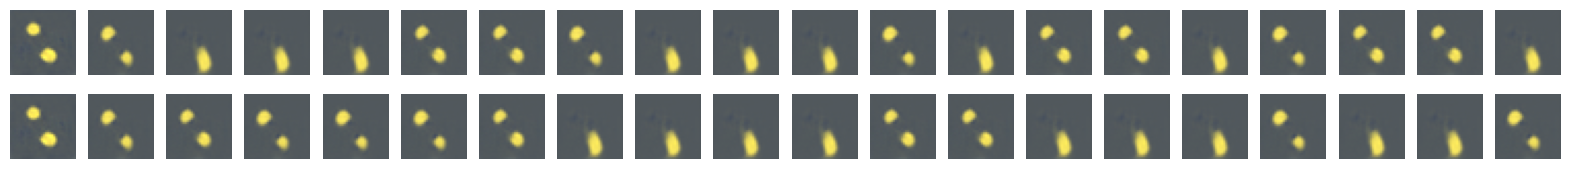

MSE: 0.00010
Pred MSE: 0.01927
Epoch: [11][50/313]	Time 0.100	ELBO 173575.4844	 MSE: 3.1907	 MSM: -7.2996e+01
Epoch: [11][100/313]	Time 0.098	ELBO 171970.3438	 MSE: 4.7982	 MSM: -7.3850e+01
Epoch: [11][150/313]	Time 0.109	ELBO 173339.0938	 MSE: 3.4209	 MSM: -8.0845e+01
Epoch: [11][200/313]	Time 0.101	ELBO 173539.1875	 MSE: 3.2312	 MSM: -7.2479e+01
Epoch: [11][250/313]	Time 0.102	ELBO 173182.2344	 MSE: 3.5863	 MSM: -7.3919e+01
Epoch: [11][300/313]	Time 0.106	ELBO 171094.7969	 MSE: 5.6719	 MSM: -7.2419e+01
MSE: 0.00019
Pred MSE: 0.01930
Epoch: [12][50/313]	Time 0.104	ELBO 169660.7344	 MSE: 7.1093	 MSM: -7.4371e+01
Epoch: [12][100/313]	Time 0.101	ELBO 170769.7344	 MSE: 6.0042	 MSM: -6.9926e+01
Epoch: [12][150/313]	Time 0.106	ELBO 171888.7656	 MSE: 4.8812	 MSM: -6.9361e+01
Epoch: [12][200/313]	Time 0.110	ELBO 173680.0469	 MSE: 3.0897	 MSM: -7.0215e+01
Epoch: [12][250/313]	Time 0.109	ELBO 171410.2344	 MSE: 5.3596	 MSM: -7.0102e+01
Epoch: [12][300/313]	Time 0.110	ELBO 169422.1250	 MSE: 7.346

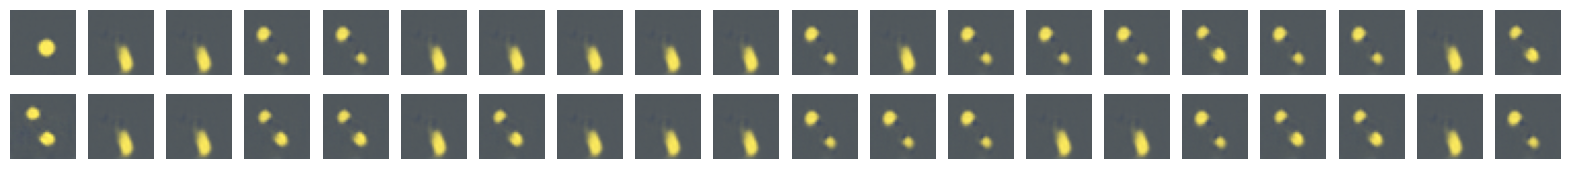

MSE: 0.00011
Pred MSE: 0.01837
Epoch: [13][50/313]	Time 0.111	ELBO 173388.7656	 MSE: 3.3849	 MSM: -6.9068e+01
Epoch: [13][100/313]	Time 0.103	ELBO 172611.3438	 MSE: 4.1623	 MSM: -6.9281e+01
Epoch: [13][150/313]	Time 0.111	ELBO 171357.4531	 MSE: 5.4180	 MSM: -6.7352e+01
Epoch: [13][200/313]	Time 0.106	ELBO 174213.4531	 MSE: 2.5670	 MSM: -6.4071e+01
Epoch: [13][250/313]	Time 0.107	ELBO 172080.9219	 MSE: 4.6947	 MSM: -6.6570e+01
Epoch: [13][300/313]	Time 0.105	ELBO 173869.7188	 MSE: 2.9073	 MSM: -6.5994e+01
MSE: 0.00008
Pred MSE: 0.01899
Epoch: [14][50/313]	Time 0.110	ELBO 172867.9844	 MSE: 3.9114	 MSM: -6.4614e+01
Epoch: [14][100/313]	Time 0.102	ELBO 171000.4844	 MSE: 5.7746	 MSM: -6.6659e+01
Epoch: [14][150/313]	Time 0.111	ELBO 172437.9531	 MSE: 4.3428	 MSM: -6.2942e+01
Epoch: [14][200/313]	Time 0.104	ELBO 172557.3906	 MSE: 4.2172	 MSM: -6.4549e+01
Epoch: [14][250/313]	Time 0.103	ELBO 174308.9844	 MSE: 2.4750	 MSM: -6.2181e+01
Epoch: [14][300/313]	Time 0.104	ELBO 171014.0312	 MSE: 5.767

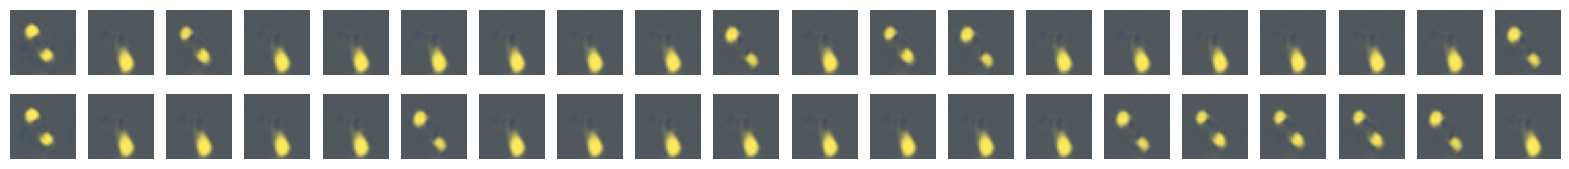

MSE: 0.00009
Pred MSE: 0.01957
Epoch: [15][50/313]	Time 0.110	ELBO 172251.5312	 MSE: 4.5299	 MSM: -6.3093e+01
Epoch: [15][100/313]	Time 0.109	ELBO 171083.6406	 MSE: 5.6959	 MSM: -6.3505e+01
Epoch: [15][150/313]	Time 0.098	ELBO 172083.3750	 MSE: 4.6990	 MSM: -6.3635e+01
Epoch: [15][200/313]	Time 0.103	ELBO 173416.5000	 MSE: 3.3640	 MSM: -6.2561e+01
Epoch: [15][250/313]	Time 0.098	ELBO 173242.5312	 MSE: 3.5464	 MSM: -5.9988e+01
Epoch: [15][300/313]	Time 0.110	ELBO 173537.3281	 MSE: 3.2443	 MSM: -6.2217e+01
MSE: 0.00005
Pred MSE: 0.02022
Epoch: [16][50/313]	Time 0.138	ELBO 174288.5938	 MSE: 2.4974	 MSM: -6.0041e+01
Epoch: [16][100/313]	Time 0.105	ELBO 172484.7500	 MSE: 4.2964	 MSM: -6.3848e+01
Epoch: [16][150/313]	Time 0.105	ELBO 172612.5156	 MSE: 4.1745	 MSM: -6.1291e+01
Epoch: [16][200/313]	Time 0.107	ELBO 172781.5312	 MSE: 4.0046	 MSM: -6.0599e+01
Epoch: [16][250/313]	Time 0.108	ELBO 173807.7344	 MSE: 2.9802	 MSM: -6.1160e+01
Epoch: [16][300/313]	Time 0.107	ELBO 171888.3594	 MSE: 4.892

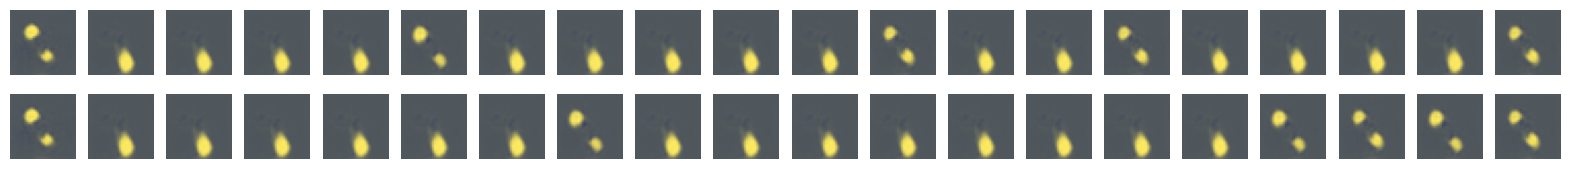

MSE: 0.00006
Pred MSE: 0.01998
Epoch: [17][50/313]	Time 0.098	ELBO 173971.1719	 MSE: 2.8099	 MSM: -6.2546e+01
Epoch: [17][100/313]	Time 0.103	ELBO 173210.8750	 MSE: 3.5773	 MSM: -6.1202e+01
Epoch: [17][150/313]	Time 0.102	ELBO 173449.7656	 MSE: 3.3331	 MSM: -6.2547e+01
Epoch: [17][200/313]	Time 0.099	ELBO 172303.1406	 MSE: 4.4832	 MSM: -6.2244e+01
Epoch: [17][250/313]	Time 0.100	ELBO 168058.6406	 MSE: 8.7240	 MSM: -6.1657e+01
Epoch: [17][300/313]	Time 0.105	ELBO 171495.4531	 MSE: 5.2931	 MSM: -6.1383e+01
MSE: 0.00006
Pred MSE: 0.01922
Epoch: [18][50/313]	Time 0.099	ELBO 173365.7344	 MSE: 3.4198	 MSM: -6.4323e+01
Epoch: [18][100/313]	Time 0.103	ELBO 173065.1875	 MSE: 3.7243	 MSM: -6.1782e+01
Epoch: [18][150/313]	Time 0.106	ELBO 172384.2656	 MSE: 4.3989	 MSM: -6.4195e+01
Epoch: [18][200/313]	Time 0.111	ELBO 173094.2188	 MSE: 3.6890	 MSM: -6.2711e+01
Epoch: [18][250/313]	Time 0.112	ELBO 169238.9844	 MSE: 7.5504	 MSM: -6.1989e+01
Epoch: [18][300/313]	Time 0.109	ELBO 171772.1719	 MSE: 5.014

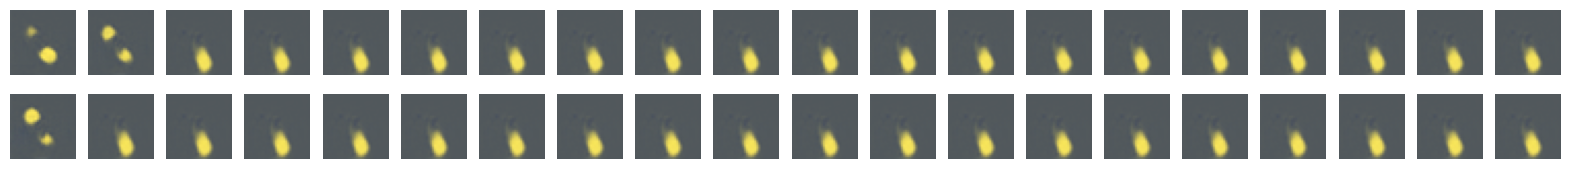

MSE: 0.00006
Pred MSE: 0.01900
Epoch: [19][50/313]	Time 0.110	ELBO 171781.1094	 MSE: 5.0057	 MSM: -6.2714e+01
Epoch: [19][100/313]	Time 0.111	ELBO 173738.2812	 MSE: 3.0581	 MSM: -5.8774e+01
Epoch: [19][150/313]	Time 0.100	ELBO 174877.9531	 MSE: 1.9102	 MSM: -6.2971e+01
Epoch: [19][200/313]	Time 0.111	ELBO 173922.9844	 MSE: 2.8683	 MSM: -6.2232e+01
Epoch: [19][250/313]	Time 0.115	ELBO 174926.4375	 MSE: 1.8665	 MSM: -6.0203e+01
Epoch: [19][300/313]	Time 0.107	ELBO 174063.4219	 MSE: 2.7274	 MSM: -6.1869e+01
MSE: 0.00004
Pred MSE: 0.01968
Epoch: [20][50/313]	Time 0.101	ELBO 174017.4219	 MSE: 2.7774	 MSM: -6.0412e+01
Epoch: [20][100/313]	Time 0.106	ELBO 174629.7500	 MSE: 2.1659	 MSM: -5.9013e+01
Epoch: [20][150/313]	Time 0.110	ELBO 173588.6250	 MSE: 3.2049	 MSM: -6.2524e+01
Epoch: [20][200/313]	Time 0.110	ELBO 174551.0938	 MSE: 2.2381	 MSM: -6.3990e+01
Epoch: [20][250/313]	Time 0.107	ELBO 172989.1562	 MSE: 3.8042	 MSM: -6.0073e+01
Epoch: [20][300/313]	Time 0.105	ELBO 172773.5156	 MSE: 4.022

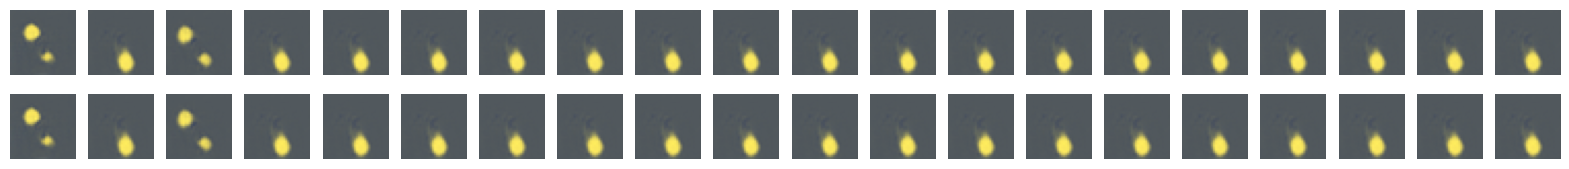

MSE: 0.00009
Pred MSE: 0.01990
Epoch: [21][50/313]	Time 0.100	ELBO 172641.9688	 MSE: 4.1487	 MSM: -6.2806e+01
Epoch: [21][100/313]	Time 0.106	ELBO 172092.9688	 MSE: 4.6992	 MSM: -6.2647e+01
Epoch: [21][150/313]	Time 0.099	ELBO 172825.9219	 MSE: 3.9643	 MSM: -6.1266e+01
Epoch: [21][200/313]	Time 0.111	ELBO 174312.5312	 MSE: 2.4771	 MSM: -6.3548e+01
Epoch: [21][250/313]	Time 0.099	ELBO 173671.3125	 MSE: 3.1220	 MSM: -6.2055e+01
Epoch: [21][300/313]	Time 0.097	ELBO 174134.8281	 MSE: 2.6622	 MSM: -6.1097e+01
MSE: 0.00004
Pred MSE: 0.02006
Epoch: [22][50/313]	Time 0.118	ELBO 174765.7031	 MSE: 2.0285	 MSM: -6.2535e+01
Epoch: [22][100/313]	Time 0.104	ELBO 174537.5469	 MSE: 2.2605	 MSM: -5.9710e+01
Epoch: [22][150/313]	Time 0.116	ELBO 173902.8438	 MSE: 2.8972	 MSM: -5.9080e+01
Epoch: [22][200/313]	Time 0.105	ELBO 174562.7969	 MSE: 2.2378	 MSM: -6.1478e+01
Epoch: [22][250/313]	Time 0.105	ELBO 174249.6250	 MSE: 2.5486	 MSM: -5.9661e+01
Epoch: [22][300/313]	Time 0.101	ELBO 173599.1875	 MSE: 3.200

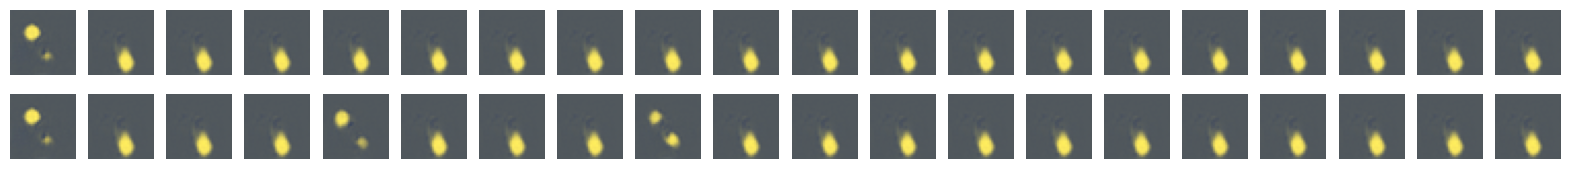

MSE: 0.00005
Pred MSE: 0.01948
Epoch: [23][50/313]	Time 0.100	ELBO 175138.1719	 MSE: 1.6594	 MSM: -6.1935e+01
Epoch: [23][100/313]	Time 0.100	ELBO 174813.2656	 MSE: 1.9855	 MSM: -6.1340e+01
Epoch: [23][150/313]	Time 0.108	ELBO 173528.2812	 MSE: 3.2677	 MSM: -6.3330e+01
Epoch: [23][200/313]	Time 0.109	ELBO 174320.8594	 MSE: 2.4799	 MSM: -6.1738e+01
Epoch: [23][250/313]	Time 0.109	ELBO 175153.8125	 MSE: 1.6444	 MSM: -6.2264e+01
Epoch: [23][300/313]	Time 0.110	ELBO 172520.3594	 MSE: 4.2780	 MSM: -6.1053e+01
MSE: 0.00003
Pred MSE: 0.01985
Epoch: [24][50/313]	Time 0.104	ELBO 172746.7812	 MSE: 4.0487	 MSM: -6.1440e+01
Epoch: [24][100/313]	Time 0.104	ELBO 171453.8438	 MSE: 5.3406	 MSM: -6.0024e+01
Epoch: [24][150/313]	Time 0.106	ELBO 174757.5938	 MSE: 2.0386	 MSM: -6.2387e+01
Epoch: [24][200/313]	Time 0.110	ELBO 174015.3125	 MSE: 2.7824	 MSM: -6.1550e+01
Epoch: [24][250/313]	Time 0.110	ELBO 173878.9062	 MSE: 2.9183	 MSM: -6.2905e+01
Epoch: [24][300/313]	Time 0.104	ELBO 175106.4531	 MSE: 1.693

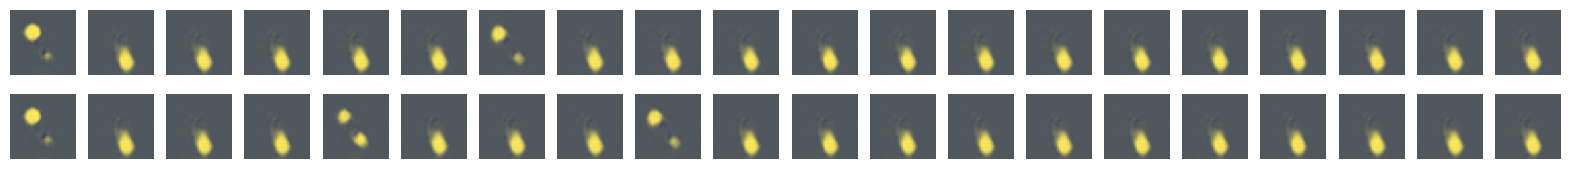

MSE: 0.00003
Pred MSE: 0.01843
Epoch: [25][50/313]	Time 0.099	ELBO 173886.0000	 MSE: 2.9123	 MSM: -6.2405e+01
Epoch: [25][100/313]	Time 0.109	ELBO 174408.7500	 MSE: 2.3954	 MSM: -5.9398e+01
Epoch: [25][150/313]	Time 0.144	ELBO 174872.8594	 MSE: 1.9274	 MSM: -6.2180e+01
Epoch: [25][200/313]	Time 0.100	ELBO 175343.8125	 MSE: 1.4605	 MSM: -6.0523e+01
Epoch: [25][250/313]	Time 0.107	ELBO 175131.0938	 MSE: 1.6703	 MSM: -6.3308e+01
Epoch: [25][300/313]	Time 0.106	ELBO 174933.7500	 MSE: 1.8676	 MSM: -5.8635e+01
MSE: 0.00002
Pred MSE: 0.01905
Epoch: [26][50/313]	Time 0.107	ELBO 174831.0625	 MSE: 1.9677	 MSM: -6.0400e+01
Epoch: [26][100/313]	Time 0.110	ELBO 175147.2031	 MSE: 1.6538	 MSM: -6.0465e+01
Epoch: [26][150/313]	Time 0.104	ELBO 175186.0156	 MSE: 1.6165	 MSM: -6.0154e+01
Epoch: [26][200/313]	Time 0.102	ELBO 175348.1875	 MSE: 1.4549	 MSM: -6.0197e+01
Epoch: [26][250/313]	Time 0.105	ELBO 173531.9062	 MSE: 3.2681	 MSM: -6.2621e+01
Epoch: [26][300/313]	Time 0.100	ELBO 175016.5312	 MSE: 1.781

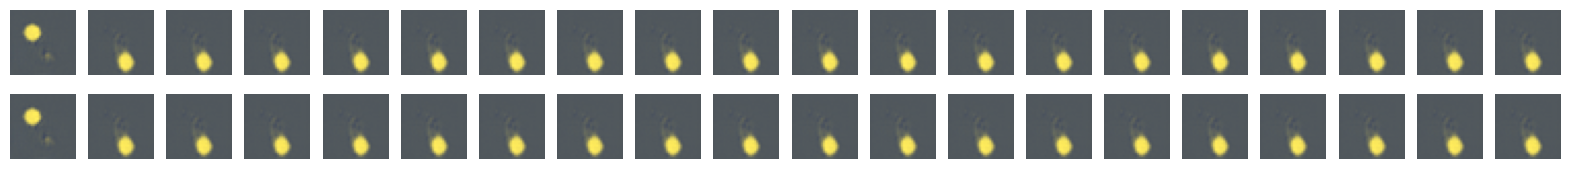

MSE: 0.00003
Pred MSE: 0.01929
Epoch: [27][50/313]	Time 0.099	ELBO 175488.3438	 MSE: 1.3101	 MSM: -6.2170e+01
Epoch: [27][100/313]	Time 0.111	ELBO 173341.0781	 MSE: 3.4652	 MSM: -5.9719e+01
Epoch: [27][150/313]	Time 0.120	ELBO 175276.3438	 MSE: 1.5242	 MSM: -6.2448e+01
Epoch: [27][200/313]	Time 0.109	ELBO 175395.5312	 MSE: 1.4079	 MSM: -5.8003e+01
Epoch: [27][250/313]	Time 0.106	ELBO 174964.7188	 MSE: 1.8327	 MSM: -6.1044e+01
Epoch: [27][300/313]	Time 0.108	ELBO 175034.7969	 MSE: 1.7676	 MSM: -5.9767e+01
MSE: 0.00003
Pred MSE: 0.01919
Epoch: [28][50/313]	Time 0.098	ELBO 174857.8750	 MSE: 1.9413	 MSM: -6.1728e+01
Epoch: [28][100/313]	Time 0.110	ELBO 174895.6250	 MSE: 1.9084	 MSM: -5.8775e+01
Epoch: [28][150/313]	Time 0.105	ELBO 175278.8750	 MSE: 1.5243	 MSM: -6.0292e+01
Epoch: [28][200/313]	Time 0.110	ELBO 175458.5938	 MSE: 1.3444	 MSM: -5.9950e+01
Epoch: [28][250/313]	Time 0.104	ELBO 175706.5156	 MSE: 1.1000	 MSM: -6.1448e+01
Epoch: [28][300/313]	Time 0.110	ELBO 175329.6406	 MSE: 1.475

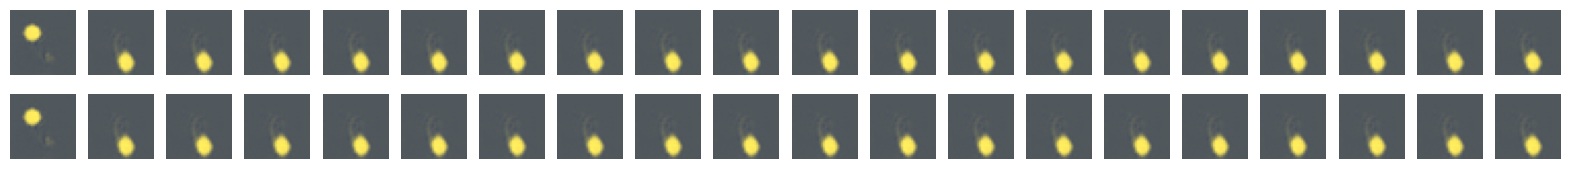

MSE: 0.00002
Pred MSE: 0.02023
Epoch: [29][50/313]	Time 0.107	ELBO 175752.7188	 MSE: 1.0579	 MSM: -6.1830e+01
Epoch: [29][100/313]	Time 0.103	ELBO 175757.0781	 MSE: 1.0497	 MSM: -6.2910e+01
Epoch: [29][150/313]	Time 0.102	ELBO 175583.0312	 MSE: 1.2217	 MSM: -6.1175e+01
Epoch: [29][200/313]	Time 0.106	ELBO 175653.6875	 MSE: 1.1502	 MSM: -6.1623e+01
Epoch: [29][250/313]	Time 0.109	ELBO 174104.4844	 MSE: 2.6972	 MSM: -6.2603e+01
Epoch: [29][300/313]	Time 0.105	ELBO 175967.9688	 MSE: 0.8350	 MSM: -6.2812e+01
MSE: 0.00002
Pred MSE: 0.01988
Epoch: [30][50/313]	Time 0.110	ELBO 175201.5312	 MSE: 1.6061	 MSM: -5.9779e+01
Epoch: [30][100/313]	Time 0.103	ELBO 174348.8281	 MSE: 2.4531	 MSM: -6.2121e+01
Epoch: [30][150/313]	Time 0.103	ELBO 175022.4688	 MSE: 1.7808	 MSM: -6.1021e+01
Epoch: [30][200/313]	Time 0.110	ELBO 175521.7969	 MSE: 1.2780	 MSM: -6.2983e+01
Epoch: [30][250/313]	Time 0.104	ELBO 175586.9531	 MSE: 1.2193	 MSM: -6.1694e+01
Epoch: [30][300/313]	Time 0.108	ELBO 175785.4219	 MSE: 1.023

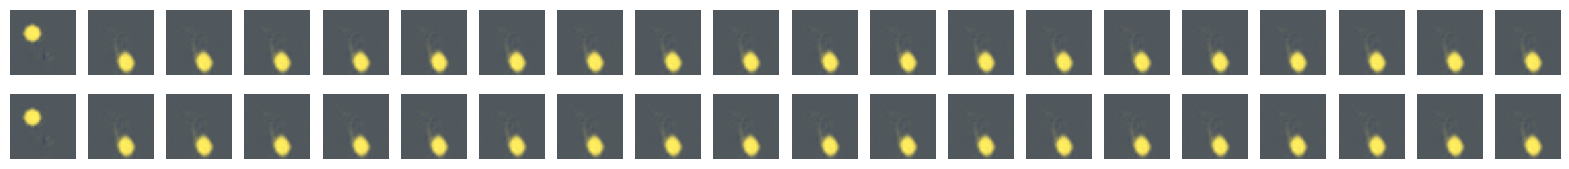

MSE: 0.00002
Pred MSE: 0.02065
Epoch: [31][50/313]	Time 0.100	ELBO 175523.6719	 MSE: 1.2886	 MSM: -5.8670e+01
Epoch: [31][100/313]	Time 0.098	ELBO 175025.8281	 MSE: 1.7796	 MSM: -6.1704e+01
Epoch: [31][150/313]	Time 0.099	ELBO 174927.2188	 MSE: 1.8767	 MSM: -5.9722e+01
Epoch: [31][200/313]	Time 0.099	ELBO 175070.3906	 MSE: 1.7349	 MSM: -6.1457e+01
Epoch: [31][250/313]	Time 0.104	ELBO 175674.0938	 MSE: 1.1285	 MSM: -6.3786e+01
Epoch: [31][300/313]	Time 0.099	ELBO 175765.5156	 MSE: 1.0390	 MSM: -6.0606e+01
MSE: 0.00004
Pred MSE: 0.02000
Epoch: [32][50/313]	Time 0.099	ELBO 175560.5312	 MSE: 1.2442	 MSM: -6.4406e+01
Epoch: [32][100/313]	Time 0.099	ELBO 159562.9688	 MSE: 17.2441	 MSM: -5.7012e+01
Epoch: [32][150/313]	Time 0.100	ELBO 171871.8594	 MSE: 4.9287	 MSM: -5.7253e+01
Epoch: [32][200/313]	Time 0.098	ELBO 172844.8438	 MSE: 3.9543	 MSM: -5.5551e+01
Epoch: [32][250/313]	Time 0.098	ELBO 173402.5938	 MSE: 3.3937	 MSM: -5.9590e+01
Epoch: [32][300/313]	Time 0.100	ELBO 175180.3594	 MSE: 1.61

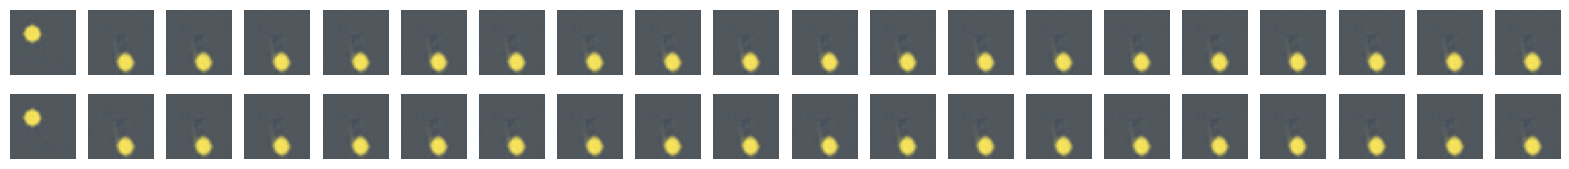

MSE: 0.00006
Pred MSE: 0.01915
Epoch: [33][50/313]	Time 0.100	ELBO 174969.6250	 MSE: 1.8379	 MSM: -5.6562e+01
Epoch: [33][100/313]	Time 0.133	ELBO 174002.7969	 MSE: 2.7981	 MSM: -5.9703e+01
Epoch: [33][150/313]	Time 0.110	ELBO 174067.0781	 MSE: 2.7376	 MSM: -5.9421e+01
Epoch: [33][200/313]	Time 0.107	ELBO 174251.4531	 MSE: 2.5557	 MSM: -5.4036e+01
Epoch: [33][250/313]	Time 0.103	ELBO 175323.9062	 MSE: 1.4820	 MSM: -5.6700e+01
Epoch: [33][300/313]	Time 0.104	ELBO 175512.2344	 MSE: 1.2955	 MSM: -5.6081e+01
MSE: 0.00002
Pred MSE: 0.02046
Epoch: [34][50/313]	Time 0.099	ELBO 175227.8125	 MSE: 1.5814	 MSM: -5.8732e+01
Epoch: [34][100/313]	Time 0.098	ELBO 176225.1562	 MSE: 0.5778	 MSM: -5.8481e+01
Epoch: [34][150/313]	Time 0.100	ELBO 174967.2188	 MSE: 1.8374	 MSM: -5.6983e+01
Epoch: [34][200/313]	Time 0.098	ELBO 174132.1250	 MSE: 2.6751	 MSM: -5.6136e+01
Epoch: [34][250/313]	Time 0.100	ELBO 175753.2812	 MSE: 1.0502	 MSM: -5.8523e+01
Epoch: [34][300/313]	Time 0.100	ELBO 175540.5469	 MSE: 1.264

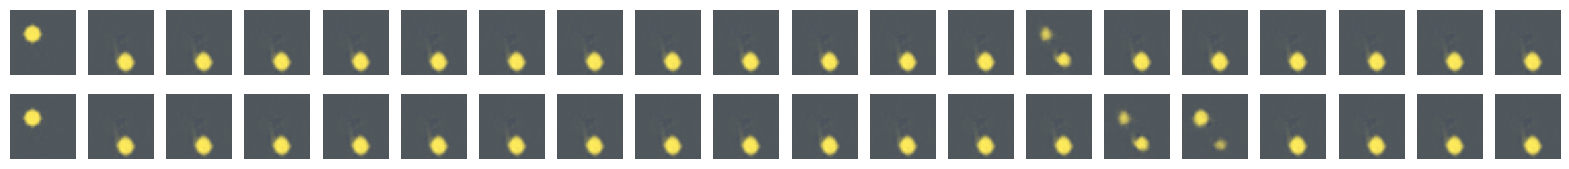

MSE: 0.00002
Pred MSE: 0.01980
Epoch: [35][50/313]	Time 0.100	ELBO 175730.3750	 MSE: 1.0766	 MSM: -5.8871e+01
Epoch: [35][100/313]	Time 0.099	ELBO 175516.9375	 MSE: 1.2907	 MSM: -5.6965e+01
Epoch: [35][150/313]	Time 0.099	ELBO 175902.9062	 MSE: 0.9076	 MSM: -6.0829e+01
Epoch: [35][200/313]	Time 0.104	ELBO 176028.6562	 MSE: 0.7850	 MSM: -5.8856e+01
Epoch: [35][250/313]	Time 0.109	ELBO 173832.0781	 MSE: 2.9759	 MSM: -5.6835e+01
Epoch: [35][300/313]	Time 0.110	ELBO 175174.2969	 MSE: 1.6344	 MSM: -5.8278e+01
MSE: 0.00003
Pred MSE: 0.01932
Epoch: [36][50/313]	Time 0.111	ELBO 175678.8750	 MSE: 1.1306	 MSM: -5.6190e+01
Epoch: [36][100/313]	Time 0.103	ELBO 175836.1875	 MSE: 0.9729	 MSM: -5.7409e+01
Epoch: [36][150/313]	Time 0.103	ELBO 175681.1875	 MSE: 1.1273	 MSM: -5.6513e+01
Epoch: [36][200/313]	Time 0.111	ELBO 175693.4375	 MSE: 1.1112	 MSM: -5.9791e+01
Epoch: [36][250/313]	Time 0.106	ELBO 175666.4844	 MSE: 1.1467	 MSM: -5.6675e+01
Epoch: [36][300/313]	Time 0.103	ELBO 174847.7344	 MSE: 1.960

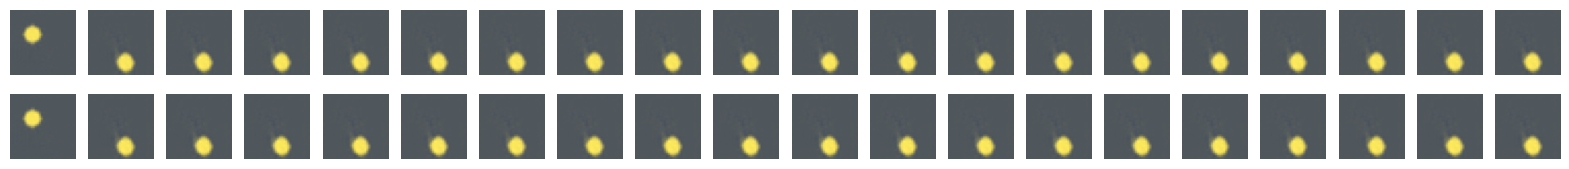

MSE: 0.00002
Pred MSE: 0.02045
Epoch: [37][50/313]	Time 0.106	ELBO 175657.1250	 MSE: 1.1510	 MSM: -5.9461e+01
Epoch: [37][100/313]	Time 0.104	ELBO 173937.5000	 MSE: 2.8645	 MSM: -5.9079e+01
Epoch: [37][150/313]	Time 0.103	ELBO 174744.8750	 MSE: 2.0549	 MSM: -5.7492e+01
Epoch: [37][200/313]	Time 0.106	ELBO 173695.5781	 MSE: 3.1077	 MSM: -5.7021e+01
Epoch: [37][250/313]	Time 0.100	ELBO 175058.1719	 MSE: 1.7512	 MSM: -5.8704e+01
Epoch: [37][300/313]	Time 0.105	ELBO 175817.9688	 MSE: 0.9968	 MSM: -5.7270e+01
MSE: 0.00001
Pred MSE: 0.01996
Epoch: [38][50/313]	Time 0.109	ELBO 175977.3906	 MSE: 0.8353	 MSM: -5.6888e+01
Epoch: [38][100/313]	Time 0.128	ELBO 175756.9375	 MSE: 1.0549	 MSM: -5.8692e+01
Epoch: [38][150/313]	Time 0.115	ELBO 173003.5156	 MSE: 3.8064	 MSM: -5.7577e+01
Epoch: [38][200/313]	Time 0.108	ELBO 175289.2031	 MSE: 1.5177	 MSM: -6.0502e+01
Epoch: [38][250/313]	Time 0.103	ELBO 175831.8438	 MSE: 0.9869	 MSM: -5.7819e+01
Epoch: [38][300/313]	Time 0.113	ELBO 175980.5469	 MSE: 0.832

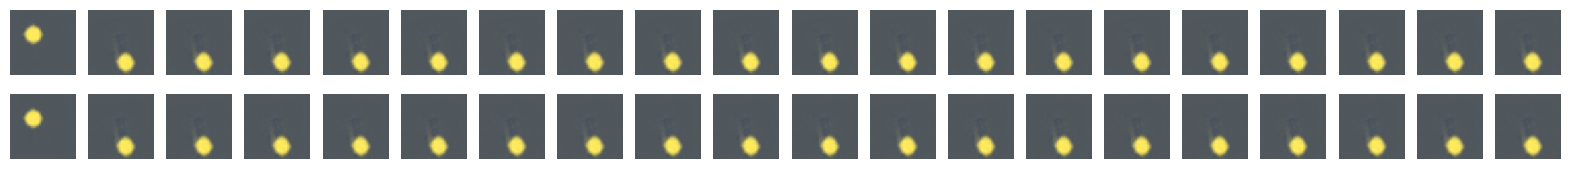

MSE: 0.00001
Pred MSE: 0.02024
Epoch: [39][50/313]	Time 0.105	ELBO 175144.4219	 MSE: 1.6659	 MSM: -5.7831e+01
Epoch: [39][100/313]	Time 0.103	ELBO 173547.7031	 MSE: 3.2585	 MSM: -5.9147e+01
Epoch: [39][150/313]	Time 0.101	ELBO 174685.3750	 MSE: 2.1179	 MSM: -5.8856e+01
Epoch: [39][200/313]	Time 0.098	ELBO 175582.7969	 MSE: 1.2263	 MSM: -5.7513e+01
Epoch: [39][250/313]	Time 0.099	ELBO 175439.3750	 MSE: 1.3785	 MSM: -5.7247e+01
Epoch: [39][300/313]	Time 0.103	ELBO 175936.2969	 MSE: 0.8773	 MSM: -5.8242e+01
MSE: 0.00001
Pred MSE: 0.02060
Epoch: [40][50/313]	Time 0.108	ELBO 175801.9531	 MSE: 1.0142	 MSM: -5.4911e+01
Epoch: [40][100/313]	Time 0.101	ELBO 175954.5000	 MSE: 0.8575	 MSM: -5.8617e+01
Epoch: [40][150/313]	Time 0.110	ELBO 174755.1562	 MSE: 2.0612	 MSM: -6.0545e+01
Epoch: [40][200/313]	Time 0.103	ELBO 175899.3750	 MSE: 0.9169	 MSM: -5.7784e+01
Epoch: [40][250/313]	Time 0.110	ELBO 175640.2031	 MSE: 1.1804	 MSM: -5.9457e+01
Epoch: [40][300/313]	Time 0.108	ELBO 176153.7344	 MSE: 0.666

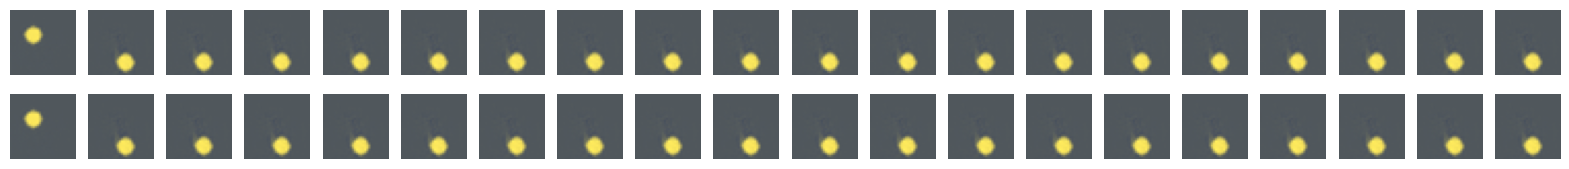

MSE: 0.00001
Pred MSE: 0.01997
Epoch: [41][50/313]	Time 0.104	ELBO 176296.6406	 MSE: 0.5258	 MSM: -5.9283e+01
Epoch: [41][100/313]	Time 0.110	ELBO 176362.7969	 MSE: 0.4574	 MSM: -5.8215e+01
Epoch: [41][150/313]	Time 0.104	ELBO 176296.8281	 MSE: 0.5258	 MSM: -5.7350e+01
Epoch: [41][200/313]	Time 0.102	ELBO 133242.2031	 MSE: 43.5549	 MSM: -6.5452e+01
Epoch: [41][250/313]	Time 0.110	ELBO 169574.3438	 MSE: 7.2208	 MSM: -6.3376e+01
Epoch: [41][300/313]	Time 0.106	ELBO 169488.4531	 MSE: 7.3084	 MSM: -6.1665e+01
MSE: 0.00010
Pred MSE: 0.01985
Epoch: [42][50/313]	Time 0.107	ELBO 173009.2344	 MSE: 3.7940	 MSM: -6.0575e+01
Epoch: [42][100/313]	Time 0.106	ELBO 171980.6250	 MSE: 4.8183	 MSM: -5.9300e+01
Epoch: [42][150/313]	Time 0.109	ELBO 174306.8125	 MSE: 2.4967	 MSM: -6.0817e+01
Epoch: [42][200/313]	Time 0.112	ELBO 174321.3594	 MSE: 2.4843	 MSM: -5.9791e+01
Epoch: [42][250/313]	Time 0.106	ELBO 174710.3750	 MSE: 2.0893	 MSM: -6.3867e+01
Epoch: [42][300/313]	Time 0.109	ELBO 175237.5156	 MSE: 1.57

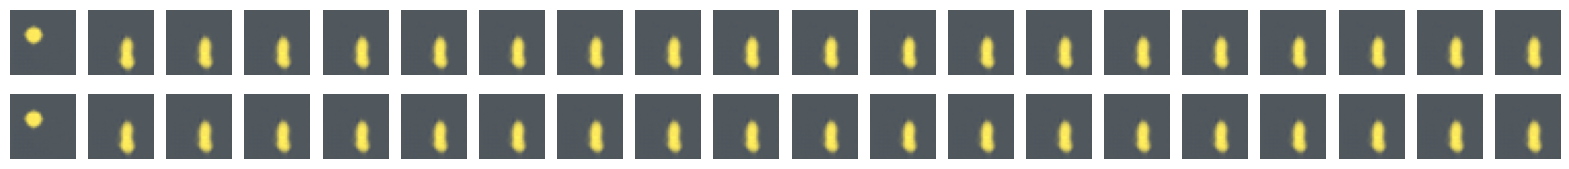

MSE: 0.00003
Pred MSE: 0.02023
Epoch: [43][50/313]	Time 0.100	ELBO 175426.5312	 MSE: 1.3789	 MSM: -6.0869e+01
Epoch: [43][100/313]	Time 0.099	ELBO 175481.6875	 MSE: 1.3256	 MSM: -5.7342e+01
Epoch: [43][150/313]	Time 0.099	ELBO 175688.7188	 MSE: 1.1225	 MSM: -5.7595e+01
Epoch: [43][200/313]	Time 0.099	ELBO 175193.7969	 MSE: 1.6140	 MSM: -5.8733e+01
Epoch: [43][250/313]	Time 0.100	ELBO 173112.8750	 MSE: 3.6934	 MSM: -5.9646e+01
Epoch: [43][300/313]	Time 0.098	ELBO 175595.9375	 MSE: 1.2161	 MSM: -5.8102e+01
MSE: 0.00003
Pred MSE: 0.01913
Epoch: [44][50/313]	Time 0.106	ELBO 175294.0781	 MSE: 1.5076	 MSM: -6.1356e+01
Epoch: [44][100/313]	Time 0.188	ELBO 176065.2031	 MSE: 0.7395	 MSM: -6.1657e+01
Epoch: [44][150/313]	Time 0.099	ELBO 175796.8750	 MSE: 1.0138	 MSM: -5.9888e+01
Epoch: [44][200/313]	Time 0.098	ELBO 175574.0000	 MSE: 1.2349	 MSM: -6.2144e+01
Epoch: [44][250/313]	Time 0.099	ELBO 176022.6562	 MSE: 0.7857	 MSM: -6.1769e+01
Epoch: [44][300/313]	Time 0.099	ELBO 175569.7188	 MSE: 1.239

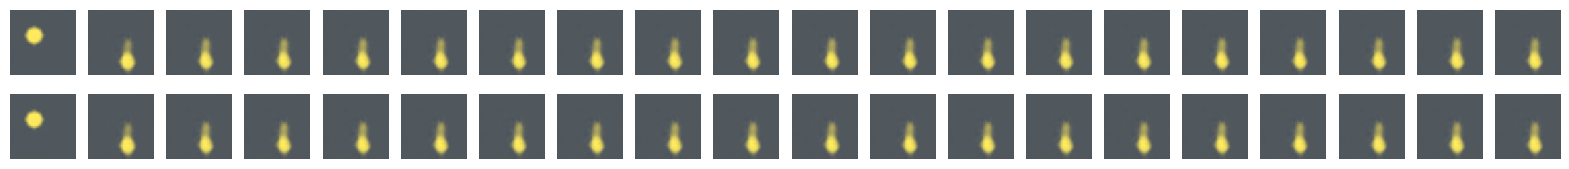

MSE: 0.00001
Pred MSE: 0.01684
Epoch: [45][50/313]	Time 0.098	ELBO 175976.9375	 MSE: 0.8311	 MSM: -6.1929e+01
Epoch: [45][100/313]	Time 0.098	ELBO 175863.1875	 MSE: 0.9507	 MSM: -5.7147e+01
Epoch: [45][150/313]	Time 0.112	ELBO 175525.8594	 MSE: 1.2866	 MSM: -5.9263e+01
Epoch: [45][200/313]	Time 0.108	ELBO 175673.5000	 MSE: 1.1430	 MSM: -5.6732e+01
Epoch: [45][250/313]	Time 0.108	ELBO 176397.4531	 MSE: 0.4200	 MSM: -6.0836e+01
Epoch: [45][300/313]	Time 0.110	ELBO 175386.1562	 MSE: 1.4220	 MSM: -5.9155e+01
MSE: 0.00002
Pred MSE: 0.01871
Epoch: [46][50/313]	Time 0.099	ELBO 175704.7344	 MSE: 1.1035	 MSM: -5.8523e+01
Epoch: [46][100/313]	Time 0.101	ELBO 175178.6562	 MSE: 1.6378	 MSM: -5.7232e+01
Epoch: [46][150/313]	Time 0.110	ELBO 174436.6406	 MSE: 2.3746	 MSM: -5.9117e+01
Epoch: [46][200/313]	Time 0.111	ELBO 176163.0781	 MSE: 0.6530	 MSM: -5.8806e+01
Epoch: [46][250/313]	Time 0.108	ELBO 175738.7656	 MSE: 1.0741	 MSM: -5.8775e+01
Epoch: [46][300/313]	Time 0.107	ELBO 175748.3906	 MSE: 1.068

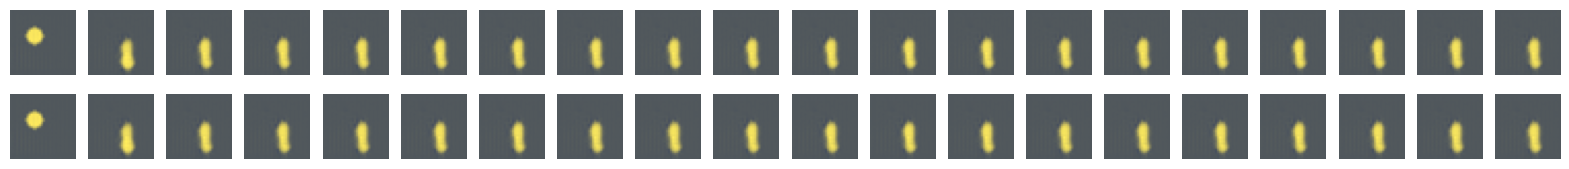

MSE: 0.00002
Pred MSE: 0.01723
Epoch: [47][50/313]	Time 0.104	ELBO 175465.0781	 MSE: 1.3484	 MSM: -5.9688e+01
Epoch: [47][100/313]	Time 0.104	ELBO 175924.8438	 MSE: 0.8893	 MSM: -6.2208e+01
Epoch: [47][150/313]	Time 0.103	ELBO 176110.6875	 MSE: 0.7114	 MSM: -5.6998e+01
Epoch: [47][200/313]	Time 0.108	ELBO 175841.6875	 MSE: 0.9737	 MSM: -5.8245e+01
Epoch: [47][250/313]	Time 0.114	ELBO 176419.9688	 MSE: 0.3954	 MSM: -6.0970e+01
Epoch: [47][300/313]	Time 0.108	ELBO 176160.2500	 MSE: 0.6613	 MSM: -5.9708e+01
MSE: 0.00001
Pred MSE: 0.01720
Epoch: [48][50/313]	Time 0.103	ELBO 176166.9062	 MSE: 0.6555	 MSM: -5.9031e+01
Epoch: [48][100/313]	Time 0.106	ELBO 176364.7500	 MSE: 0.4612	 MSM: -5.7234e+01
Epoch: [48][150/313]	Time 0.112	ELBO 176343.7656	 MSE: 0.4824	 MSM: -5.5714e+01
Epoch: [48][200/313]	Time 0.100	ELBO 175760.0938	 MSE: 1.0597	 MSM: -5.8707e+01
Epoch: [48][250/313]	Time 0.110	ELBO 174570.0469	 MSE: 2.2450	 MSM: -5.8008e+01
Epoch: [48][300/313]	Time 0.104	ELBO 175983.7031	 MSE: 0.830

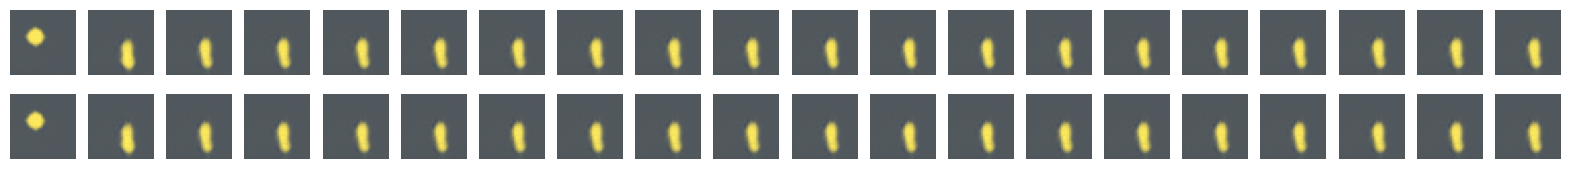

MSE: 0.00003
Pred MSE: 0.01744
Epoch: [49][50/313]	Time 0.102	ELBO 173963.5156	 MSE: 2.8445	 MSM: -6.0057e+01
Epoch: [49][100/313]	Time 0.106	ELBO 176039.2188	 MSE: 0.7709	 MSM: -5.7400e+01
Epoch: [49][150/313]	Time 0.107	ELBO 175679.1406	 MSE: 1.1266	 MSM: -5.9866e+01
Epoch: [49][200/313]	Time 0.113	ELBO 175837.3281	 MSE: 0.9847	 MSM: -5.8458e+01
Epoch: [49][250/313]	Time 0.111	ELBO 176210.7188	 MSE: 0.6106	 MSM: -5.7797e+01
Epoch: [49][300/313]	Time 0.109	ELBO 176240.9219	 MSE: 0.5849	 MSM: -5.6721e+01
MSE: 0.00001
Pred MSE: 0.01521
Epoch: [50][50/313]	Time 0.112	ELBO 174511.5469	 MSE: 2.2979	 MSM: -6.2756e+01
Epoch: [50][100/313]	Time 0.106	ELBO 175680.0938	 MSE: 1.1395	 MSM: -5.7974e+01
Epoch: [50][150/313]	Time 0.108	ELBO 176141.0000	 MSE: 0.6727	 MSM: -5.8611e+01
Epoch: [50][200/313]	Time 0.107	ELBO 176061.0781	 MSE: 0.7613	 MSM: -5.6323e+01
Epoch: [50][250/313]	Time 0.108	ELBO 176439.5625	 MSE: 0.3819	 MSM: -6.0180e+01
Epoch: [50][300/313]	Time 0.108	ELBO 175841.4844	 MSE: 0.973

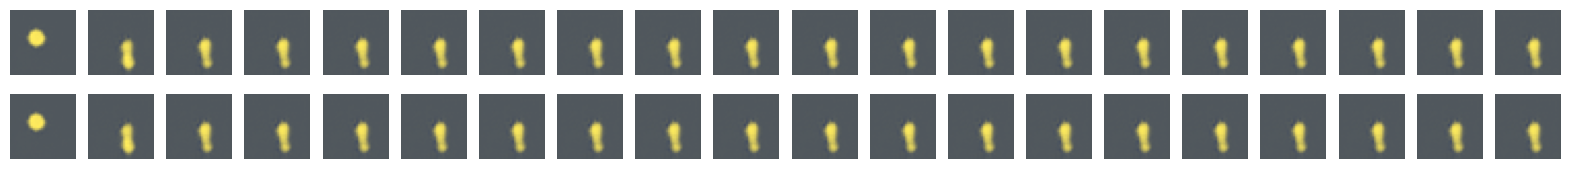

MSE: 0.00001
Pred MSE: 0.01567
Epoch: [51][50/313]	Time 0.106	ELBO 176270.6875	 MSE: 0.5509	 MSM: -5.8864e+01
Epoch: [51][100/313]	Time 0.103	ELBO 176371.7969	 MSE: 0.4555	 MSM: -5.9550e+01
Epoch: [51][150/313]	Time 0.102	ELBO 176186.9375	 MSE: 0.6368	 MSM: -5.9350e+01
Epoch: [51][200/313]	Time 0.106	ELBO 176400.0938	 MSE: 0.4245	 MSM: -5.8473e+01
Epoch: [51][250/313]	Time 0.104	ELBO 174713.4531	 MSE: 2.1085	 MSM: -5.7960e+01
Epoch: [51][300/313]	Time 0.110	ELBO 174913.3906	 MSE: 1.9009	 MSM: -6.0015e+01
MSE: 0.00003
Pred MSE: 0.01657
Epoch: [52][50/313]	Time 0.101	ELBO 176085.8281	 MSE: 0.7256	 MSM: -5.9187e+01
Epoch: [52][100/313]	Time 0.110	ELBO 176049.8750	 MSE: 0.7579	 MSM: -6.3023e+01
Epoch: [52][150/313]	Time 0.108	ELBO 175928.2344	 MSE: 0.8883	 MSM: -5.6846e+01
Epoch: [52][200/313]	Time 0.123	ELBO 173602.5156	 MSE: 3.2124	 MSM: -5.7772e+01
Epoch: [52][250/313]	Time 0.106	ELBO 175504.7656	 MSE: 1.3051	 MSM: -6.0009e+01
Epoch: [52][300/313]	Time 0.103	ELBO 176264.9375	 MSE: 0.548

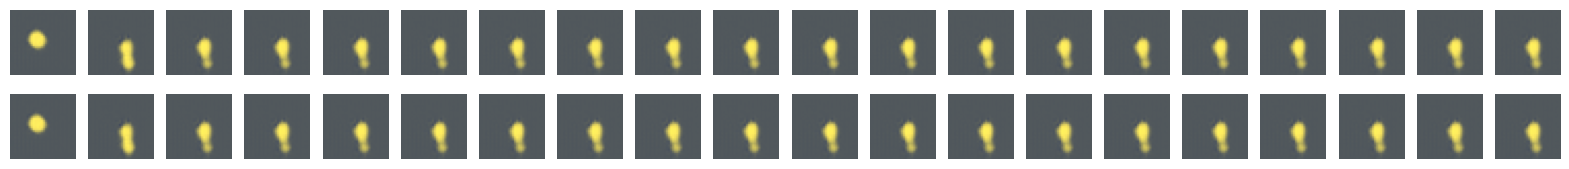

MSE: 0.00003
Pred MSE: 0.01668
Epoch: [53][50/313]	Time 0.105	ELBO 175918.9688	 MSE: 0.9032	 MSM: -5.8199e+01
Epoch: [53][100/313]	Time 0.098	ELBO 175779.0781	 MSE: 1.0393	 MSM: -5.7918e+01
Epoch: [53][150/313]	Time 0.099	ELBO 175915.4688	 MSE: 0.8991	 MSM: -5.9401e+01
Epoch: [53][200/313]	Time 0.101	ELBO 174367.3125	 MSE: 2.4502	 MSM: -5.7423e+01
Epoch: [53][250/313]	Time 0.101	ELBO 176201.1875	 MSE: 0.6140	 MSM: -5.9559e+01
Epoch: [53][300/313]	Time 0.101	ELBO 176485.7344	 MSE: 0.3396	 MSM: -5.9022e+01
MSE: 0.00001
Pred MSE: 0.01629
Epoch: [54][50/313]	Time 0.098	ELBO 176033.8438	 MSE: 0.7954	 MSM: -5.6758e+01
Epoch: [54][100/313]	Time 0.101	ELBO 176486.5781	 MSE: 0.3356	 MSM: -5.8951e+01
Epoch: [54][150/313]	Time 0.099	ELBO 175823.1094	 MSE: 0.9981	 MSM: -5.8537e+01
Epoch: [54][200/313]	Time 0.098	ELBO 175852.6719	 MSE: 0.9634	 MSM: -5.9757e+01
Epoch: [54][250/313]	Time 0.100	ELBO 175525.8125	 MSE: 1.2896	 MSM: -6.2164e+01
Epoch: [54][300/313]	Time 0.110	ELBO 174382.3906	 MSE: 2.439

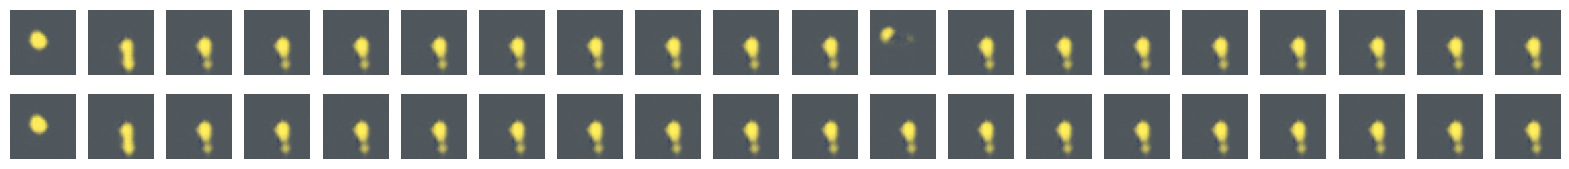

MSE: 0.00004
Pred MSE: 0.01668
Epoch: [55][50/313]	Time 0.111	ELBO 174527.6250	 MSE: 2.2786	 MSM: -5.9346e+01
Epoch: [55][100/313]	Time 0.105	ELBO 173522.4375	 MSE: 3.2852	 MSM: -5.9816e+01
Epoch: [55][150/313]	Time 0.104	ELBO 175847.7031	 MSE: 0.9639	 MSM: -5.7872e+01
Epoch: [55][200/313]	Time 0.107	ELBO 175288.9688	 MSE: 1.5278	 MSM: -5.7893e+01
Epoch: [55][250/313]	Time 0.109	ELBO 176192.7969	 MSE: 0.6243	 MSM: -6.1330e+01
Epoch: [55][300/313]	Time 0.104	ELBO 176198.5156	 MSE: 0.6258	 MSM: -6.0149e+01
MSE: 0.00001
Pred MSE: 0.01524
Epoch: [56][50/313]	Time 0.102	ELBO 176279.2656	 MSE: 0.5481	 MSM: -5.9117e+01
Epoch: [56][100/313]	Time 0.110	ELBO 175795.7344	 MSE: 1.0340	 MSM: -5.9408e+01
Epoch: [56][150/313]	Time 0.105	ELBO 174853.4688	 MSE: 1.9614	 MSM: -6.1261e+01
Epoch: [56][200/313]	Time 0.104	ELBO 176336.9062	 MSE: 0.4879	 MSM: -5.8653e+01
Epoch: [56][250/313]	Time 0.101	ELBO 176285.7969	 MSE: 0.5418	 MSM: -6.0444e+01
Epoch: [56][300/313]	Time 0.106	ELBO 176391.1719	 MSE: 0.435

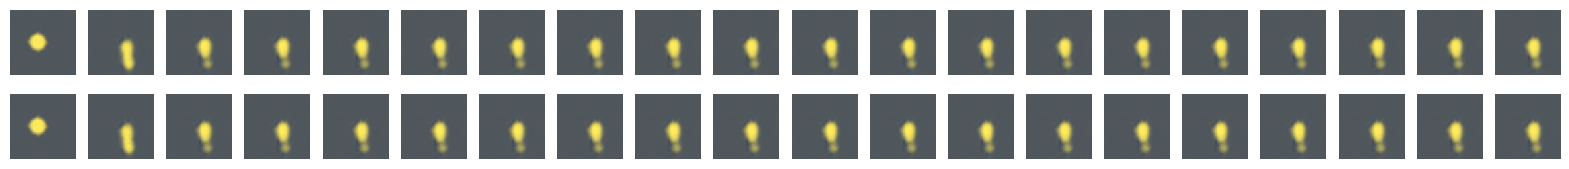

MSE: 0.00001
Pred MSE: 0.01514
Epoch: [57][50/313]	Time 0.111	ELBO 174721.8281	 MSE: 2.0937	 MSM: -6.1565e+01
Epoch: [57][100/313]	Time 0.102	ELBO 176044.0156	 MSE: 0.7715	 MSM: -5.9025e+01
Epoch: [57][150/313]	Time 0.099	ELBO 174557.4375	 MSE: 2.2667	 MSM: -5.9632e+01
Epoch: [57][200/313]	Time 0.100	ELBO 175422.7812	 MSE: 1.3929	 MSM: -6.0145e+01
Epoch: [57][250/313]	Time 0.107	ELBO 175422.3125	 MSE: 1.4004	 MSM: -5.9168e+01
Epoch: [57][300/313]	Time 0.106	ELBO 175758.1094	 MSE: 1.0611	 MSM: -6.0104e+01
MSE: 0.00003
Pred MSE: 0.01460
Epoch: [58][50/313]	Time 0.105	ELBO 175832.1562	 MSE: 0.9880	 MSM: -6.0592e+01
Epoch: [58][100/313]	Time 0.104	ELBO 175297.2969	 MSE: 1.5254	 MSM: -6.0132e+01
Epoch: [58][150/313]	Time 0.105	ELBO 176326.6719	 MSE: 0.5025	 MSM: -5.8416e+01
Epoch: [58][200/313]	Time 0.106	ELBO 176492.5781	 MSE: 0.3394	 MSM: -5.9022e+01
Epoch: [58][250/313]	Time 0.108	ELBO 176222.1875	 MSE: 0.6122	 MSM: -5.6407e+01
Epoch: [58][300/313]	Time 0.112	ELBO 176353.0156	 MSE: 0.480

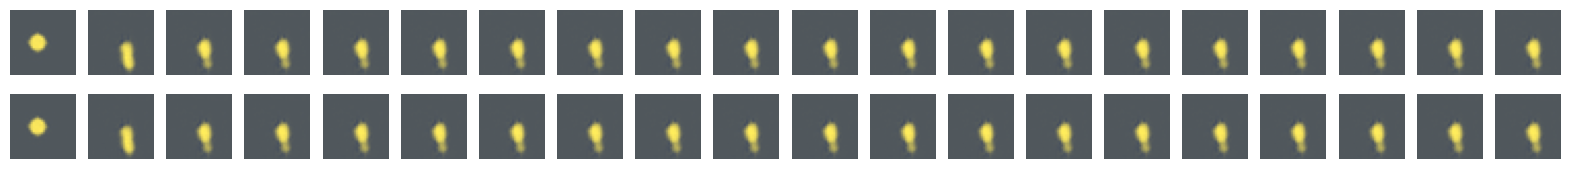

MSE: 0.00001
Pred MSE: 0.01547
Epoch: [59][50/313]	Time 0.108	ELBO 173480.2812	 MSE: 3.3372	 MSM: -6.0182e+01
Epoch: [59][100/313]	Time 0.098	ELBO 175975.1719	 MSE: 0.8513	 MSM: -5.8487e+01
Epoch: [59][150/313]	Time 0.109	ELBO 176569.2812	 MSE: 0.2608	 MSM: -5.7707e+01
Epoch: [59][200/313]	Time 0.108	ELBO 176164.5781	 MSE: 0.6659	 MSM: -5.7023e+01
Epoch: [59][250/313]	Time 0.105	ELBO 175395.7969	 MSE: 1.4239	 MSM: -6.1552e+01
Epoch: [59][300/313]	Time 0.107	ELBO 176465.3281	 MSE: 0.3570	 MSM: -5.9823e+01
MSE: 0.00001
Pred MSE: 0.01504
Epoch: [60][50/313]	Time 0.102	ELBO 170210.0469	 MSE: 6.6068	 MSM: -6.1445e+01
Epoch: [60][100/313]	Time 0.105	ELBO 175532.7500	 MSE: 1.2763	 MSM: -6.0883e+01
Epoch: [60][150/313]	Time 0.102	ELBO 175553.1406	 MSE: 1.2658	 MSM: -5.7424e+01
Epoch: [60][200/313]	Time 0.107	ELBO 175434.5312	 MSE: 1.3784	 MSM: -6.2751e+01
Epoch: [60][250/313]	Time 0.104	ELBO 176087.4688	 MSE: 0.7283	 MSM: -5.9141e+01
Epoch: [60][300/313]	Time 0.105	ELBO 175492.5625	 MSE: 1.332

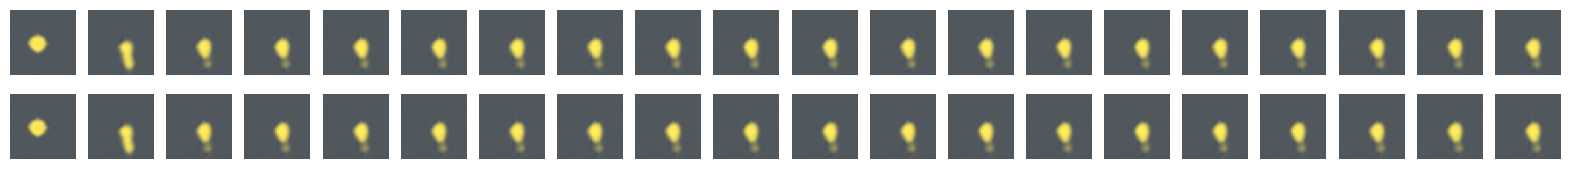

MSE: 0.00001
Pred MSE: 0.01536
Epoch: [61][50/313]	Time 0.107	ELBO 175286.8750	 MSE: 1.5372	 MSM: -5.8526e+01
Epoch: [61][100/313]	Time 0.108	ELBO 175835.0625	 MSE: 0.9929	 MSM: -5.7292e+01
Epoch: [61][150/313]	Time 0.110	ELBO 176240.2500	 MSE: 0.5817	 MSM: -5.8794e+01
Epoch: [61][200/313]	Time 0.104	ELBO 175419.9219	 MSE: 1.4062	 MSM: -5.8116e+01
Epoch: [61][250/313]	Time 0.111	ELBO 176532.0312	 MSE: 0.2948	 MSM: -5.6414e+01
Epoch: [61][300/313]	Time 0.110	ELBO 173897.7344	 MSE: 2.9328	 MSM: -5.6501e+01
MSE: 0.00001
Pred MSE: 0.01546
Epoch: [62][50/313]	Time 0.101	ELBO 176128.6094	 MSE: 0.6951	 MSM: -6.1362e+01
Epoch: [62][100/313]	Time 0.101	ELBO 175796.4219	 MSE: 1.0306	 MSM: -5.7447e+01
Epoch: [62][150/313]	Time 0.099	ELBO 176427.7656	 MSE: 0.3966	 MSM: -5.9089e+01
Epoch: [62][200/313]	Time 0.100	ELBO 176393.6406	 MSE: 0.4418	 MSM: -5.8638e+01
Epoch: [62][250/313]	Time 0.098	ELBO 175593.6250	 MSE: 1.2276	 MSM: -5.9021e+01
Epoch: [62][300/313]	Time 0.099	ELBO 176379.3125	 MSE: 0.442

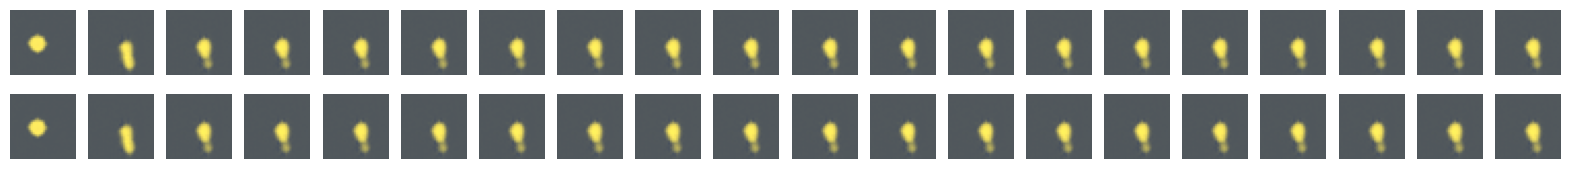

MSE: 0.00001
Pred MSE: 0.01613
Epoch: [63][50/313]	Time 0.099	ELBO 176426.1875	 MSE: 0.3996	 MSM: -5.8976e+01
Epoch: [63][100/313]	Time 0.100	ELBO 175370.0312	 MSE: 1.4586	 MSM: -5.7586e+01
Epoch: [63][150/313]	Time 0.099	ELBO 174798.1562	 MSE: 2.0290	 MSM: -5.7277e+01
Epoch: [63][200/313]	Time 0.110	ELBO 176181.9688	 MSE: 0.6371	 MSM: -6.1207e+01
Epoch: [63][250/313]	Time 0.110	ELBO 176298.6562	 MSE: 0.5250	 MSM: -5.9088e+01
Epoch: [63][300/313]	Time 0.110	ELBO 176150.5781	 MSE: 0.6750	 MSM: -6.1987e+01
MSE: 0.00001
Pred MSE: 0.01566
Epoch: [64][50/313]	Time 0.111	ELBO 176075.9531	 MSE: 0.7482	 MSM: -6.1866e+01
Epoch: [64][100/313]	Time 0.099	ELBO 176275.5000	 MSE: 0.5514	 MSM: -5.7018e+01
Epoch: [64][150/313]	Time 0.098	ELBO 175824.4375	 MSE: 1.0027	 MSM: -5.7984e+01
Epoch: [64][200/313]	Time 0.098	ELBO 176497.9531	 MSE: 0.3341	 MSM: -5.9388e+01
Epoch: [64][250/313]	Time 0.098	ELBO 176414.5469	 MSE: 0.4142	 MSM: -5.7961e+01
Epoch: [64][300/313]	Time 0.099	ELBO 176361.4219	 MSE: 0.472

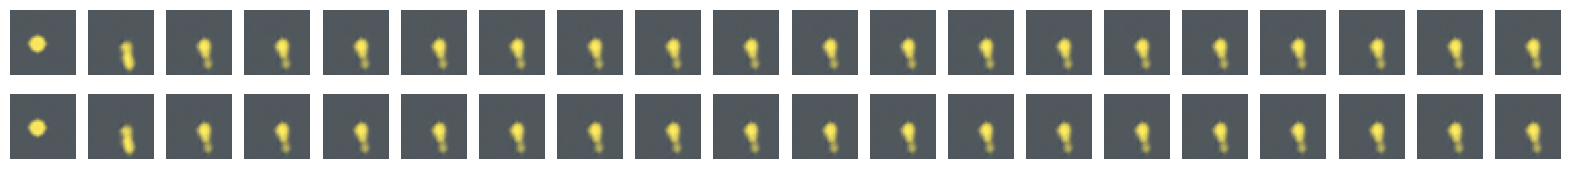

MSE: 0.00001
Pred MSE: 0.01478
Epoch: [65][50/313]	Time 0.108	ELBO 176465.6250	 MSE: 0.3745	 MSM: -5.7305e+01
Epoch: [65][100/313]	Time 0.111	ELBO 176256.5625	 MSE: 0.5808	 MSM: -5.7174e+01
Epoch: [65][150/313]	Time 0.104	ELBO 176259.5312	 MSE: 0.5678	 MSM: -5.7470e+01
Epoch: [65][200/313]	Time 0.110	ELBO 176323.4688	 MSE: 0.5023	 MSM: -5.8515e+01
Epoch: [65][250/313]	Time 0.102	ELBO 176156.8594	 MSE: 0.6619	 MSM: -5.9446e+01
Epoch: [65][300/313]	Time 0.101	ELBO 176038.5469	 MSE: 0.7855	 MSM: -6.0903e+01
MSE: 0.00001
Pred MSE: 0.01555
Epoch: [66][50/313]	Time 0.099	ELBO 176477.0625	 MSE: 0.3497	 MSM: -6.0544e+01
Epoch: [66][100/313]	Time 0.101	ELBO 176106.9219	 MSE: 0.7282	 MSM: -5.9224e+01
Epoch: [66][150/313]	Time 0.098	ELBO 176034.0156	 MSE: 0.7850	 MSM: -5.9741e+01
Epoch: [66][200/313]	Time 0.109	ELBO 176351.2344	 MSE: 0.4599	 MSM: -5.9937e+01
Epoch: [66][250/313]	Time 0.103	ELBO 176226.7344	 MSE: 0.5944	 MSM: -5.9179e+01
Epoch: [66][300/313]	Time 0.113	ELBO 176214.4219	 MSE: 0.608

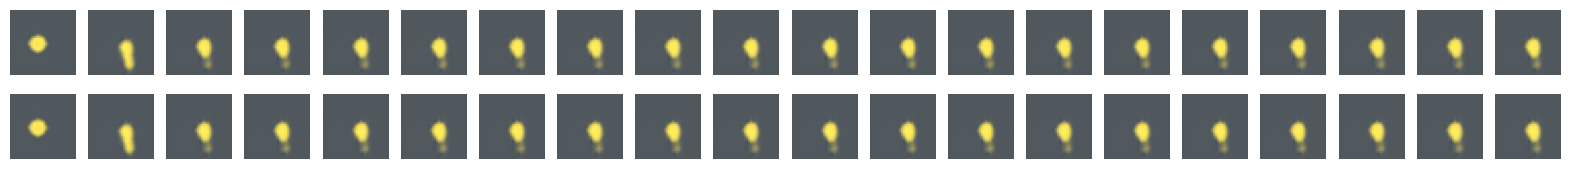

MSE: 0.00005
Pred MSE: 0.01591
Epoch: [67][50/313]	Time 0.109	ELBO 176083.0469	 MSE: 0.7376	 MSM: -5.9760e+01
Epoch: [67][100/313]	Time 0.105	ELBO 176359.2188	 MSE: 0.4733	 MSM: -5.9827e+01
Epoch: [67][150/313]	Time 0.109	ELBO 175524.6094	 MSE: 1.3003	 MSM: -5.9008e+01
Epoch: [67][200/313]	Time 0.110	ELBO 176344.0312	 MSE: 0.4807	 MSM: -5.8102e+01
Epoch: [67][250/313]	Time 0.105	ELBO 174369.1094	 MSE: 2.4549	 MSM: -6.2009e+01
Epoch: [67][300/313]	Time 0.107	ELBO 176407.9531	 MSE: 0.4116	 MSM: -5.7556e+01
MSE: 0.00003
Pred MSE: 0.01529
Epoch: [68][50/313]	Time 0.102	ELBO 175960.3438	 MSE: 0.8579	 MSM: -6.1392e+01
Epoch: [68][100/313]	Time 0.102	ELBO 176149.2500	 MSE: 0.6736	 MSM: -5.9592e+01
Epoch: [68][150/313]	Time 0.106	ELBO 175320.0000	 MSE: 1.5074	 MSM: -5.9078e+01
Epoch: [68][200/313]	Time 0.105	ELBO 176237.9844	 MSE: 0.5878	 MSM: -5.9073e+01
Epoch: [68][250/313]	Time 0.106	ELBO 176372.6250	 MSE: 0.4595	 MSM: -5.9384e+01
Epoch: [68][300/313]	Time 0.110	ELBO 176336.8906	 MSE: 0.491

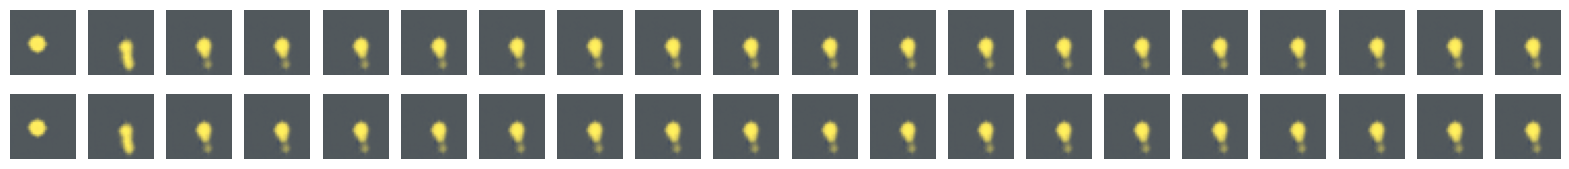

MSE: 0.00001
Pred MSE: 0.01613
Epoch: [69][50/313]	Time 0.107	ELBO 176339.0938	 MSE: 0.4946	 MSM: -6.1460e+01
Epoch: [69][100/313]	Time 0.112	ELBO 176632.3750	 MSE: 0.2132	 MSM: -5.7769e+01
Epoch: [69][150/313]	Time 0.105	ELBO 176393.1094	 MSE: 0.4479	 MSM: -5.8669e+01
Epoch: [69][200/313]	Time 0.109	ELBO 176477.0781	 MSE: 0.3600	 MSM: -6.0188e+01
Epoch: [69][250/313]	Time 0.104	ELBO 176226.9062	 MSE: 0.6047	 MSM: -5.8837e+01
Epoch: [69][300/313]	Time 0.120	ELBO 176092.3125	 MSE: 0.7311	 MSM: -5.8669e+01
MSE: 0.00001
Pred MSE: 0.01506
Epoch: [70][50/313]	Time 0.110	ELBO 174430.3594	 MSE: 2.3982	 MSM: -5.7252e+01
Epoch: [70][100/313]	Time 0.114	ELBO 175969.5156	 MSE: 0.8505	 MSM: -6.0760e+01
Epoch: [70][150/313]	Time 0.100	ELBO 176247.8438	 MSE: 0.5777	 MSM: -6.0757e+01
Epoch: [70][200/313]	Time 0.113	ELBO 176052.8906	 MSE: 0.7810	 MSM: -5.8581e+01
Epoch: [70][250/313]	Time 0.099	ELBO 175883.0312	 MSE: 0.9427	 MSM: -5.7386e+01
Epoch: [70][300/313]	Time 0.109	ELBO 175045.5000	 MSE: 1.783

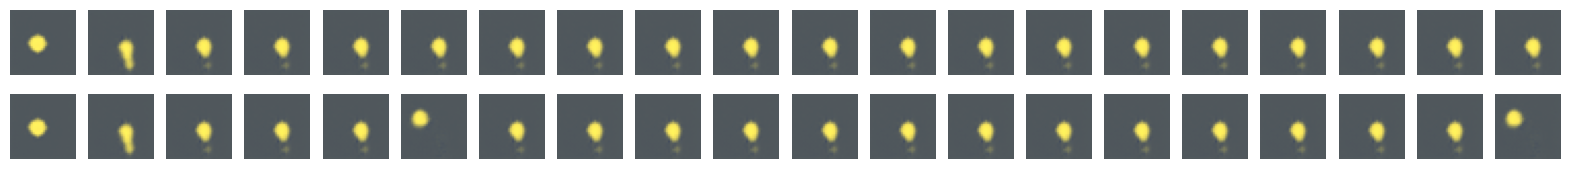

MSE: 0.00002
Pred MSE: 0.01574
Epoch: [71][50/313]	Time 0.110	ELBO 176503.3125	 MSE: 0.3338	 MSM: -5.7205e+01
Epoch: [71][100/313]	Time 0.109	ELBO 176472.3594	 MSE: 0.3700	 MSM: -5.8831e+01
Epoch: [71][150/313]	Time 0.108	ELBO 176603.7031	 MSE: 0.2335	 MSM: -6.1370e+01
Epoch: [71][200/313]	Time 0.105	ELBO 176521.0781	 MSE: 0.3208	 MSM: -5.8782e+01
Epoch: [71][250/313]	Time 0.109	ELBO 176284.7812	 MSE: 0.5431	 MSM: -5.7006e+01
Epoch: [71][300/313]	Time 0.110	ELBO 176220.3281	 MSE: 0.6024	 MSM: -6.0063e+01
MSE: 0.00001
Pred MSE: 0.01561
Epoch: [72][50/313]	Time 0.102	ELBO 176587.3438	 MSE: 0.2442	 MSM: -6.0666e+01
Epoch: [72][100/313]	Time 0.110	ELBO 175918.2812	 MSE: 0.9016	 MSM: -6.1211e+01
Epoch: [72][150/313]	Time 0.108	ELBO 176399.6875	 MSE: 0.4215	 MSM: -5.8613e+01
Epoch: [72][200/313]	Time 0.112	ELBO 176325.4062	 MSE: 0.4929	 MSM: -5.9614e+01
Epoch: [72][250/313]	Time 0.109	ELBO 175577.6406	 MSE: 1.2404	 MSM: -6.1006e+01
Epoch: [72][300/313]	Time 0.108	ELBO 176242.7656	 MSE: 0.589

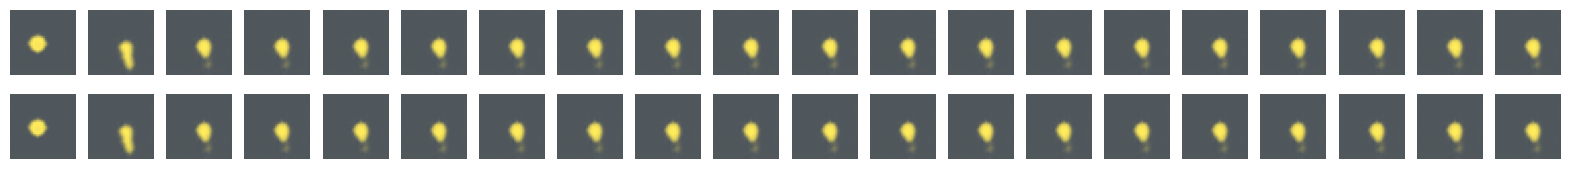

MSE: 0.00001
Pred MSE: 0.01499
Epoch: [73][50/313]	Time 0.099	ELBO 176372.5000	 MSE: 0.4606	 MSM: -5.9907e+01
Epoch: [73][100/313]	Time 0.102	ELBO 176319.7188	 MSE: 0.5121	 MSM: -5.9235e+01
Epoch: [73][150/313]	Time 0.108	ELBO 176497.8906	 MSE: 0.3409	 MSM: -5.8209e+01
Epoch: [73][200/313]	Time 0.104	ELBO 176662.6719	 MSE: 0.1825	 MSM: -5.8605e+01
Epoch: [73][250/313]	Time 0.112	ELBO 176562.8281	 MSE: 0.2832	 MSM: -5.8474e+01
Epoch: [73][300/313]	Time 0.106	ELBO 176572.0781	 MSE: 0.2769	 MSM: -5.7632e+01
MSE: 0.00000
Pred MSE: 0.01470
Epoch: [74][50/313]	Time 0.101	ELBO 176424.5625	 MSE: 0.4193	 MSM: -5.7092e+01
Epoch: [74][100/313]	Time 0.108	ELBO 176367.4844	 MSE: 0.4795	 MSM: -5.6964e+01
Epoch: [74][150/313]	Time 0.112	ELBO 175835.7969	 MSE: 0.9961	 MSM: -6.0188e+01
Epoch: [74][200/313]	Time 0.108	ELBO 176279.4062	 MSE: 0.5529	 MSM: -5.9689e+01
Epoch: [74][250/313]	Time 0.109	ELBO 175780.5469	 MSE: 1.0474	 MSM: -5.9801e+01
Epoch: [74][300/313]	Time 0.110	ELBO 176079.8125	 MSE: 0.744

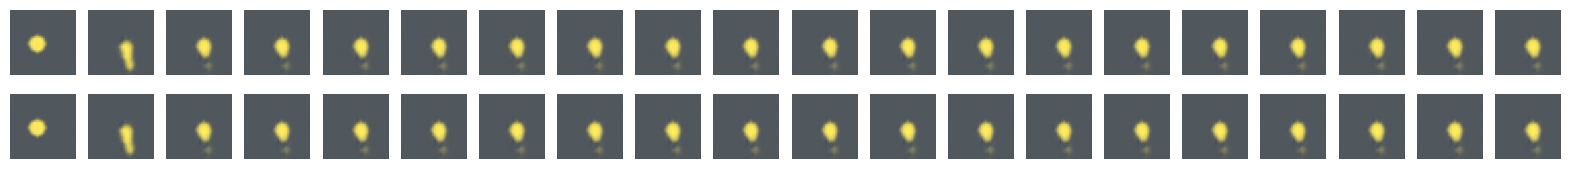

MSE: 0.00001
Pred MSE: 0.01496
Epoch: [75][50/313]	Time 0.105	ELBO 176549.9844	 MSE: 0.2815	 MSM: -6.0228e+01
Epoch: [75][100/313]	Time 0.109	ELBO 175843.7344	 MSE: 0.9896	 MSM: -5.9286e+01
Epoch: [75][150/313]	Time 0.103	ELBO 175845.2500	 MSE: 0.9756	 MSM: -5.8425e+01
Epoch: [75][200/313]	Time 0.103	ELBO 175784.0469	 MSE: 1.0497	 MSM: -5.7322e+01
Epoch: [75][250/313]	Time 0.103	ELBO 176069.5781	 MSE: 0.7604	 MSM: -5.9422e+01
Epoch: [75][300/313]	Time 0.103	ELBO 176189.5000	 MSE: 0.6350	 MSM: -6.0411e+01
MSE: 0.00001
Pred MSE: 0.01444
Epoch: [76][50/313]	Time 0.108	ELBO 175913.5625	 MSE: 0.9226	 MSM: -5.8983e+01
Epoch: [76][100/313]	Time 0.103	ELBO 175188.8438	 MSE: 1.6395	 MSM: -5.9852e+01
Epoch: [76][150/313]	Time 0.110	ELBO 176361.1094	 MSE: 0.4625	 MSM: -6.1327e+01
Epoch: [76][200/313]	Time 0.104	ELBO 176570.2031	 MSE: 0.2667	 MSM: -5.9141e+01
Epoch: [76][250/313]	Time 0.103	ELBO 176291.5938	 MSE: 0.5521	 MSM: -5.9390e+01
Epoch: [76][300/313]	Time 0.103	ELBO 175835.0312	 MSE: 1.001

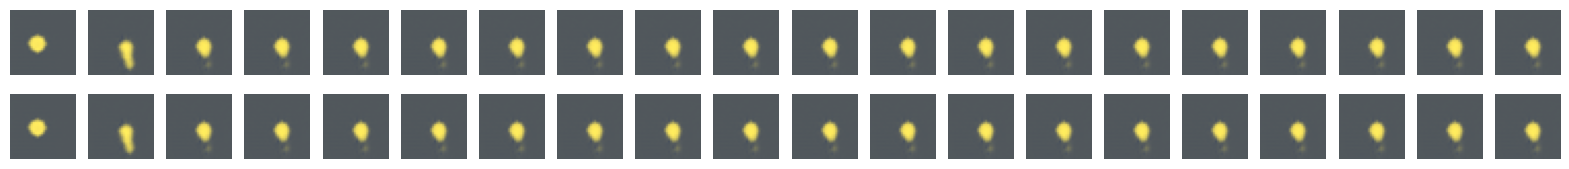

MSE: 0.00001
Pred MSE: 0.01514
Epoch: [77][50/313]	Time 0.098	ELBO 176181.0938	 MSE: 0.6533	 MSM: -5.6855e+01
Epoch: [77][100/313]	Time 0.097	ELBO 176481.9062	 MSE: 0.3595	 MSM: -5.6271e+01
Epoch: [77][150/313]	Time 0.100	ELBO 176451.1094	 MSE: 0.3920	 MSM: -5.6971e+01
Epoch: [77][200/313]	Time 0.100	ELBO 175961.2656	 MSE: 0.8652	 MSM: -6.0758e+01
Epoch: [77][250/313]	Time 0.098	ELBO 176421.1250	 MSE: 0.4069	 MSM: -5.9507e+01
Epoch: [77][300/313]	Time 0.099	ELBO 174987.4688	 MSE: 1.8478	 MSM: -6.0221e+01
MSE: 0.00001
Pred MSE: 0.01553
Epoch: [78][50/313]	Time 0.099	ELBO 176470.8906	 MSE: 0.3646	 MSM: -5.8308e+01
Epoch: [78][100/313]	Time 0.098	ELBO 176689.4375	 MSE: 0.1589	 MSM: -5.7299e+01
Epoch: [78][150/313]	Time 0.099	ELBO 176606.4062	 MSE: 0.2436	 MSM: -5.7348e+01
Epoch: [78][200/313]	Time 0.098	ELBO 176566.6250	 MSE: 0.2798	 MSM: -6.0836e+01
Epoch: [78][250/313]	Time 0.109	ELBO 174493.7031	 MSE: 2.3482	 MSM: -5.8328e+01
Epoch: [78][300/313]	Time 0.109	ELBO 175493.4688	 MSE: 1.326

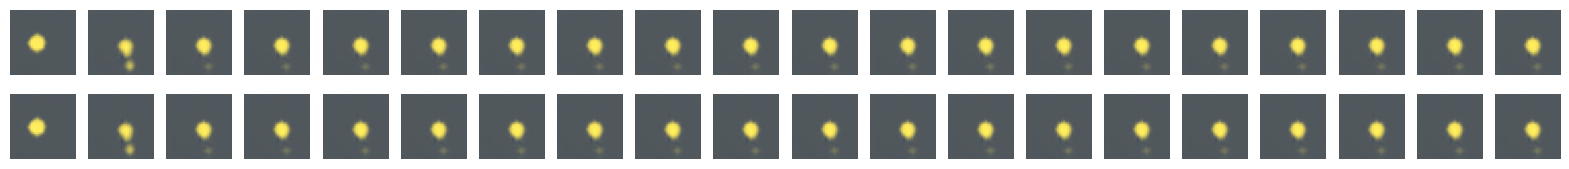

MSE: 0.00011
Pred MSE: 0.01486
Epoch: [79][50/313]	Time 0.109	ELBO 172630.2500	 MSE: 4.1808	 MSM: -6.1089e+01
Epoch: [79][100/313]	Time 0.118	ELBO 175863.1719	 MSE: 0.9430	 MSM: -6.0273e+01
Epoch: [79][150/313]	Time 0.103	ELBO 175886.1094	 MSE: 0.9354	 MSM: -5.8769e+01
Epoch: [79][200/313]	Time 0.107	ELBO 175975.4531	 MSE: 0.8405	 MSM: -6.1844e+01
Epoch: [79][250/313]	Time 0.102	ELBO 176093.0469	 MSE: 0.7301	 MSM: -5.9843e+01
Epoch: [79][300/313]	Time 0.109	ELBO 176236.7969	 MSE: 0.5866	 MSM: -6.1502e+01
MSE: 0.00001
Pred MSE: 0.01527
Epoch: [80][50/313]	Time 0.104	ELBO 176283.3281	 MSE: 0.5465	 MSM: -6.2166e+01
Epoch: [80][100/313]	Time 0.110	ELBO 176427.5156	 MSE: 0.4094	 MSM: -5.7284e+01
Epoch: [80][150/313]	Time 0.104	ELBO 176501.6094	 MSE: 0.3404	 MSM: -5.8265e+01
Epoch: [80][200/313]	Time 0.099	ELBO 176532.7031	 MSE: 0.3008	 MSM: -6.0465e+01
Epoch: [80][250/313]	Time 0.098	ELBO 176656.9219	 MSE: 0.1888	 MSM: -5.8525e+01
Epoch: [80][300/313]	Time 0.102	ELBO 176435.6875	 MSE: 0.404

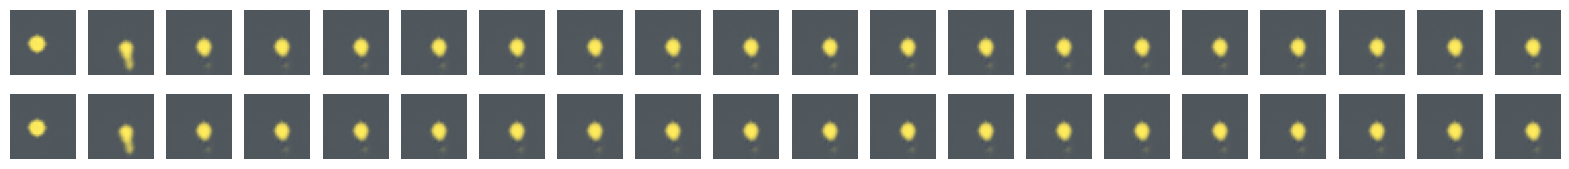

MSE: 0.00000
Pred MSE: 0.01479
Epoch: [81][50/313]	Time 0.108	ELBO 176453.6406	 MSE: 0.3818	 MSM: -5.9618e+01
Epoch: [81][100/313]	Time 0.109	ELBO 176243.8281	 MSE: 0.5951	 MSM: -5.7918e+01
Epoch: [81][150/313]	Time 0.110	ELBO 176521.8438	 MSE: 0.3189	 MSM: -5.7650e+01
Epoch: [81][200/313]	Time 0.108	ELBO 176238.9375	 MSE: 0.6006	 MSM: -6.1115e+01
Epoch: [81][250/313]	Time 0.109	ELBO 176633.0469	 MSE: 0.2077	 MSM: -5.9456e+01
Epoch: [81][300/313]	Time 0.109	ELBO 176474.7344	 MSE: 0.3647	 MSM: -6.0665e+01
MSE: 0.00001
Pred MSE: 0.01412
Epoch: [82][50/313]	Time 0.106	ELBO 176525.9531	 MSE: 0.3118	 MSM: -5.7011e+01
Epoch: [82][100/313]	Time 0.111	ELBO 176303.9219	 MSE: 0.5318	 MSM: -6.0151e+01
Epoch: [82][150/313]	Time 0.109	ELBO 176615.9375	 MSE: 0.2252	 MSM: -5.8945e+01
Epoch: [82][200/313]	Time 0.101	ELBO 176461.7344	 MSE: 0.3738	 MSM: -6.0253e+01
Epoch: [82][250/313]	Time 0.109	ELBO 176363.4531	 MSE: 0.4737	 MSM: -5.8579e+01
Epoch: [82][300/313]	Time 0.106	ELBO 176287.0625	 MSE: 0.543

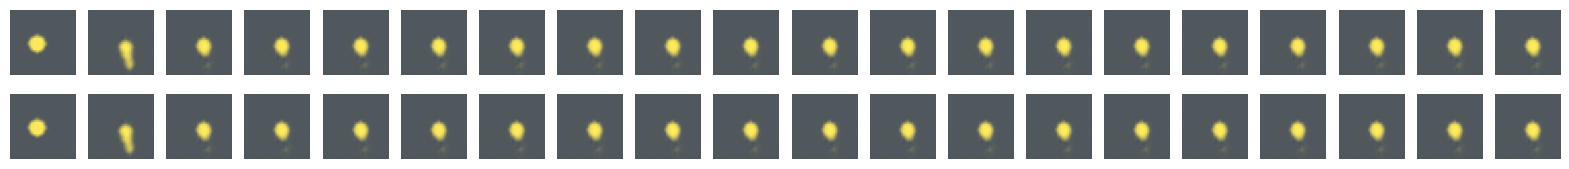

MSE: 0.00001
Pred MSE: 0.01461
Epoch: [83][50/313]	Time 0.101	ELBO 176376.0312	 MSE: 0.4482	 MSM: -6.1520e+01
Epoch: [83][100/313]	Time 0.100	ELBO 176619.4844	 MSE: 0.2192	 MSM: -5.7710e+01
Epoch: [83][150/313]	Time 0.104	ELBO 176498.6250	 MSE: 0.3385	 MSM: -6.0898e+01
Epoch: [83][200/313]	Time 0.106	ELBO 176535.1562	 MSE: 0.3099	 MSM: -5.6947e+01
Epoch: [83][250/313]	Time 0.110	ELBO 176208.4375	 MSE: 0.6389	 MSM: -5.8581e+01
Epoch: [83][300/313]	Time 0.104	ELBO 176515.3438	 MSE: 0.3220	 MSM: -5.7768e+01
MSE: 0.00000
Pred MSE: 0.01467
Epoch: [84][50/313]	Time 0.103	ELBO 176256.8438	 MSE: 0.5901	 MSM: -5.9574e+01
Epoch: [84][100/313]	Time 0.105	ELBO 176583.5938	 MSE: 0.2545	 MSM: -5.8714e+01
Epoch: [84][150/313]	Time 0.107	ELBO 174984.3438	 MSE: 1.8482	 MSM: -5.9482e+01
Epoch: [84][200/313]	Time 0.109	ELBO 176492.7969	 MSE: 0.3329	 MSM: -5.9911e+01
Epoch: [84][250/313]	Time 0.110	ELBO 176687.9844	 MSE: 0.1432	 MSM: -5.9654e+01
Epoch: [84][300/313]	Time 0.107	ELBO 176580.2344	 MSE: 0.260

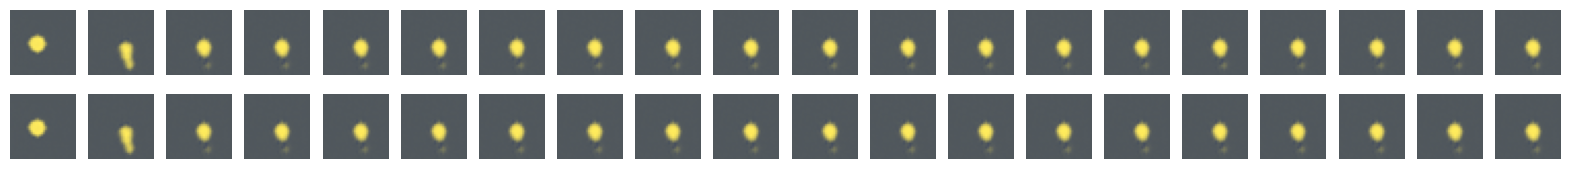

MSE: 0.00000
Pred MSE: 0.01446
Epoch: [85][50/313]	Time 0.103	ELBO 176610.9219	 MSE: 0.2313	 MSM: -6.0303e+01
Epoch: [85][100/313]	Time 0.105	ELBO 176590.2188	 MSE: 0.2565	 MSM: -5.9355e+01
Epoch: [85][150/313]	Time 0.109	ELBO 176162.3594	 MSE: 0.6775	 MSM: -5.6951e+01
Epoch: [85][200/313]	Time 0.103	ELBO 175675.1406	 MSE: 1.1603	 MSM: -5.8234e+01
Epoch: [85][250/313]	Time 0.110	ELBO 176628.9062	 MSE: 0.2071	 MSM: -5.9797e+01
Epoch: [85][300/313]	Time 0.103	ELBO 176616.3750	 MSE: 0.2236	 MSM: -5.9878e+01
MSE: 0.00000
Pred MSE: 0.01437
Epoch: [86][50/313]	Time 0.109	ELBO 176666.9844	 MSE: 0.1792	 MSM: -5.8311e+01
Epoch: [86][100/313]	Time 0.106	ELBO 175608.1875	 MSE: 1.2364	 MSM: -5.6498e+01
Epoch: [86][150/313]	Time 0.101	ELBO 176175.1562	 MSE: 0.6696	 MSM: -5.6749e+01
Epoch: [86][200/313]	Time 0.107	ELBO 176707.8750	 MSE: 0.1232	 MSM: -6.1284e+01
Epoch: [86][250/313]	Time 0.104	ELBO 176133.0625	 MSE: 0.7112	 MSM: -5.8995e+01
Epoch: [86][300/313]	Time 0.104	ELBO 176765.9375	 MSE: 0.079

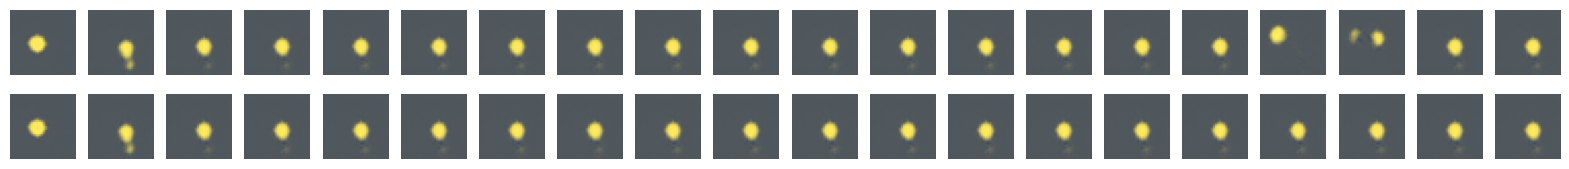

MSE: 0.00001
Pred MSE: 0.01461
Epoch: [87][50/313]	Time 0.109	ELBO 176604.2344	 MSE: 0.2427	 MSM: -5.8950e+01
Epoch: [87][100/313]	Time 0.102	ELBO 176726.4531	 MSE: 0.1325	 MSM: -5.5377e+01
Epoch: [87][150/313]	Time 0.109	ELBO 176651.0625	 MSE: 0.1977	 MSM: -5.9702e+01
Epoch: [87][200/313]	Time 0.108	ELBO 176030.7344	 MSE: 0.8020	 MSM: -5.8831e+01
Epoch: [87][250/313]	Time 0.107	ELBO 176366.7188	 MSE: 0.4640	 MSM: -6.1343e+01
Epoch: [87][300/313]	Time 0.102	ELBO 176694.3438	 MSE: 0.1463	 MSM: -5.9471e+01
MSE: 0.00001
Pred MSE: 0.01481
Epoch: [88][50/313]	Time 0.103	ELBO 176678.0156	 MSE: 0.1630	 MSM: -5.8912e+01
Epoch: [88][100/313]	Time 0.104	ELBO 176638.7969	 MSE: 0.2113	 MSM: -5.9071e+01
Epoch: [88][150/313]	Time 0.107	ELBO 176708.6406	 MSE: 0.1424	 MSM: -5.8182e+01
Epoch: [88][200/313]	Time 0.109	ELBO 176459.9375	 MSE: 0.3850	 MSM: -5.8991e+01
Epoch: [88][250/313]	Time 0.102	ELBO 176647.4844	 MSE: 0.2021	 MSM: -5.7948e+01
Epoch: [88][300/313]	Time 0.110	ELBO 176629.1094	 MSE: 0.224

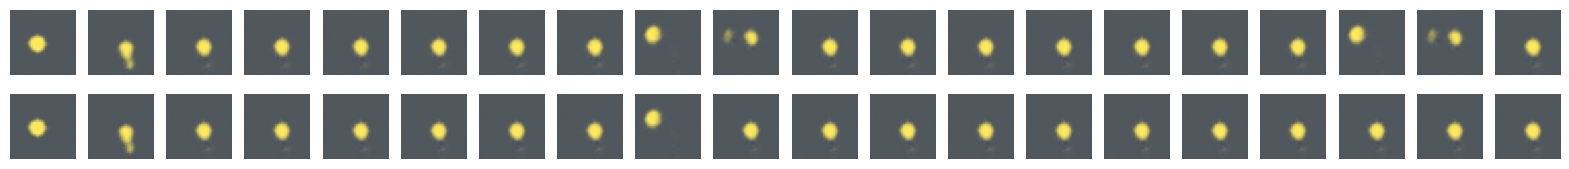

MSE: 0.00000
Pred MSE: 0.01445
Epoch: [89][50/313]	Time 0.102	ELBO 176701.7188	 MSE: 0.1526	 MSM: -5.7434e+01
Epoch: [89][100/313]	Time 0.108	ELBO 176444.0781	 MSE: 0.3935	 MSM: -5.9731e+01
Epoch: [89][150/313]	Time 0.104	ELBO 176168.8906	 MSE: 0.6650	 MSM: -5.9429e+01
Epoch: [89][200/313]	Time 0.102	ELBO 176264.2812	 MSE: 0.5610	 MSM: -6.0113e+01
Epoch: [89][250/313]	Time 0.111	ELBO 176349.7188	 MSE: 0.4868	 MSM: -5.6923e+01
Epoch: [89][300/313]	Time 0.108	ELBO 176261.7812	 MSE: 0.5748	 MSM: -5.9164e+01
MSE: 0.00001
Pred MSE: 0.01561
Epoch: [90][50/313]	Time 0.106	ELBO 176350.4844	 MSE: 0.4817	 MSM: -5.8793e+01
Epoch: [90][100/313]	Time 0.109	ELBO 176629.6250	 MSE: 0.2117	 MSM: -5.8973e+01
Epoch: [90][150/313]	Time 0.108	ELBO 176720.8906	 MSE: 0.1245	 MSM: -6.0726e+01
Epoch: [90][200/313]	Time 0.103	ELBO 176459.9531	 MSE: 0.3927	 MSM: -5.9071e+01
Epoch: [90][250/313]	Time 0.111	ELBO 176601.4688	 MSE: 0.2446	 MSM: -6.0826e+01
Epoch: [90][300/313]	Time 0.108	ELBO 176046.4375	 MSE: 0.788

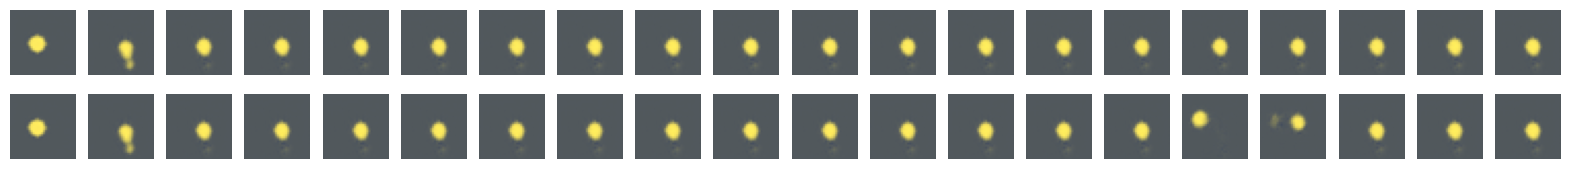

MSE: 0.00001
Pred MSE: 0.01502
Epoch: [91][50/313]	Time 0.111	ELBO 176514.3281	 MSE: 0.3319	 MSM: -5.7003e+01
Epoch: [91][100/313]	Time 0.105	ELBO 176490.5781	 MSE: 0.3541	 MSM: -6.0721e+01
Epoch: [91][150/313]	Time 0.105	ELBO 176303.6250	 MSE: 0.5426	 MSM: -5.9971e+01
Epoch: [91][200/313]	Time 0.098	ELBO 176680.3438	 MSE: 0.1669	 MSM: -5.8574e+01
Epoch: [91][250/313]	Time 0.101	ELBO 176696.5000	 MSE: 0.1579	 MSM: -5.8802e+01
Epoch: [91][300/313]	Time 0.110	ELBO 176672.5000	 MSE: 0.1788	 MSM: -6.1556e+01
MSE: 0.00000
Pred MSE: 0.01464
Epoch: [92][50/313]	Time 0.105	ELBO 176467.9219	 MSE: 0.3744	 MSM: -5.9031e+01
Epoch: [92][100/313]	Time 0.099	ELBO 176577.7344	 MSE: 0.2593	 MSM: -6.0294e+01
Epoch: [92][150/313]	Time 0.099	ELBO 176655.6719	 MSE: 0.1837	 MSM: -6.1410e+01
Epoch: [92][200/313]	Time 0.100	ELBO 176722.8594	 MSE: 0.1254	 MSM: -5.9945e+01
Epoch: [92][250/313]	Time 0.100	ELBO 176739.5625	 MSE: 0.1138	 MSM: -6.1017e+01
Epoch: [92][300/313]	Time 0.100	ELBO 176544.4531	 MSE: 0.303

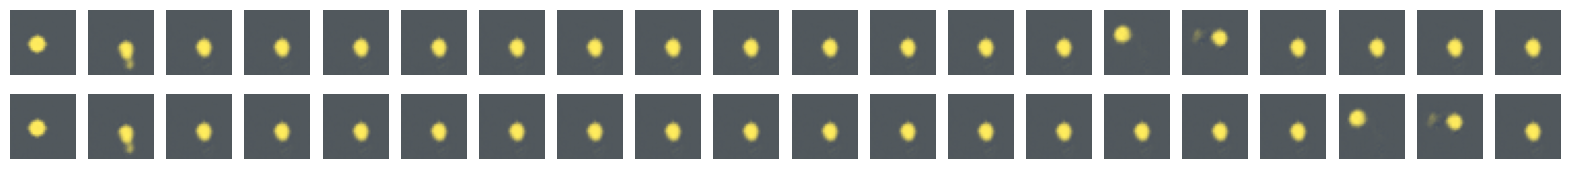

MSE: 0.00002
Pred MSE: 0.01518
Epoch: [93][50/313]	Time 0.105	ELBO 176600.3281	 MSE: 0.2339	 MSM: -5.8969e+01
Epoch: [93][100/313]	Time 0.105	ELBO 176714.9375	 MSE: 0.1290	 MSM: -5.7762e+01
Epoch: [93][150/313]	Time 0.104	ELBO 176012.0000	 MSE: 0.8247	 MSM: -5.7016e+01
Epoch: [93][200/313]	Time 0.110	ELBO 175729.5625	 MSE: 1.1025	 MSM: -5.8825e+01
Epoch: [93][250/313]	Time 0.110	ELBO 176493.0625	 MSE: 0.3456	 MSM: -5.7616e+01
Epoch: [93][300/313]	Time 0.101	ELBO 176690.8594	 MSE: 0.1469	 MSM: -6.1121e+01
MSE: 0.00000
Pred MSE: 0.01501
Epoch: [94][50/313]	Time 0.105	ELBO 176441.4531	 MSE: 0.4093	 MSM: -5.9462e+01
Epoch: [94][100/313]	Time 0.112	ELBO 175808.5000	 MSE: 1.0342	 MSM: -5.6479e+01
Epoch: [94][150/313]	Time 0.108	ELBO 175742.9688	 MSE: 1.0876	 MSM: -6.0179e+01
Epoch: [94][200/313]	Time 0.107	ELBO 176571.7031	 MSE: 0.2653	 MSM: -5.8413e+01
Epoch: [94][250/313]	Time 0.110	ELBO 176743.0312	 MSE: 0.1083	 MSM: -5.7743e+01
Epoch: [94][300/313]	Time 0.103	ELBO 176438.5000	 MSE: 0.405

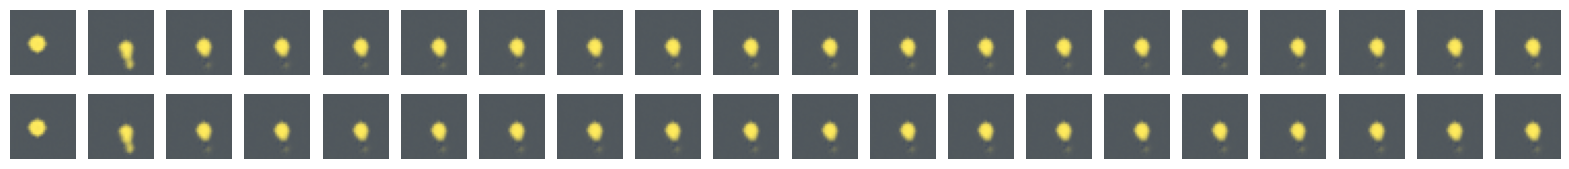

MSE: 0.00001
Pred MSE: 0.01485
Epoch: [95][50/313]	Time 0.101	ELBO 176243.2188	 MSE: 0.5982	 MSM: -6.1317e+01
Epoch: [95][100/313]	Time 0.109	ELBO 176483.4219	 MSE: 0.3499	 MSM: -6.4146e+01
Epoch: [95][150/313]	Time 0.112	ELBO 176646.7969	 MSE: 0.1927	 MSM: -6.0720e+01
Epoch: [95][200/313]	Time 0.109	ELBO 176206.3594	 MSE: 0.6395	 MSM: -5.8440e+01
Epoch: [95][250/313]	Time 0.108	ELBO 176592.8125	 MSE: 0.2482	 MSM: -5.9069e+01
Epoch: [95][300/313]	Time 0.113	ELBO 176438.6562	 MSE: 0.4091	 MSM: -5.9491e+01
MSE: 0.00000
Pred MSE: 0.01495
Epoch: [96][50/313]	Time 0.104	ELBO 176681.3281	 MSE: 0.1689	 MSM: -5.7986e+01
Epoch: [96][100/313]	Time 0.110	ELBO 176752.1875	 MSE: 0.1031	 MSM: -5.8063e+01
Epoch: [96][150/313]	Time 0.109	ELBO 176761.5156	 MSE: 0.0881	 MSM: -6.1858e+01
Epoch: [96][200/313]	Time 0.108	ELBO 176688.2188	 MSE: 0.1692	 MSM: -5.6811e+01
Epoch: [96][250/313]	Time 0.099	ELBO 176645.4688	 MSE: 0.2058	 MSM: -6.0093e+01
Epoch: [96][300/313]	Time 0.098	ELBO 176535.1875	 MSE: 0.306

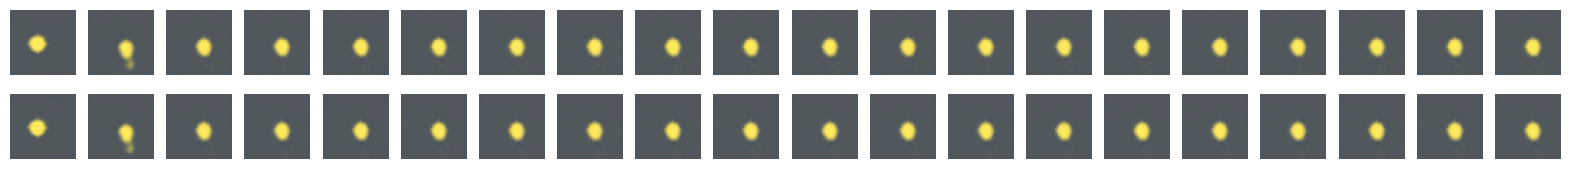

MSE: 0.00000
Pred MSE: 0.01512
Epoch: [97][50/313]	Time 0.102	ELBO 176378.4062	 MSE: 0.4596	 MSM: -5.8327e+01
Epoch: [97][100/313]	Time 0.107	ELBO 175624.5781	 MSE: 1.2133	 MSM: -6.0376e+01
Epoch: [97][150/313]	Time 0.102	ELBO 176600.6562	 MSE: 0.2432	 MSM: -5.9436e+01
Epoch: [97][200/313]	Time 0.104	ELBO 176696.0000	 MSE: 0.1542	 MSM: -5.7325e+01
Epoch: [97][250/313]	Time 0.108	ELBO 175881.0781	 MSE: 0.9585	 MSM: -6.0254e+01
Epoch: [97][300/313]	Time 0.110	ELBO 176595.0156	 MSE: 0.2418	 MSM: -6.0841e+01
MSE: 0.00001
Pred MSE: 0.01489
Epoch: [98][50/313]	Time 0.104	ELBO 176466.6250	 MSE: 0.3713	 MSM: -5.9280e+01
Epoch: [98][100/313]	Time 0.106	ELBO 176101.1719	 MSE: 0.7354	 MSM: -6.0230e+01
Epoch: [98][150/313]	Time 0.114	ELBO 176672.5938	 MSE: 0.1654	 MSM: -6.1161e+01
Epoch: [98][200/313]	Time 0.104	ELBO 176452.4844	 MSE: 0.3840	 MSM: -6.2022e+01
Epoch: [98][250/313]	Time 0.108	ELBO 176602.2656	 MSE: 0.2320	 MSM: -5.8884e+01
Epoch: [98][300/313]	Time 0.101	ELBO 175883.8281	 MSE: 0.945

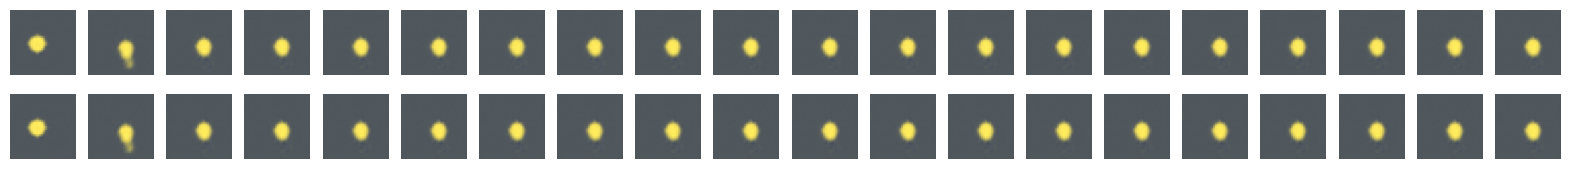

MSE: 0.00002
Pred MSE: 0.01539
Epoch: [99][50/313]	Time 0.107	ELBO 175692.2656	 MSE: 1.1372	 MSM: -5.9918e+01
Epoch: [99][100/313]	Time 0.107	ELBO 176640.1719	 MSE: 0.1985	 MSM: -5.8260e+01
Epoch: [99][150/313]	Time 0.115	ELBO 176613.2344	 MSE: 0.2269	 MSM: -6.0596e+01
Epoch: [99][200/313]	Time 0.109	ELBO 176585.7031	 MSE: 0.2584	 MSM: -6.0043e+01
Epoch: [99][250/313]	Time 0.110	ELBO 176664.4062	 MSE: 0.1817	 MSM: -5.7412e+01
Epoch: [99][300/313]	Time 0.104	ELBO 176610.5469	 MSE: 0.2367	 MSM: -5.9855e+01
MSE: 0.00001
Pred MSE: 0.01410


In [15]:
elbo_losses, test_mse, pred_mse_elbo = train(model, optimizer, num_states, dim_latent, T)

In [17]:
PATH = 'snlds_video_20_elbo.pth'
torch.save(model.state_dict(), PATH)
# model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
# model.load_state_dict(torch.load(PATH))

Text(0, 0.5, 'Training Loss')

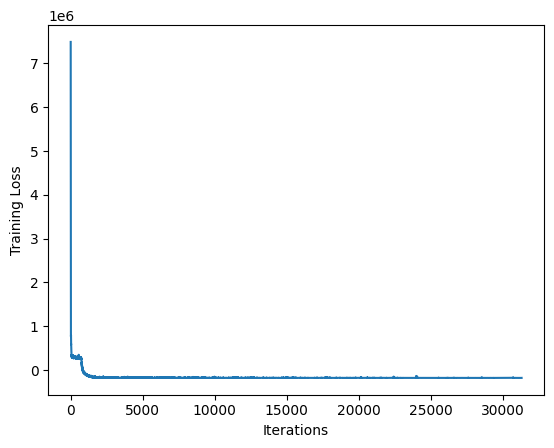

In [14]:
plt.plot(elbo_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

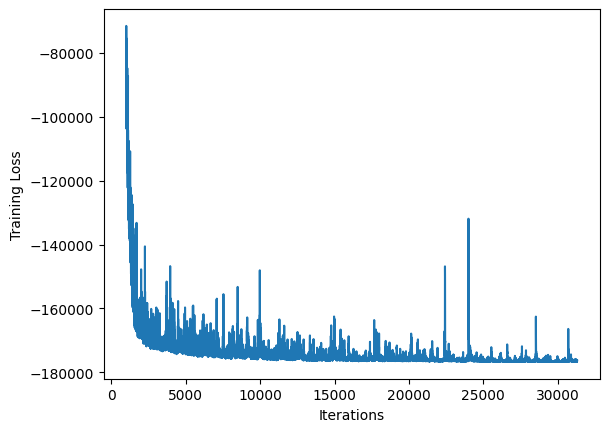

In [17]:
plt.plot(np.arange(1000,len(elbo_losses)),elbo_losses[1000:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

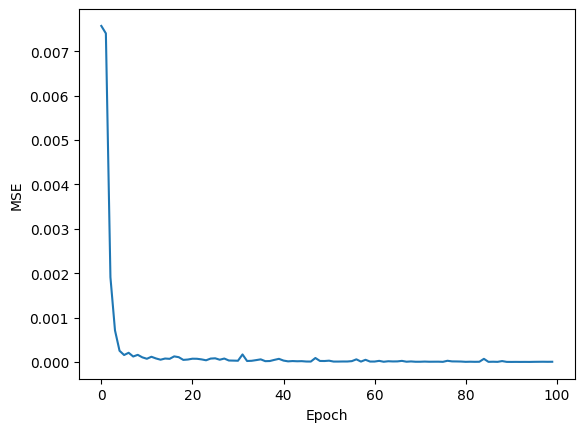

In [18]:
plt.plot(test_mse)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

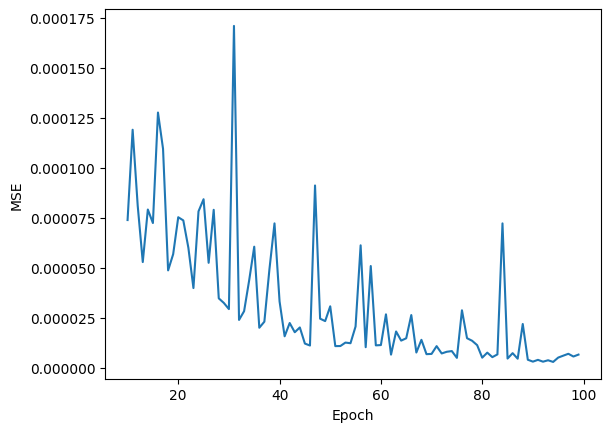

In [19]:
plt.plot(np.arange(10,len(test_mse)),test_mse[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

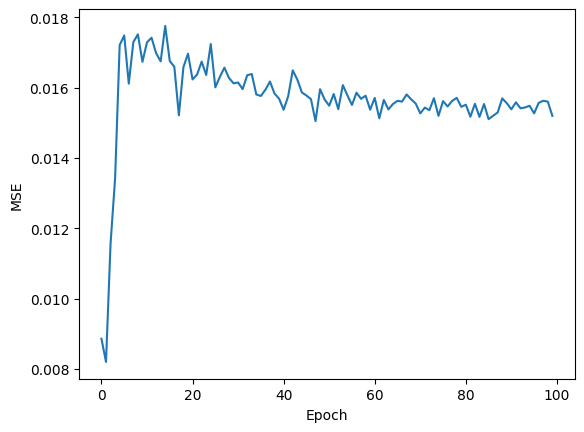

In [20]:
plt.plot(pred_mse_elbo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

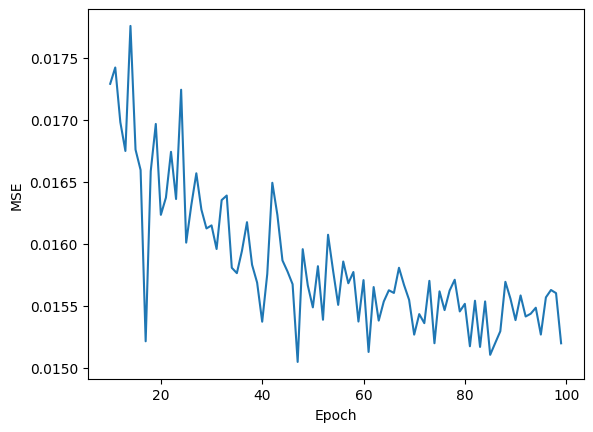

In [21]:
plt.plot(np.arange(10,len(pred_mse_elbo)),pred_mse_elbo[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [26]:
# Training time: 67min
print(f"Last ELBO Loss: {elbo_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_elbo[-1]:.6f}")

Last ELBO Loss: -176346.1
Last Test MSE: 0.000007
Last Pred MSE: 0.015199


In [27]:
print(f"Best ELBO Loss: {min(elbo_losses):.1f}")
print(f"Best Test MSE: {min(test_mse):.6f}")
print(f"Best Pred MSE: {min(pred_mse_elbo):.6f}")

Best ELBO Loss: -176753.2
Best Test MSE: 0.000003
Best Pred MSE: 0.008197


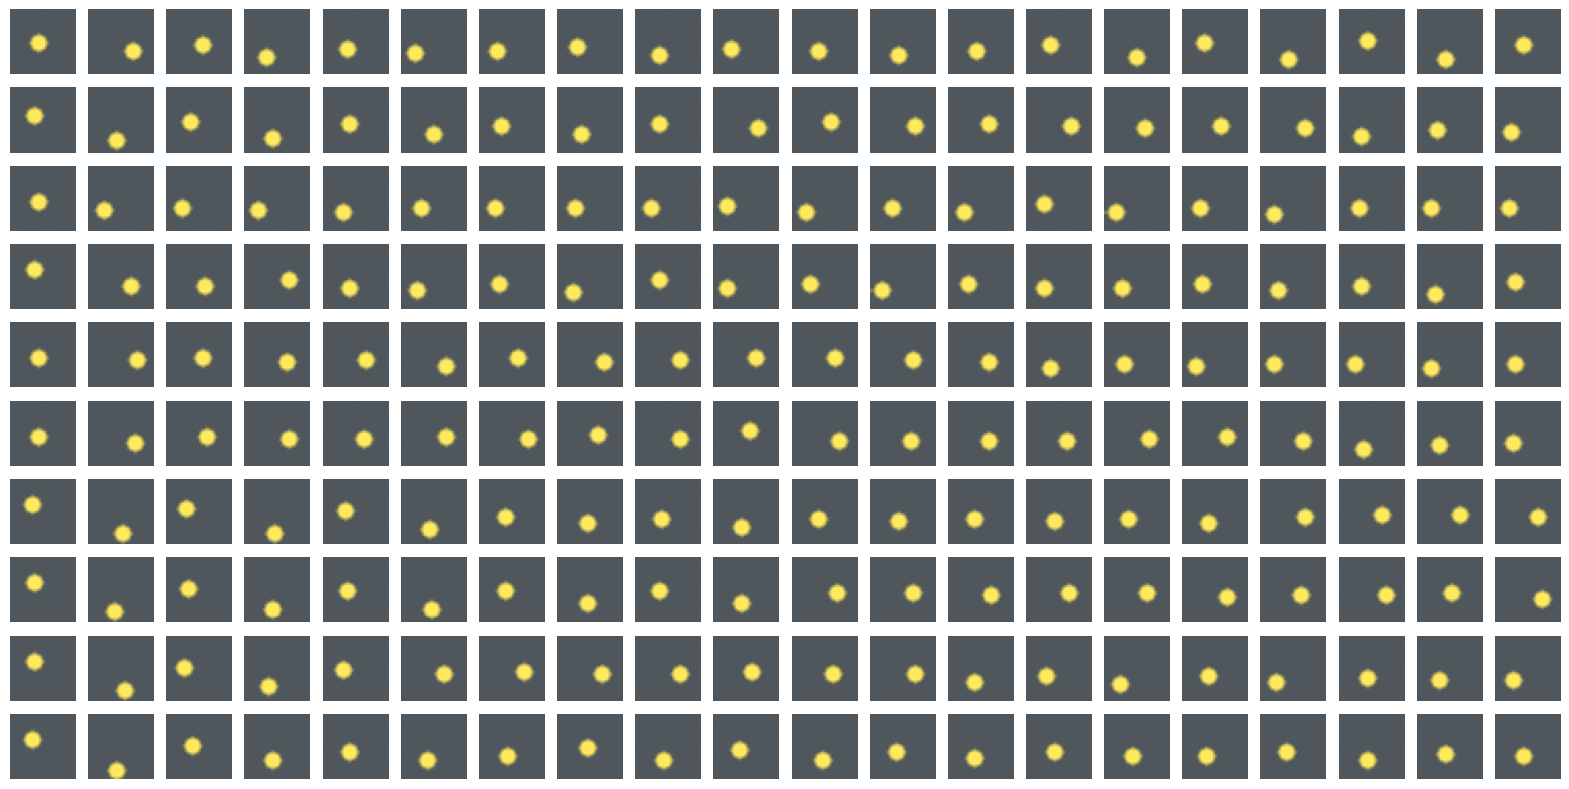

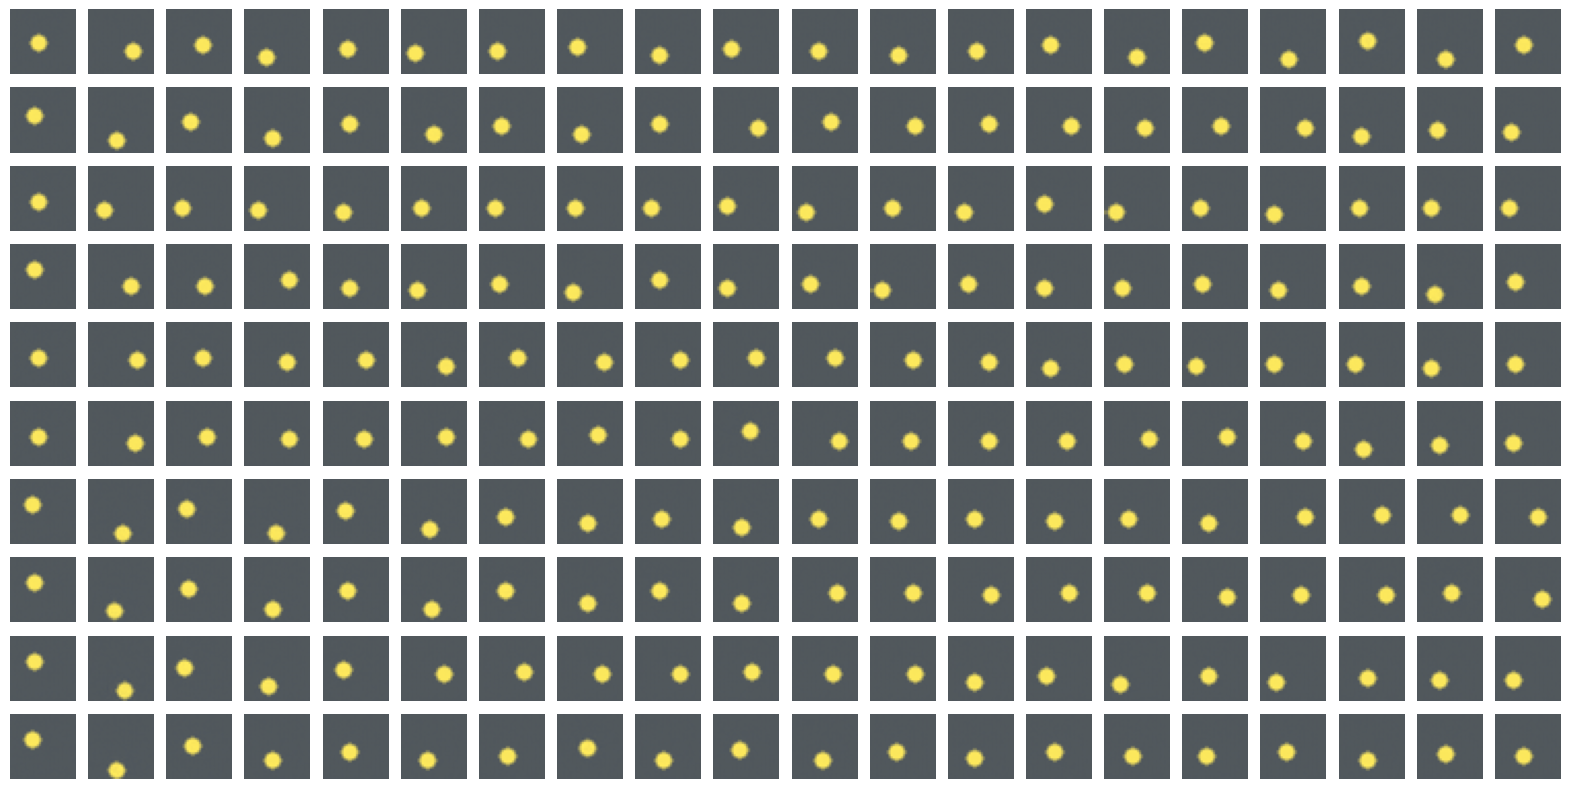

In [28]:
# Reconstructions

n_samples = 10
t = 20
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    x = x + 0.5
    (B,T,C,H,W) = x.shape
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = torch.clamp(recon_x,max=1.0)
    recon_x = recon_x.cpu().reshape(B,T,C,H,W).numpy()

imshow_grid((x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)
imshow_grid((recon_x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)

In [30]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.000005
t=1 MSE per pixel:0.000020
t=2 MSE per pixel:0.000018
t=3 MSE per pixel:0.000019
t=4 MSE per pixel:0.000004
t=5 MSE per pixel:0.000005
t=6 MSE per pixel:0.000004
t=7 MSE per pixel:0.000005
t=8 MSE per pixel:0.000004
t=9 MSE per pixel:0.000005
t=10 MSE per pixel:0.000007
t=11 MSE per pixel:0.000007
t=12 MSE per pixel:0.000004
t=13 MSE per pixel:0.000004
t=14 MSE per pixel:0.000005
t=15 MSE per pixel:0.000004
t=16 MSE per pixel:0.000004
t=17 MSE per pixel:0.000004
t=18 MSE per pixel:0.000006
t=19 MSE per pixel:0.000004


Text(0, 0.5, 'MSE per Pixel')

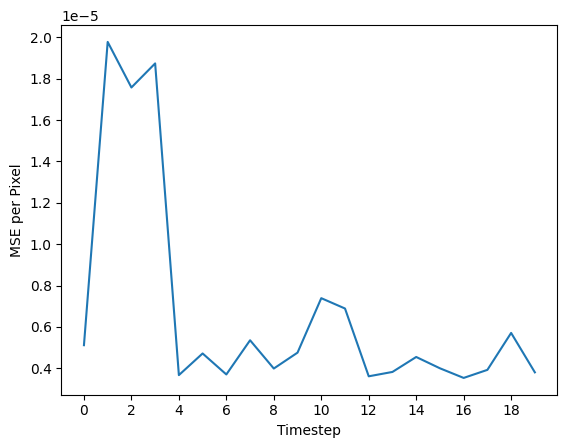

In [31]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,20,2))
plt.ylabel('MSE per Pixel')

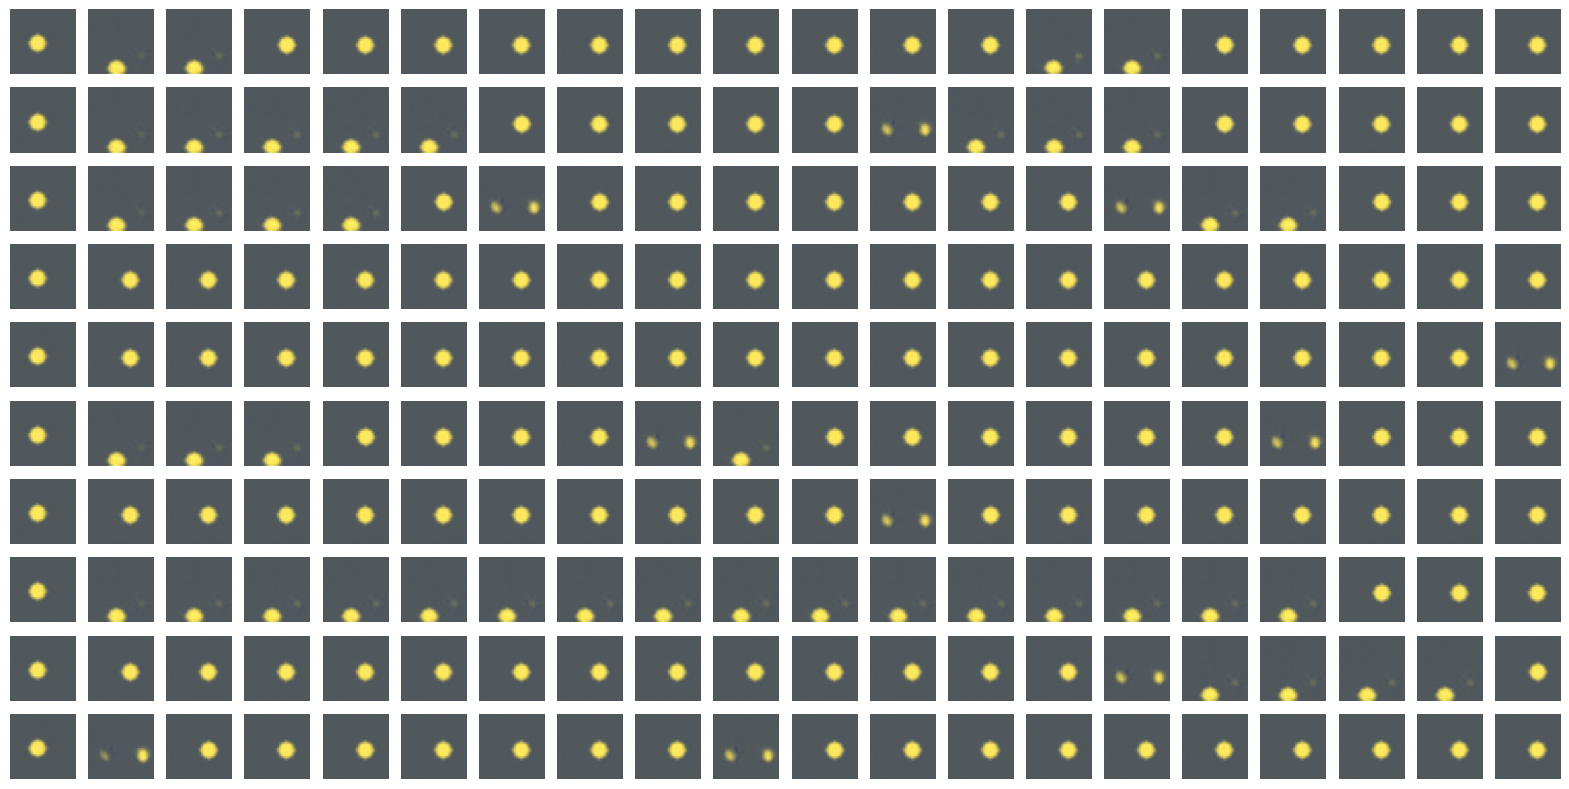

In [32]:
# Create samples

n_samples = 10
seq_len = 20
model.eval()
with torch.inference_mode():
    s = model.sample(n_samples,seq_len)
    s = s.cpu().reshape(n_samples,seq_len,3,32,32)
    s = torch.clamp(s - 0.5,max=0.5).numpy()

imshow_grid(s, n_row=n_samples, n_col=seq_len, fig_size_a=seq_len)      

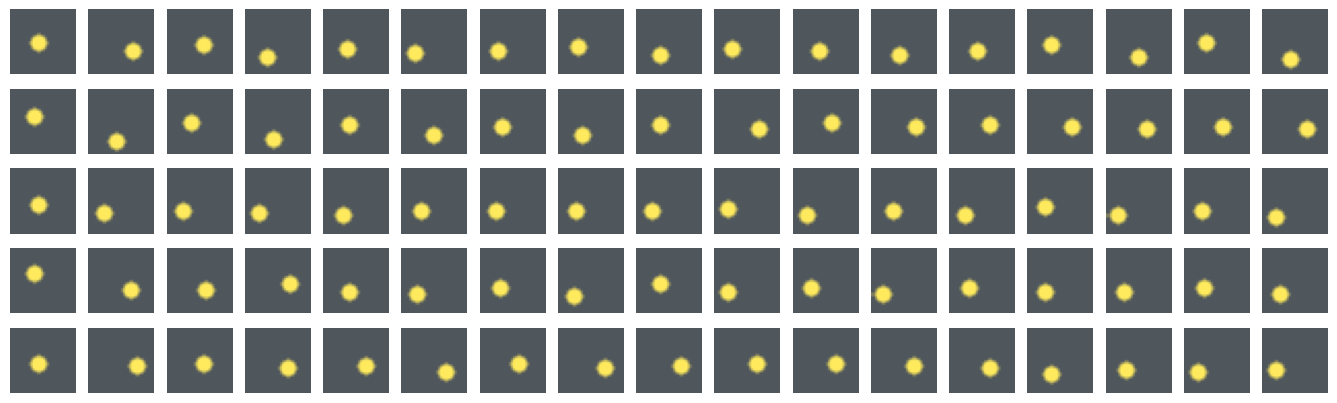

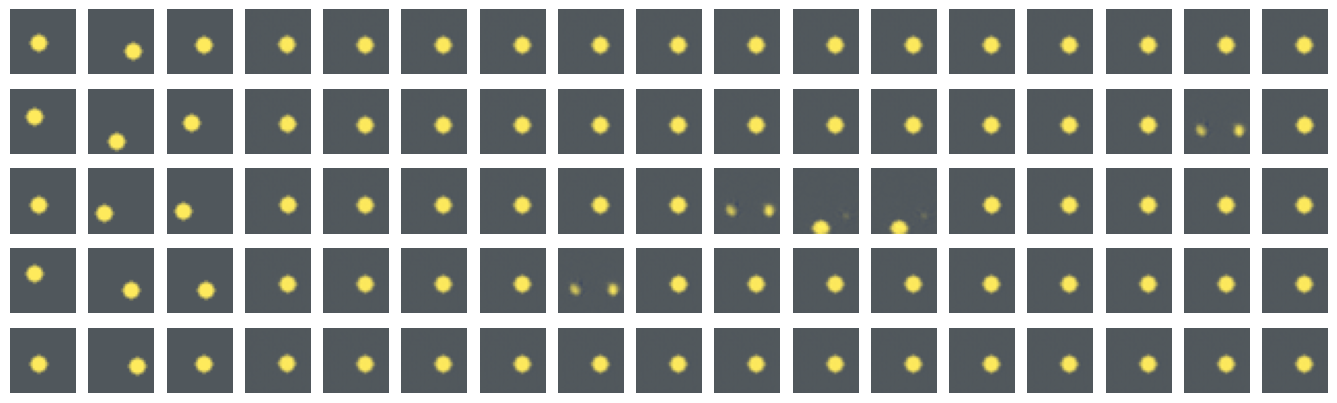

In [33]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE
with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device)) + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=17)
    preds = preds.reshape(B,17,3,32,32)
    preds = torch.clamp(preds,max=1.0)
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.cpu().numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=17, fig_size_a=17, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=17, fig_size_a=17, fig_size_b=5)

In [34]:
with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=17)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 17, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

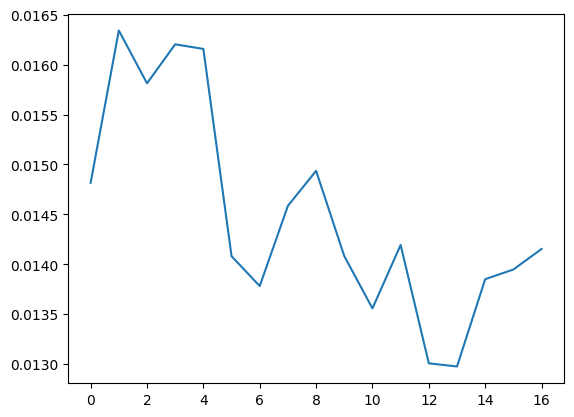

In [35]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')

# IWAE

In [17]:
epoch_num = 20
scheduler_epochs = 20
T = 20
N = 10
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][50/313]	Time 0.623	Loss 334812.3125	 
Epoch: [0][100/313]	Time 0.644	Loss 298387.7500	 
Epoch: [0][150/313]	Time 0.643	Loss 269539.0000	 
Epoch: [0][200/313]	Time 0.661	Loss 76203.8828	 
Epoch: [0][250/313]	Time 0.666	Loss 58110.1680	 
Epoch: [0][300/313]	Time 0.685	Loss 58315.4258	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
9.268593749999999


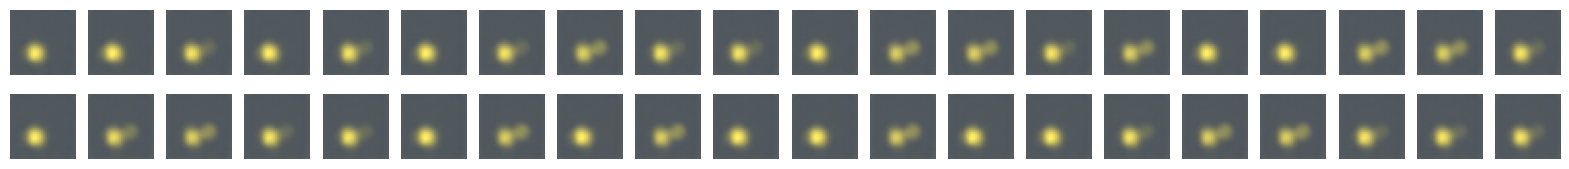

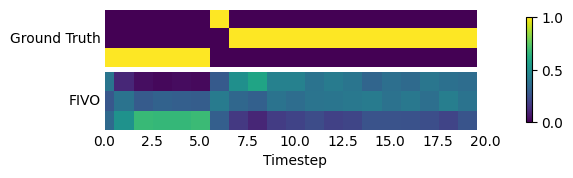

MSE: 0.00474
Pred MSE: 0.00983
Epoch: [1][50/313]	Time 0.664	Loss -7605.4956	 
Epoch: [1][100/313]	Time 0.683	Loss -17009.6719	 
Epoch: [1][150/313]	Time 0.689	Loss -56037.1523	 
Epoch: [1][200/313]	Time 0.705	Loss -83518.8125	 
Epoch: [1][250/313]	Time 0.689	Loss -92901.1328	 
Epoch: [1][300/313]	Time 0.702	Loss -71938.2578	 
MSE: 0.00265
Pred MSE: 0.01182
Epoch: [2][50/313]	Time 0.689	Loss -100966.3203	 
Epoch: [2][100/313]	Time 0.707	Loss -82306.2500	 
Epoch: [2][150/313]	Time 0.709	Loss -84365.8672	 
Epoch: [2][200/313]	Time 0.702	Loss -88503.1797	 
Epoch: [2][250/313]	Time 0.700	Loss -96997.8203	 
Epoch: [2][300/313]	Time 0.696	Loss -107493.9219	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
6.840206855639235


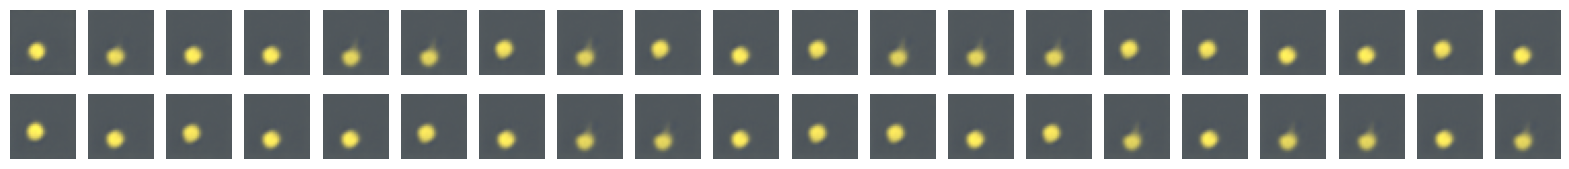

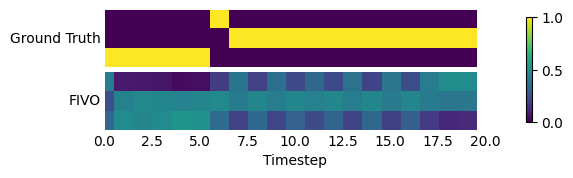

MSE: 0.00206
Pred MSE: 0.01269
Epoch: [3][50/313]	Time 0.693	Loss -101912.3984	 
Epoch: [3][100/313]	Time 0.698	Loss -108127.5312	 
Epoch: [3][150/313]	Time 0.700	Loss -116510.6328	 
Epoch: [3][200/313]	Time 0.691	Loss -112193.1641	 
Epoch: [3][250/313]	Time 0.694	Loss -117273.5156	 
Epoch: [3][300/313]	Time 0.696	Loss -122033.6016	 
MSE: 0.00182
Pred MSE: 0.01225
Epoch: [4][50/313]	Time 0.690	Loss -125906.1562	 
Epoch: [4][100/313]	Time 0.688	Loss -125212.9766	 
Epoch: [4][150/313]	Time 0.700	Loss -124691.9844	 
Epoch: [4][200/313]	Time 0.694	Loss -131913.1094	 
Epoch: [4][250/313]	Time 0.689	Loss -125574.3984	 
Epoch: [4][300/313]	Time 0.695	Loss -116906.6094	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
4.921859810959526


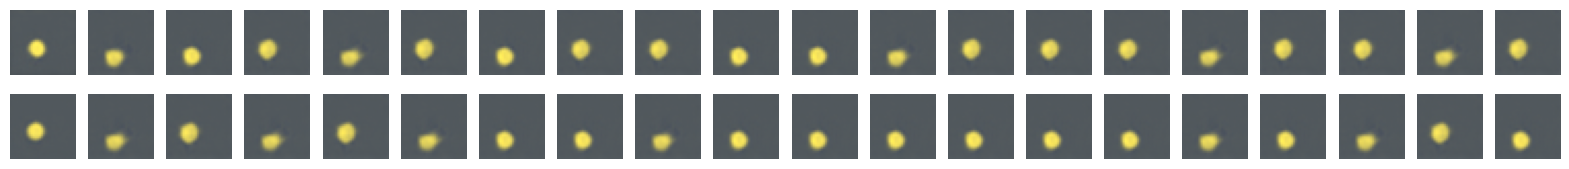

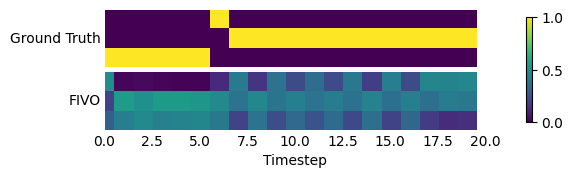

MSE: 0.00172
Pred MSE: 0.01270
Epoch: [5][50/313]	Time 0.691	Loss -129675.8828	 
Epoch: [5][100/313]	Time 0.697	Loss -131170.6719	 
Epoch: [5][150/313]	Time 0.690	Loss -128710.6641	 
Epoch: [5][200/313]	Time 0.697	Loss -133018.5781	 
Epoch: [5][250/313]	Time 0.688	Loss -132968.0469	 
Epoch: [5][300/313]	Time 0.709	Loss -140688.3906	 
MSE: 0.00159
Pred MSE: 0.01266
Epoch: [6][50/313]	Time 0.703	Loss -124273.9609	 
Epoch: [6][100/313]	Time 0.704	Loss -127051.0234	 
Epoch: [6][150/313]	Time 0.695	Loss -139548.1094	 
Epoch: [6][200/313]	Time 0.697	Loss -125487.0547	 
Epoch: [6][250/313]	Time 0.696	Loss -131133.4844	 
Epoch: [6][300/313]	Time 0.697	Loss -130304.4922	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
3.6323243988788025


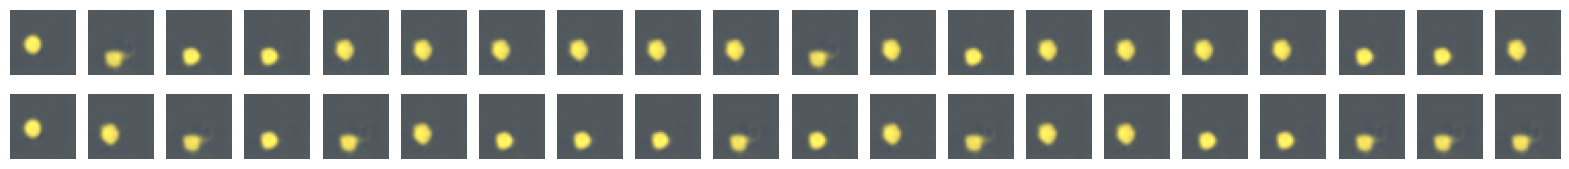

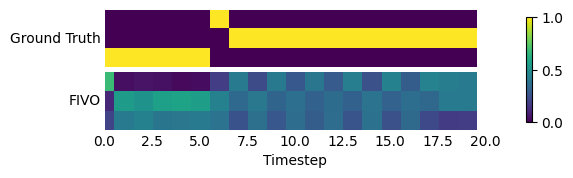

MSE: 0.00169
Pred MSE: 0.01417
Epoch: [7][50/313]	Time 0.688	Loss -133415.7031	 
Epoch: [7][100/313]	Time 0.685	Loss -131398.7031	 
Epoch: [7][150/313]	Time 0.695	Loss -137863.2344	 
Epoch: [7][200/313]	Time 0.696	Loss -141716.5781	 
Epoch: [7][250/313]	Time 0.690	Loss -141441.9062	 
Epoch: [7][300/313]	Time 0.698	Loss -123811.1250	 
MSE: 0.00137
Pred MSE: 0.01299
Epoch: [8][50/313]	Time 0.696	Loss -134141.6250	 
Epoch: [8][100/313]	Time 0.701	Loss -134615.3281	 
Epoch: [8][150/313]	Time 0.699	Loss -137194.0312	 
Epoch: [8][200/313]	Time 0.692	Loss -146744.2344	 
Epoch: [8][250/313]	Time 0.701	Loss -142762.2031	 
Epoch: [8][300/313]	Time 0.689	Loss -148587.5938	 
tensor([[0.3198, 0.3591, 0.3211],
        [0.3194, 0.3601, 0.3205],
        [0.3198, 0.3591, 0.3211]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3554, 0.3176, 0.3271], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2.6136331629313823


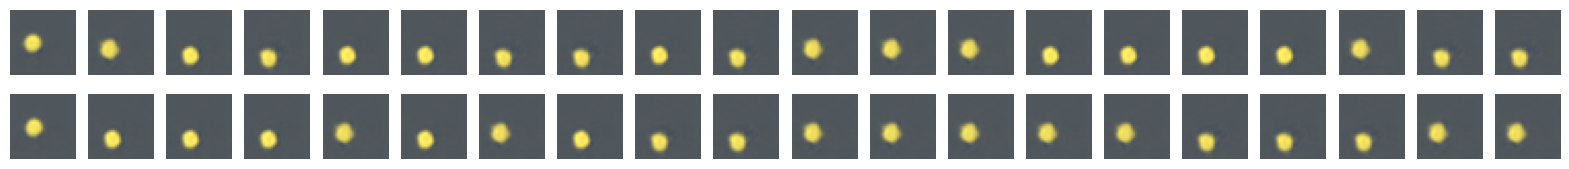

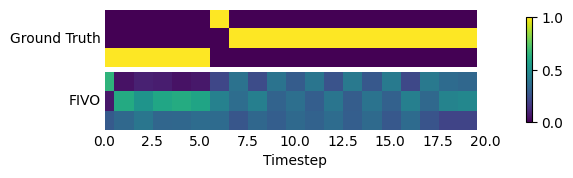

MSE: 0.00148
Pred MSE: 0.01323
Epoch: [9][50/313]	Time 0.690	Loss -140388.8125	 
Epoch: [9][100/313]	Time 0.692	Loss -142530.7031	 
Epoch: [9][150/313]	Time 0.691	Loss -140774.1562	 
Epoch: [9][200/313]	Time 0.690	Loss -143833.9219	 
Epoch: [9][250/313]	Time 0.689	Loss -140360.0781	 
Epoch: [9][300/313]	Time 0.697	Loss -141969.8594	 
MSE: 0.00130
Pred MSE: 0.01279
Epoch: [10][50/313]	Time 0.694	Loss -140416.9844	 
Epoch: [10][100/313]	Time 0.695	Loss -147059.7344	 
Epoch: [10][150/313]	Time 0.692	Loss -142189.6875	 
Epoch: [10][200/313]	Time 0.715	Loss -131811.3281	 
Epoch: [10][250/313]	Time 0.694	Loss -135708.9688	 
Epoch: [10][300/313]	Time 0.692	Loss -146431.0781	 
tensor([[0.2760, 0.4426, 0.2814],
        [0.2726, 0.4580, 0.2694],
        [0.2802, 0.4475, 0.2723]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3693, 0.2515, 0.3793], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.9288569508410385


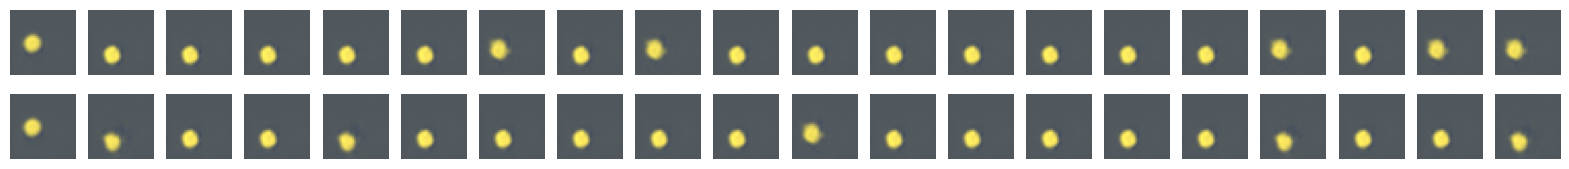

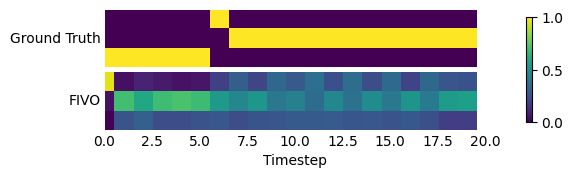

MSE: 0.00122
Pred MSE: 0.01295
Epoch: [11][50/313]	Time 0.690	Loss -142228.5625	 
Epoch: [11][100/313]	Time 0.696	Loss -146591.8594	 
Epoch: [11][150/313]	Time 0.700	Loss -139857.9688	 
Epoch: [11][200/313]	Time 0.694	Loss -157991.3281	 
Epoch: [11][250/313]	Time 0.692	Loss -155867.1094	 
Epoch: [11][300/313]	Time 0.709	Loss -152995.4688	 
MSE: 0.00113
Pred MSE: 0.01412
Epoch: [12][50/313]	Time 0.702	Loss -160068.2812	 
Epoch: [12][100/313]	Time 0.697	Loss -159780.4531	 
Epoch: [12][150/313]	Time 0.693	Loss -162782.9062	 
Epoch: [12][200/313]	Time 0.690	Loss -160832.0938	 
Epoch: [12][250/313]	Time 0.691	Loss -155635.3125	 
Epoch: [12][300/313]	Time 0.691	Loss -157093.4688	 
tensor([[0.1971, 0.5966, 0.2063],
        [0.1812, 0.6467, 0.1721],
        [0.2090, 0.6010, 0.1901]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4055, 0.1657, 0.4288], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.3879059080805012


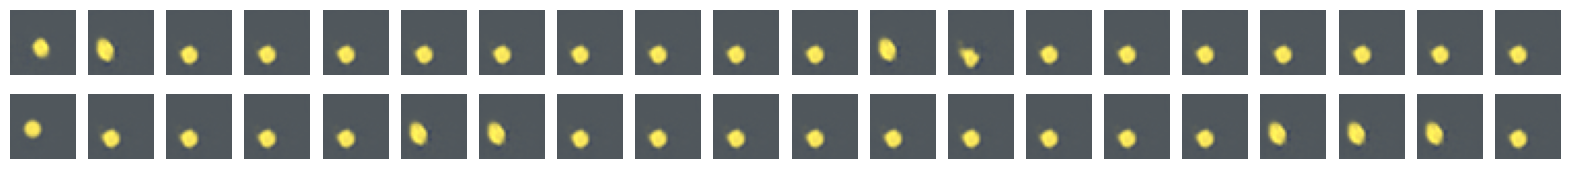

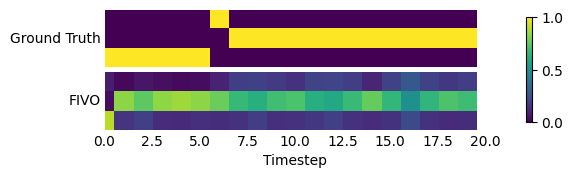

MSE: 0.00099
Pred MSE: 0.01360
Epoch: [13][50/313]	Time 0.691	Loss -164462.2812	 
Epoch: [13][100/313]	Time 0.687	Loss -161980.7031	 
Epoch: [13][150/313]	Time 0.696	Loss -165355.1562	 
Epoch: [13][200/313]	Time 0.697	Loss -163566.7969	 
Epoch: [13][250/313]	Time 0.697	Loss -160981.5469	 
Epoch: [13][300/313]	Time 0.691	Loss -161304.1406	 
MSE: 0.00084
Pred MSE: 0.01325
Epoch: [14][50/313]	Time 0.700	Loss -165022.0625	 
Epoch: [14][100/313]	Time 0.695	Loss -161469.4375	 
Epoch: [14][150/313]	Time 0.694	Loss -168190.1406	 
Epoch: [14][200/313]	Time 0.696	Loss -161600.1562	 
Epoch: [14][250/313]	Time 0.689	Loss -164586.4219	 
Epoch: [14][300/313]	Time 0.699	Loss -163659.5469	 
tensor([[0.1096, 0.7734, 0.1170],
        [0.0779, 0.8524, 0.0697],
        [0.1250, 0.7708, 0.1042]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4611, 0.0882, 0.4507], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.024272264326446


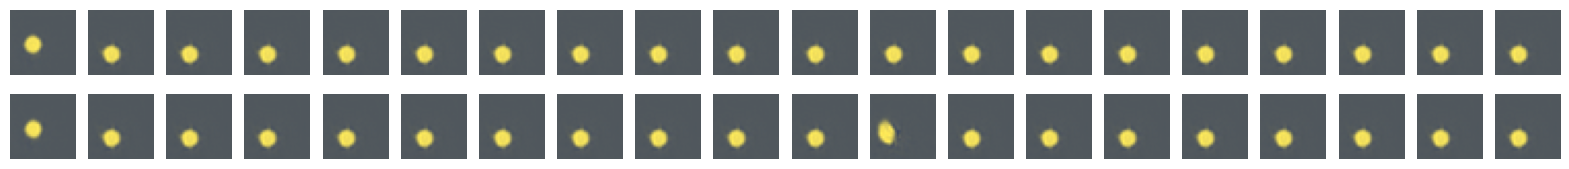

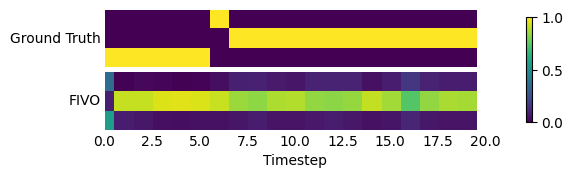

MSE: 0.00096
Pred MSE: 0.01263
Epoch: [15][50/313]	Time 0.690	Loss -163709.0312	 
Epoch: [15][100/313]	Time 0.691	Loss -161294.1719	 
Epoch: [15][150/313]	Time 0.699	Loss -166524.9219	 
Epoch: [15][200/313]	Time 0.698	Loss -169272.4844	 
Epoch: [15][250/313]	Time 0.697	Loss -160664.2969	 
Epoch: [15][300/313]	Time 0.696	Loss -164327.5781	 
MSE: 0.00103
Pred MSE: 0.01247
Epoch: [16][50/313]	Time 0.702	Loss -160072.9062	 
Epoch: [16][100/313]	Time 0.703	Loss -165348.9375	 
Epoch: [16][150/313]	Time 0.697	Loss -161027.8906	 
Epoch: [16][200/313]	Time 0.704	Loss -155723.0781	 
Epoch: [16][250/313]	Time 0.705	Loss -163031.2969	 
Epoch: [16][300/313]	Time 0.696	Loss -171159.2031	 
tensor([[0.0822, 0.8291, 0.0887],
        [0.0503, 0.9060, 0.0438],
        [0.1012, 0.8169, 0.0819]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5278, 0.0770, 0.3952], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


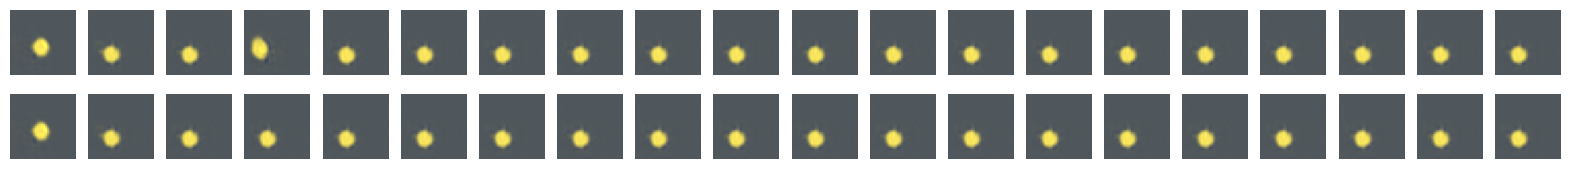

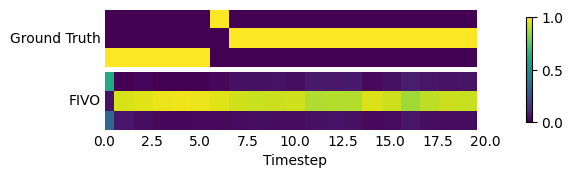

MSE: 0.00090
Pred MSE: 0.01236
Epoch: [17][50/313]	Time 0.697	Loss -164692.7656	 
Epoch: [17][100/313]	Time 0.705	Loss -169564.9219	 
Epoch: [17][150/313]	Time 0.692	Loss -167622.3750	 
Epoch: [17][200/313]	Time 0.696	Loss -163995.4844	 
Epoch: [17][250/313]	Time 0.694	Loss -167654.1094	 
Epoch: [17][300/313]	Time 0.703	Loss -169787.1094	 
MSE: 0.00077
Pred MSE: 0.01281
Epoch: [18][50/313]	Time 0.698	Loss -167308.7969	 
Epoch: [18][100/313]	Time 0.700	Loss -168358.3594	 
Epoch: [18][150/313]	Time 0.702	Loss -169864.1406	 
Epoch: [18][200/313]	Time 0.700	Loss -167582.0312	 
Epoch: [18][250/313]	Time 0.706	Loss -166350.3906	 
Epoch: [18][300/313]	Time 0.693	Loss -168829.0000	 
tensor([[0.0598, 0.8746, 0.0656],
        [0.0339, 0.9371, 0.0290],
        [0.0838, 0.8489, 0.0672]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6275, 0.0657, 0.3068], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


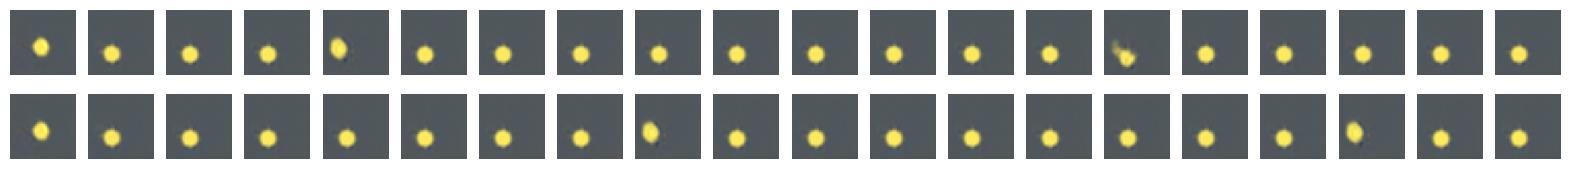

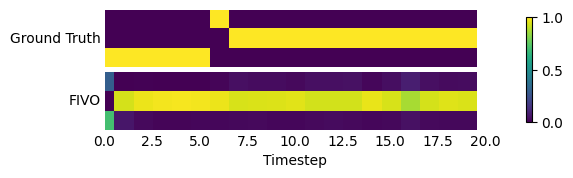

MSE: 0.00076
Pred MSE: 0.01301
Epoch: [19][50/313]	Time 0.700	Loss -165300.3281	 
Epoch: [19][100/313]	Time 0.694	Loss -166837.2656	 
Epoch: [19][150/313]	Time 0.708	Loss -169598.8281	 
Epoch: [19][200/313]	Time 0.848	Loss -163251.8906	 
Epoch: [19][250/313]	Time 0.692	Loss -164076.9219	 
Epoch: [19][300/313]	Time 0.689	Loss -169383.2500	 
MSE: 0.00068
Pred MSE: 0.01237
Epoch: [20][50/313]	Time 0.685	Loss -168987.2969	 
Epoch: [20][100/313]	Time 0.686	Loss -169518.2969	 
Epoch: [20][150/313]	Time 0.682	Loss -170034.8906	 
Epoch: [20][200/313]	Time 0.684	Loss -172037.6875	 
Epoch: [20][250/313]	Time 0.678	Loss -169401.6719	 
Epoch: [20][300/313]	Time 0.682	Loss -173311.2656	 
tensor([[0.0437, 0.9069, 0.0493],
        [0.0244, 0.9551, 0.0205],
        [0.0713, 0.8716, 0.0571]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6988, 0.0570, 0.2441], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


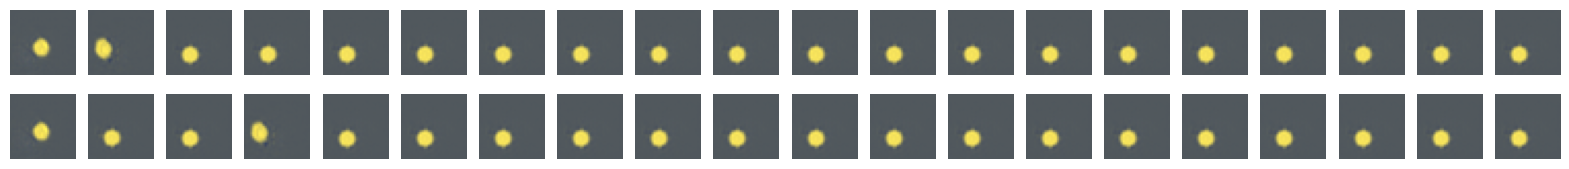

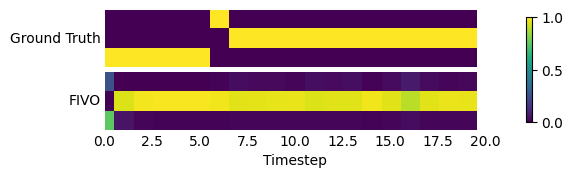

MSE: 0.00068
Pred MSE: 0.01232
Epoch: [21][50/313]	Time 0.682	Loss -163573.8281	 
Epoch: [21][100/313]	Time 0.683	Loss -158744.3438	 
Epoch: [21][150/313]	Time 0.680	Loss -166020.7969	 
Epoch: [21][200/313]	Time 0.680	Loss -166714.9062	 
Epoch: [21][250/313]	Time 0.679	Loss -165463.2344	 
Epoch: [21][300/313]	Time 0.685	Loss -169230.7344	 
MSE: 0.00077
Pred MSE: 0.01282
Epoch: [22][50/313]	Time 0.679	Loss -167850.0781	 
Epoch: [22][100/313]	Time 0.689	Loss -167932.1250	 
Epoch: [22][150/313]	Time 0.687	Loss -170854.5312	 
Epoch: [22][200/313]	Time 0.683	Loss -169413.9688	 
Epoch: [22][250/313]	Time 0.678	Loss -165118.4219	 
Epoch: [22][300/313]	Time 0.680	Loss -169903.2656	 
tensor([[0.0329, 0.9290, 0.0381],
        [0.0187, 0.9658, 0.0155],
        [0.0612, 0.8893, 0.0495]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.7388, 0.0513, 0.2100], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


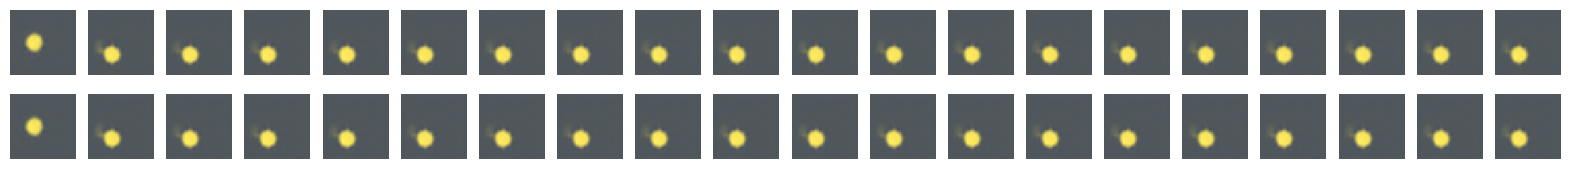

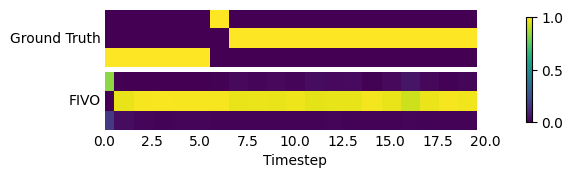

MSE: 0.00067
Pred MSE: 0.01266
Epoch: [23][50/313]	Time 0.677	Loss -171731.4062	 
Epoch: [23][100/313]	Time 0.675	Loss -169544.5625	 
Epoch: [23][150/313]	Time 0.680	Loss -171526.9531	 
Epoch: [23][200/313]	Time 0.681	Loss -171648.0000	 
Epoch: [23][250/313]	Time 0.680	Loss -169814.9062	 
Epoch: [23][300/313]	Time 0.680	Loss -165917.9688	 
MSE: 0.00064
Pred MSE: 0.01280
Epoch: [24][50/313]	Time 0.686	Loss -168976.5469	 
Epoch: [24][100/313]	Time 0.684	Loss -171590.4688	 
Epoch: [24][150/313]	Time 0.678	Loss -172585.5156	 
Epoch: [24][200/313]	Time 0.684	Loss -169332.2344	 
Epoch: [24][250/313]	Time 0.672	Loss -173993.7656	 
Epoch: [24][300/313]	Time 0.677	Loss -172414.8750	 
tensor([[0.0234, 0.9485, 0.0281],
        [0.0139, 0.9747, 0.0113],
        [0.0508, 0.9072, 0.0420]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.7714, 0.0456, 0.1830], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


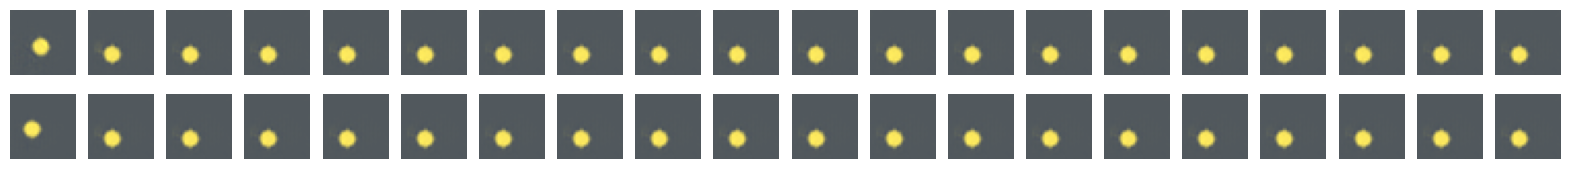

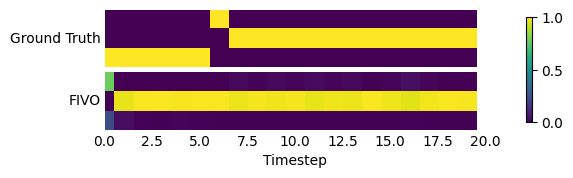

MSE: 0.00058
Pred MSE: 0.01277
Epoch: [25][50/313]	Time 0.680	Loss -170017.9531	 
Epoch: [25][100/313]	Time 0.679	Loss -169277.7812	 
Epoch: [25][150/313]	Time 0.678	Loss -167206.0781	 
Epoch: [25][200/313]	Time 0.686	Loss -170598.0469	 
Epoch: [25][250/313]	Time 0.683	Loss -171255.3438	 
Epoch: [25][300/313]	Time 0.673	Loss -170448.1094	 
MSE: 0.00056
Pred MSE: 0.01248
Epoch: [26][50/313]	Time 0.692	Loss -170054.3594	 
Epoch: [26][100/313]	Time 0.687	Loss -170121.6094	 
Epoch: [26][150/313]	Time 0.687	Loss -171107.1406	 
Epoch: [26][200/313]	Time 0.687	Loss -170858.7344	 
Epoch: [26][250/313]	Time 0.685	Loss -162723.5000	 
Epoch: [26][300/313]	Time 0.677	Loss -164181.4531	 
tensor([[0.0166, 0.9624, 0.0210],
        [0.0106, 0.9809, 0.0085],
        [0.0424, 0.9214, 0.0362]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.8072, 0.0420, 0.1509], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


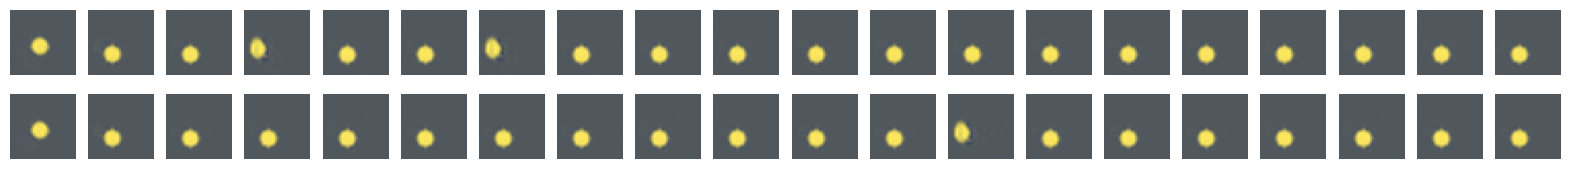

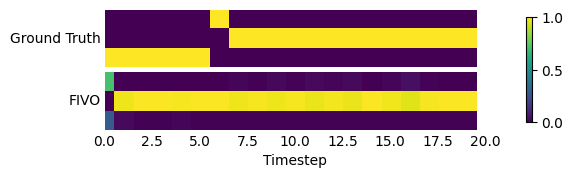

MSE: 0.00064
Pred MSE: 0.01273
Epoch: [27][50/313]	Time 0.679	Loss -171049.9219	 
Epoch: [27][100/313]	Time 0.682	Loss -169970.0312	 
Epoch: [27][150/313]	Time 0.678	Loss -169856.5156	 
Epoch: [27][200/313]	Time 0.683	Loss -172301.1406	 
Epoch: [27][250/313]	Time 0.678	Loss -170835.5781	 
Epoch: [27][300/313]	Time 0.681	Loss -169470.5469	 
MSE: 0.00072
Pred MSE: 0.01311
Epoch: [28][50/313]	Time 0.691	Loss -171933.6094	 
Epoch: [28][100/313]	Time 0.699	Loss -171307.5000	 
Epoch: [28][150/313]	Time 0.687	Loss -171904.9531	 
Epoch: [28][200/313]	Time 0.689	Loss -174367.5312	 
Epoch: [28][250/313]	Time 0.684	Loss -170660.2500	 
Epoch: [28][300/313]	Time 0.682	Loss -168879.7656	 
tensor([[0.0120, 0.9718, 0.0161],
        [0.0083, 0.9851, 0.0065],
        [0.0358, 0.9326, 0.0317]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.8342, 0.0389, 0.1269], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


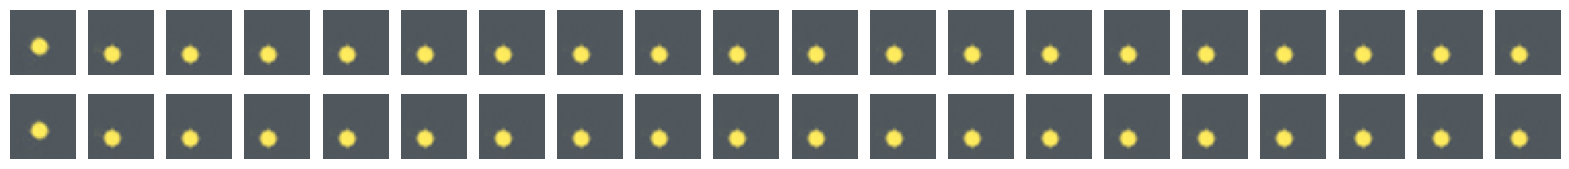

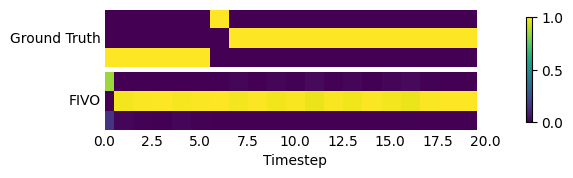

MSE: 0.00065
Pred MSE: 0.01304
Epoch: [29][50/313]	Time 0.678	Loss -173492.4531	 
Epoch: [29][100/313]	Time 0.689	Loss -172105.3906	 
Epoch: [29][150/313]	Time 0.672	Loss -172315.5156	 
Epoch: [29][200/313]	Time 0.683	Loss -172179.1094	 
Epoch: [29][250/313]	Time 0.681	Loss -173696.9062	 
Epoch: [29][300/313]	Time 0.683	Loss -174239.3906	 
MSE: 0.00056
Pred MSE: 0.01282
Epoch: [30][50/313]	Time 0.673	Loss -171995.9844	 
Epoch: [30][100/313]	Time 0.678	Loss -172402.8125	 
Epoch: [30][150/313]	Time 0.681	Loss -173930.9844	 
Epoch: [30][200/313]	Time 0.678	Loss -171681.8438	 
Epoch: [30][250/313]	Time 0.675	Loss -171902.5781	 
Epoch: [30][300/313]	Time 0.680	Loss -173268.9844	 
tensor([[0.0084, 0.9798, 0.0119],
        [0.0063, 0.9889, 0.0049],
        [0.0296, 0.9430, 0.0274]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.8643, 0.0350, 0.1007], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


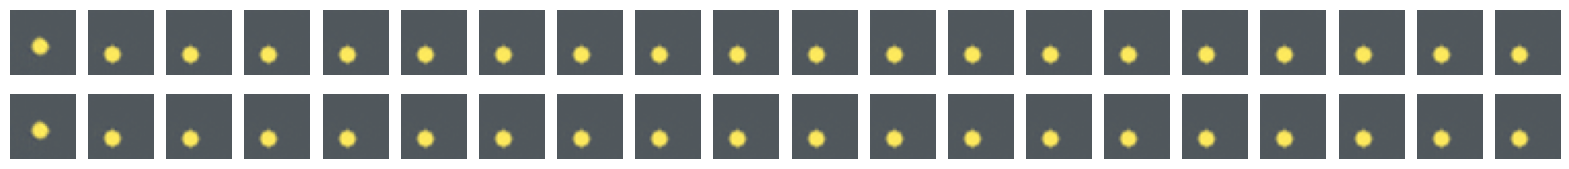

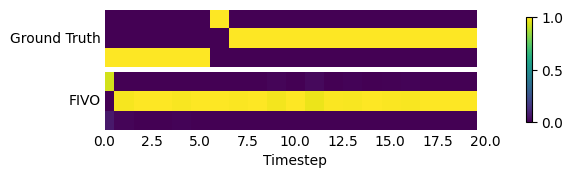

MSE: 0.00058
Pred MSE: 0.01291
Epoch: [31][50/313]	Time 0.681	Loss -171933.6094	 
Epoch: [31][100/313]	Time 0.672	Loss -168748.7969	 
Epoch: [31][150/313]	Time 0.677	Loss -172070.2031	 
Epoch: [31][200/313]	Time 0.679	Loss -174780.0938	 
Epoch: [31][250/313]	Time 0.672	Loss -174261.0781	 
Epoch: [31][300/313]	Time 0.677	Loss -173753.4688	 
MSE: 0.00056
Pred MSE: 0.01308
Epoch: [32][50/313]	Time 0.674	Loss -172676.9844	 
Epoch: [32][100/313]	Time 0.673	Loss -173992.0469	 
Epoch: [32][150/313]	Time 0.680	Loss -173853.2031	 
Epoch: [32][200/313]	Time 0.681	Loss -175379.0625	 
Epoch: [32][250/313]	Time 0.672	Loss -174105.2344	 
Epoch: [32][300/313]	Time 0.682	Loss -173188.7344	 
tensor([[0.0063, 0.9844, 0.0093],
        [0.0050, 0.9912, 0.0038],
        [0.0254, 0.9502, 0.0244]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.8874, 0.0317, 0.0809], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


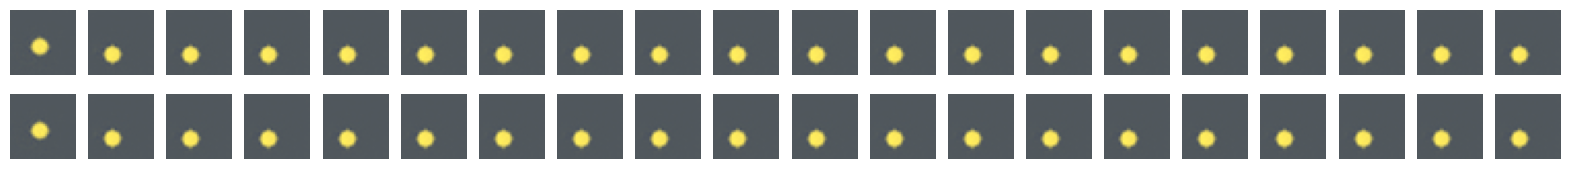

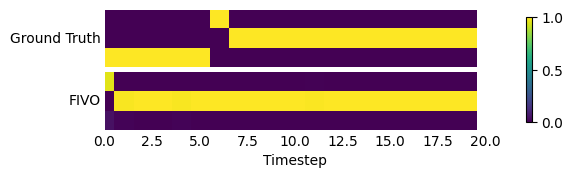

MSE: 0.00051
Pred MSE: 0.01322
Epoch: [33][50/313]	Time 0.668	Loss -175243.2344	 
Epoch: [33][100/313]	Time 0.679	Loss -174510.5469	 
Epoch: [33][150/313]	Time 0.681	Loss -173997.7969	 
Epoch: [33][200/313]	Time 0.694	Loss -174598.2344	 
Epoch: [33][250/313]	Time 0.691	Loss -175039.4531	 
Epoch: [33][300/313]	Time 0.693	Loss -174873.9531	 
MSE: 0.00051
Pred MSE: 0.01291
Epoch: [34][50/313]	Time 0.691	Loss -174496.4531	 
Epoch: [34][100/313]	Time 0.693	Loss -174060.2344	 
Epoch: [34][150/313]	Time 0.692	Loss -175474.0781	 
Epoch: [34][200/313]	Time 0.692	Loss -175110.1094	 
Epoch: [34][250/313]	Time 0.692	Loss -174585.1406	 
Epoch: [34][300/313]	Time 0.691	Loss -171881.4062	 
tensor([[0.0048, 0.9879, 0.0072],
        [0.0040, 0.9931, 0.0029],
        [0.0217, 0.9569, 0.0214]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.9018, 0.0290, 0.0692], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


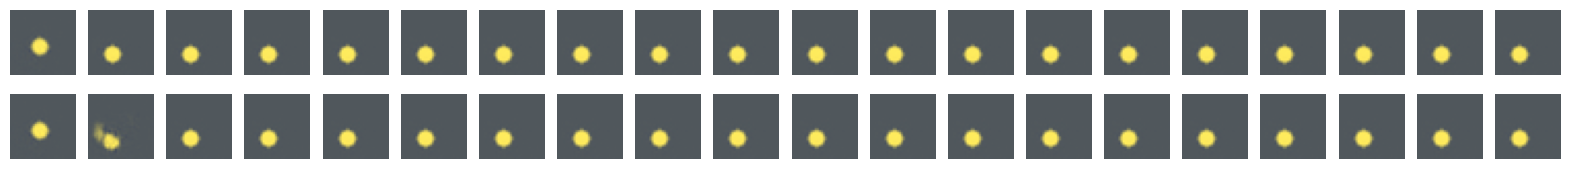

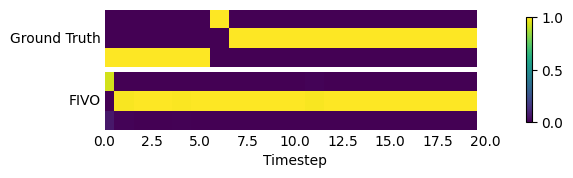

MSE: 0.00053
Pred MSE: 0.01316
Epoch: [35][50/313]	Time 0.691	Loss -169320.3594	 
Epoch: [35][100/313]	Time 0.698	Loss -174223.7031	 
Epoch: [35][150/313]	Time 0.697	Loss -174218.4375	 
Epoch: [35][200/313]	Time 0.693	Loss -173275.3906	 
Epoch: [35][250/313]	Time 0.698	Loss -174715.5312	 
Epoch: [35][300/313]	Time 0.694	Loss -172242.2969	 
MSE: 0.00056
Pred MSE: 0.01275
Epoch: [36][50/313]	Time 0.695	Loss -169640.2188	 
Epoch: [36][100/313]	Time 0.704	Loss -174754.2500	 
Epoch: [36][150/313]	Time 0.708	Loss -175372.9531	 
Epoch: [36][200/313]	Time 0.703	Loss -175333.0938	 
Epoch: [36][250/313]	Time 0.701	Loss -175016.2344	 
Epoch: [36][300/313]	Time 0.693	Loss -175502.5469	 
tensor([[0.0038, 0.9904, 0.0059],
        [0.0033, 0.9944, 0.0023],
        [0.0188, 0.9621, 0.0192]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.9103, 0.0268, 0.0629], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


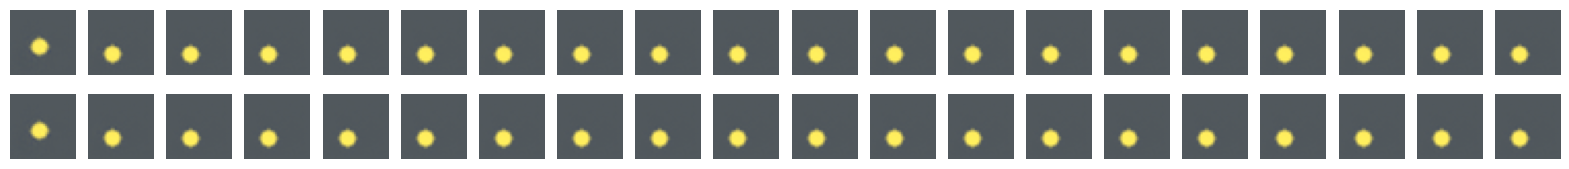

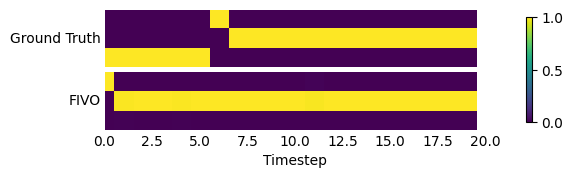

MSE: 0.00055
Pred MSE: 0.01342
Epoch: [37][50/313]	Time 0.695	Loss -175108.7031	 
Epoch: [37][100/313]	Time 0.691	Loss -175194.1250	 
Epoch: [37][150/313]	Time 0.695	Loss -172133.6406	 
Epoch: [37][200/313]	Time 0.691	Loss -174732.4844	 
Epoch: [37][250/313]	Time 0.696	Loss -174832.7344	 
Epoch: [37][300/313]	Time 0.694	Loss -174351.3125	 
MSE: 0.00055
Pred MSE: 0.01301
Epoch: [38][50/313]	Time 0.693	Loss -173942.8594	 
Epoch: [38][100/313]	Time 0.694	Loss -173599.1562	 
Epoch: [38][150/313]	Time 0.700	Loss -173942.3281	 
Epoch: [38][200/313]	Time 0.696	Loss -174582.7656	 
Epoch: [38][250/313]	Time 0.698	Loss -175105.7188	 
Epoch: [38][300/313]	Time 0.693	Loss -175241.5469	 
tensor([[0.0030, 0.9923, 0.0048],
        [0.0026, 0.9956, 0.0018],
        [0.0156, 0.9677, 0.0167]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.9015, 0.0277, 0.0708], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


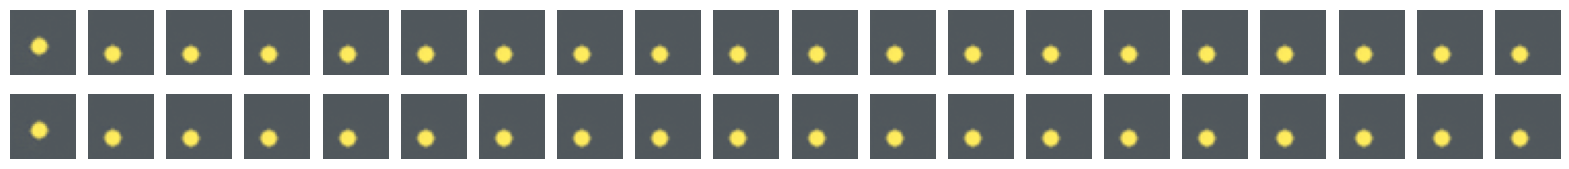

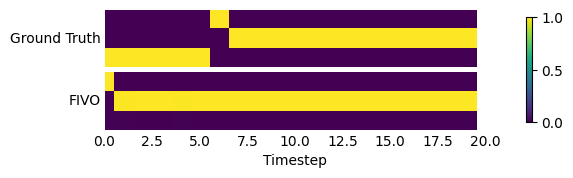

MSE: 0.00052
Pred MSE: 0.01310
Epoch: [39][50/313]	Time 1.025	Loss -175548.4531	 
Epoch: [39][100/313]	Time 0.698	Loss -175179.0469	 
Epoch: [39][150/313]	Time 0.692	Loss -173760.7969	 
Epoch: [39][200/313]	Time 0.687	Loss -173830.6719	 
Epoch: [39][250/313]	Time 0.694	Loss -173722.6406	 
Epoch: [39][300/313]	Time 0.688	Loss -170726.3281	 
MSE: 0.00053
Pred MSE: 0.01307


In [18]:
iwae_losses, test_mse_iwae, pred_mse_iwae = train_iwae(N, model, optimizer,num_states, dim_latent, T)

In [19]:
PATH = 'snlds_video_20_iwae.pth'
torch.save(model.state_dict(), PATH)
#model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
#model.load_state_dict(torch.load(PATH))

Text(0, 0.5, 'Training Loss')

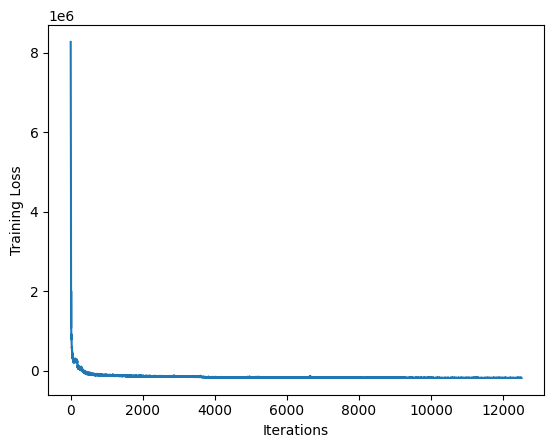

In [20]:
plt.plot(iwae_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

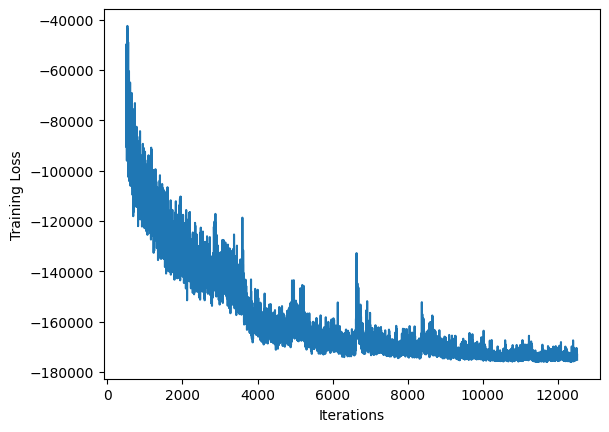

In [21]:
plt.plot(np.arange(500,len(iwae_losses)),iwae_losses[500:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

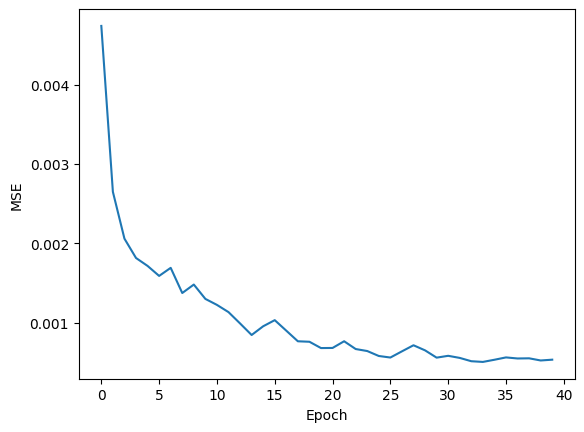

In [22]:
plt.plot(test_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

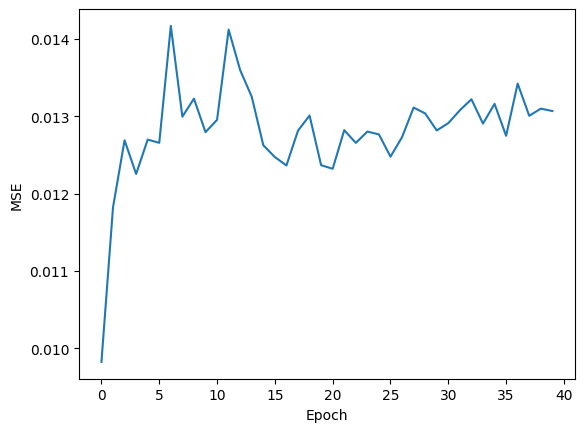

In [23]:
plt.plot(pred_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [24]:
# Training time: 147min
print(f"Last IWAE Loss: {iwae_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_iwae[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_iwae[-1]:.6f}")

Last IWAE Loss: -175193.5
Last Test MSE: 0.000534
Last Pred MSE: 0.013068


In [25]:
print(f"Best IWAE Loss: {min(iwae_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_iwae):.6f}")
print(f"Best Pred MSE: {min(pred_mse_iwae):.6f}")

Best IWAE Loss: -176056.6
Best Test MSE: 0.000506
Best Pred MSE: 0.009826


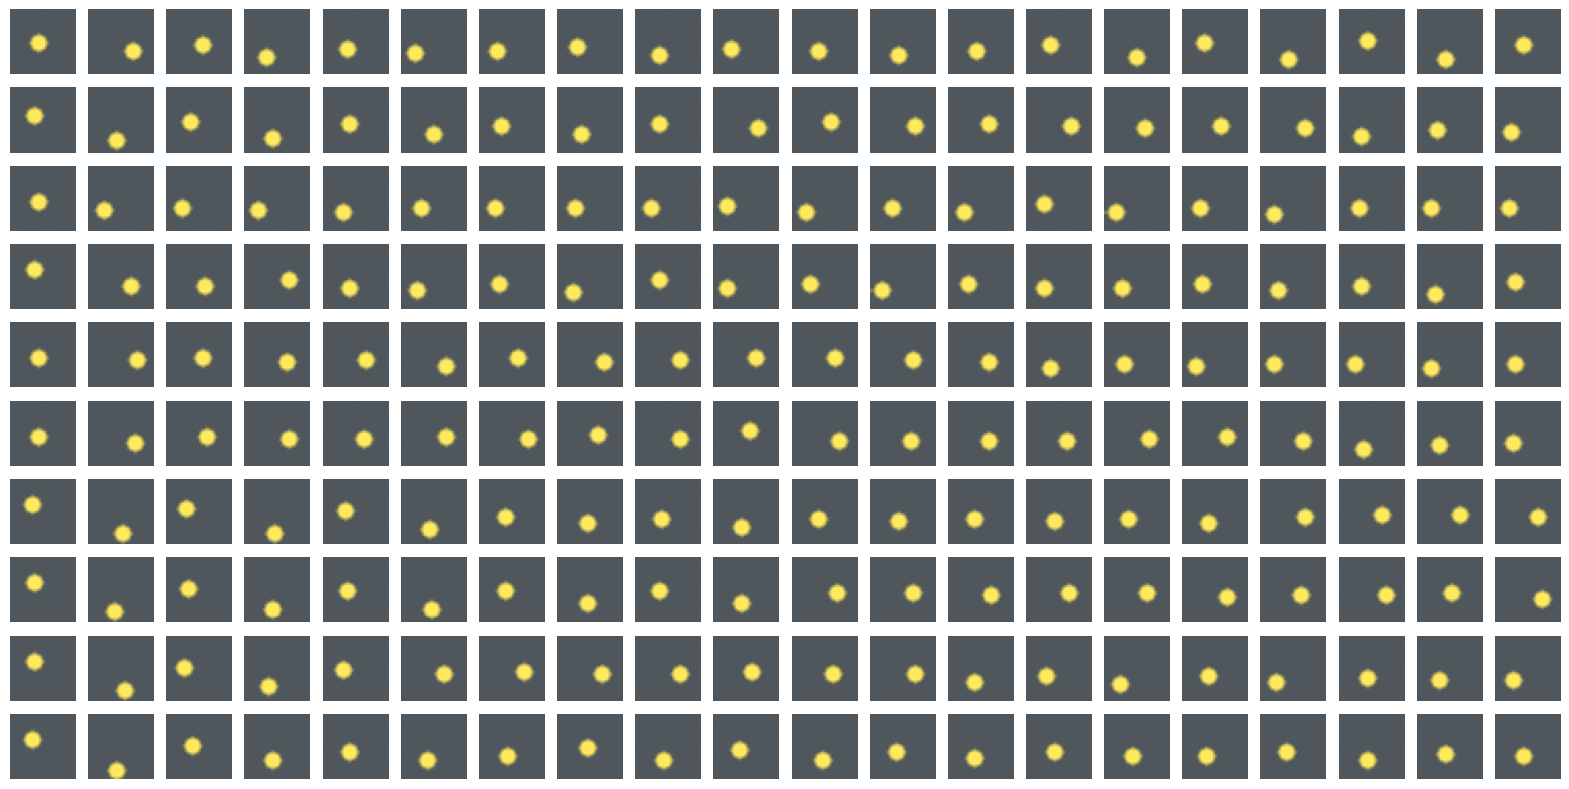

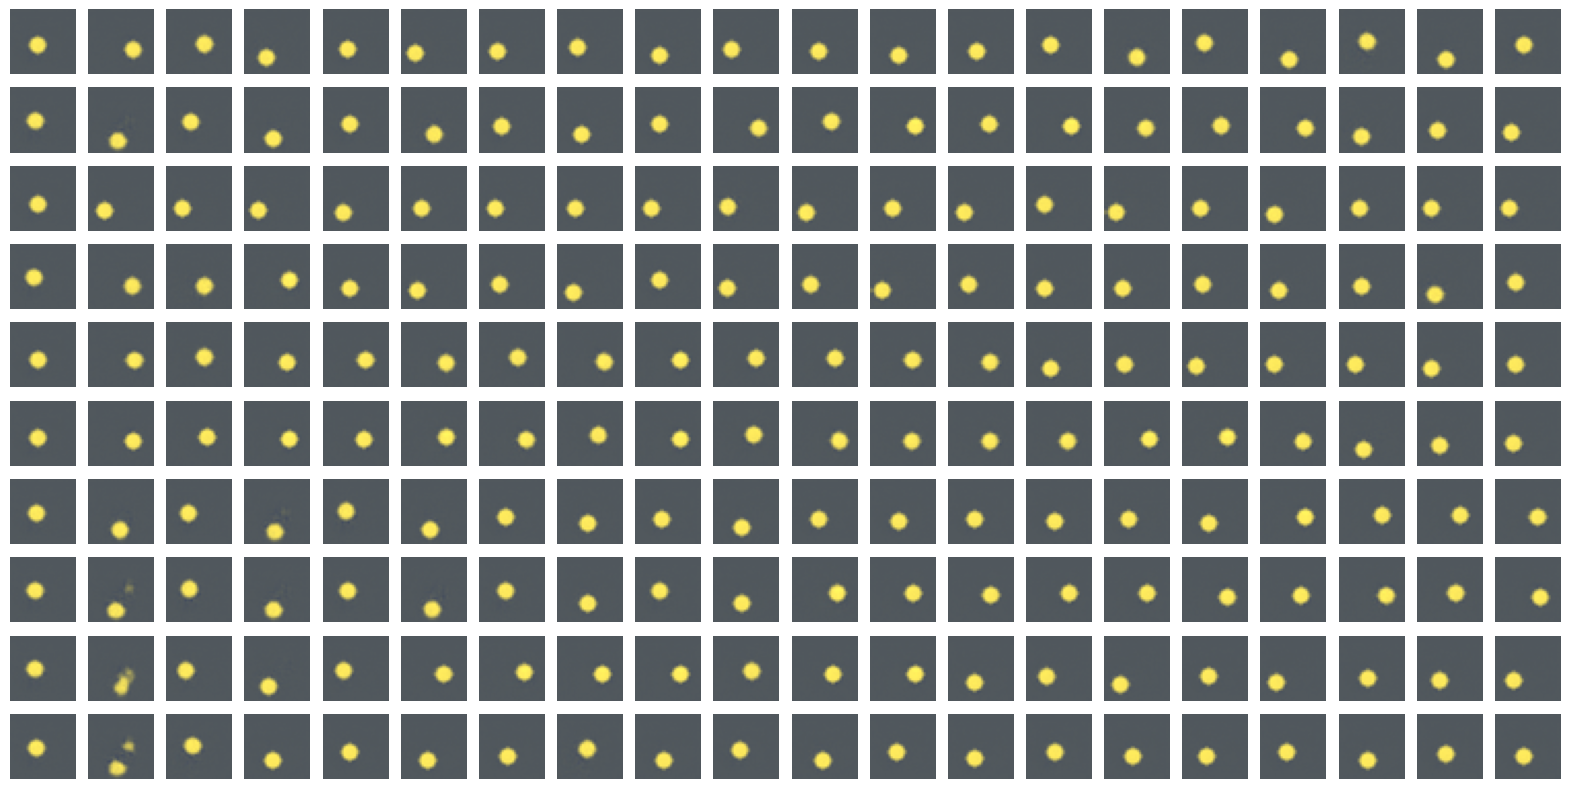

In [26]:
# Reconstructions

n_samples = 10
t = 20
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    x = x + 0.5
    (B,T,C,H,W) = x.shape
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = torch.clamp(recon_x,max=1.0)
    recon_x = recon_x.cpu().reshape(B,T,C,H,W).numpy()

imshow_grid((x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)
imshow_grid((recon_x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)

In [27]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.5f}")

t=0 MSE per pixel:0.00553
t=1 MSE per pixel:0.00143
t=2 MSE per pixel:0.00093
t=3 MSE per pixel:0.00035
t=4 MSE per pixel:0.00021
t=5 MSE per pixel:0.00015
t=6 MSE per pixel:0.00015
t=7 MSE per pixel:0.00044
t=8 MSE per pixel:0.00013
t=9 MSE per pixel:0.00036
t=10 MSE per pixel:0.00019
t=11 MSE per pixel:0.00027
t=12 MSE per pixel:0.00020
t=13 MSE per pixel:0.00012
t=14 MSE per pixel:0.00027
t=15 MSE per pixel:0.00007
t=16 MSE per pixel:0.00006
t=17 MSE per pixel:0.00014
t=18 MSE per pixel:0.00036
t=19 MSE per pixel:0.00025


Text(0, 0.5, 'MSE per Pixel')

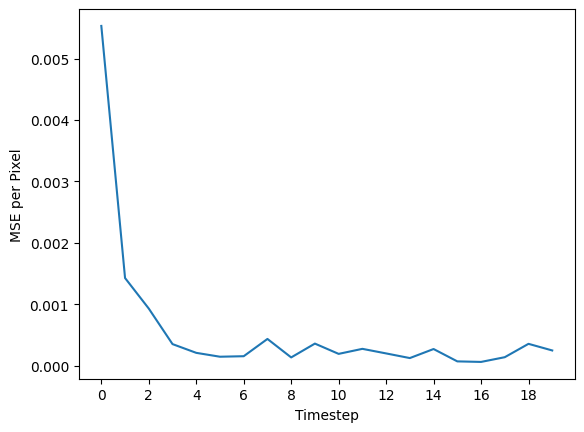

In [28]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,20,2))
plt.ylabel('MSE per Pixel')

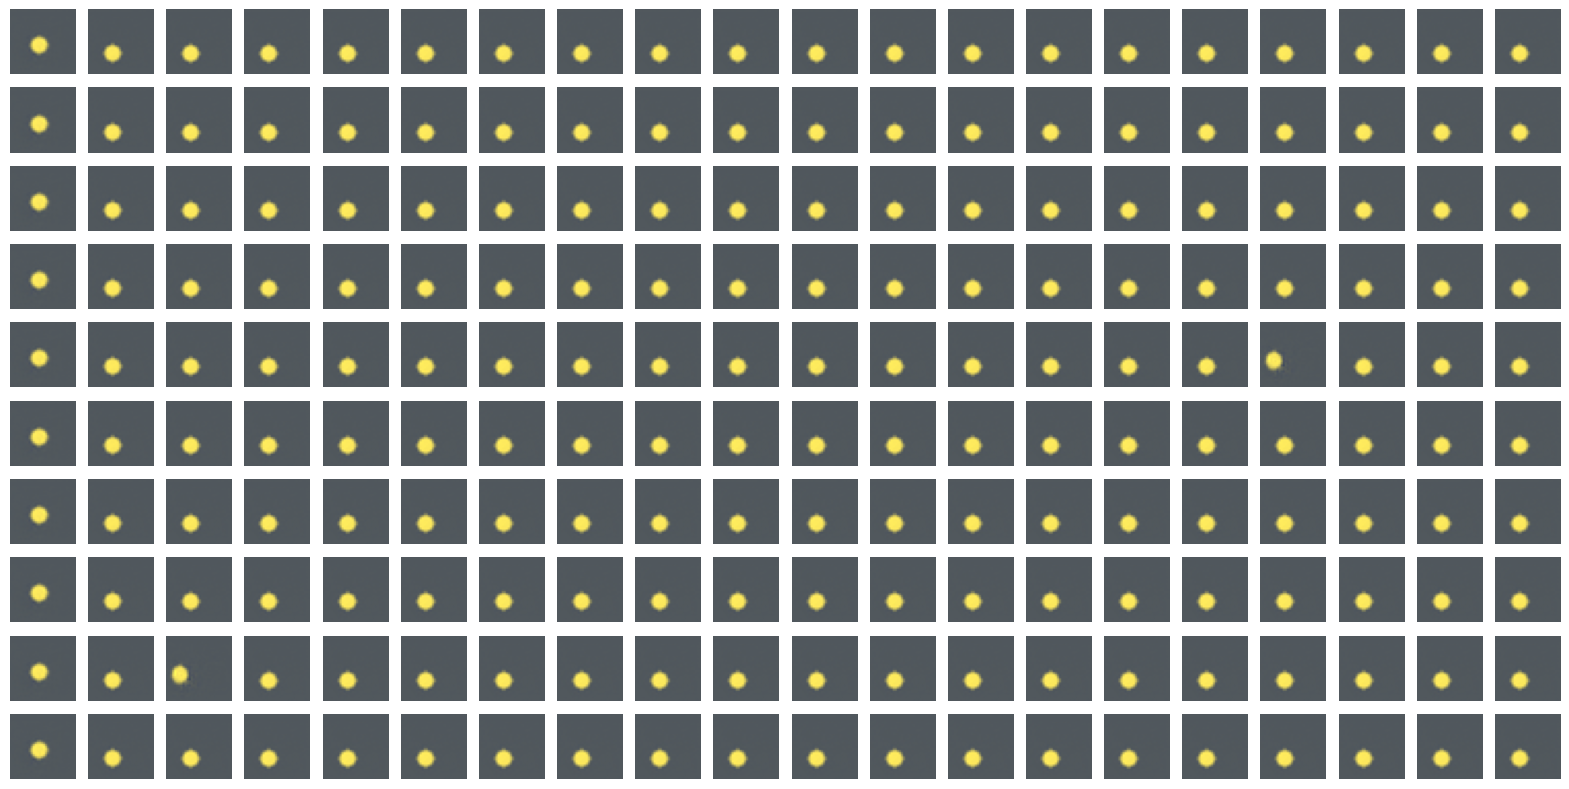

In [30]:
# Create samples

n_samples = 10
seq_len = 20
model.eval()
with torch.inference_mode():
    s = model.sample(n_samples,seq_len)
    s = s.cpu().reshape(n_samples,seq_len,3,32,32)
    s = torch.clamp(s - 0.5,max=0.5).numpy()

imshow_grid(s, n_row=n_samples, n_col=seq_len, fig_size_a=seq_len)      

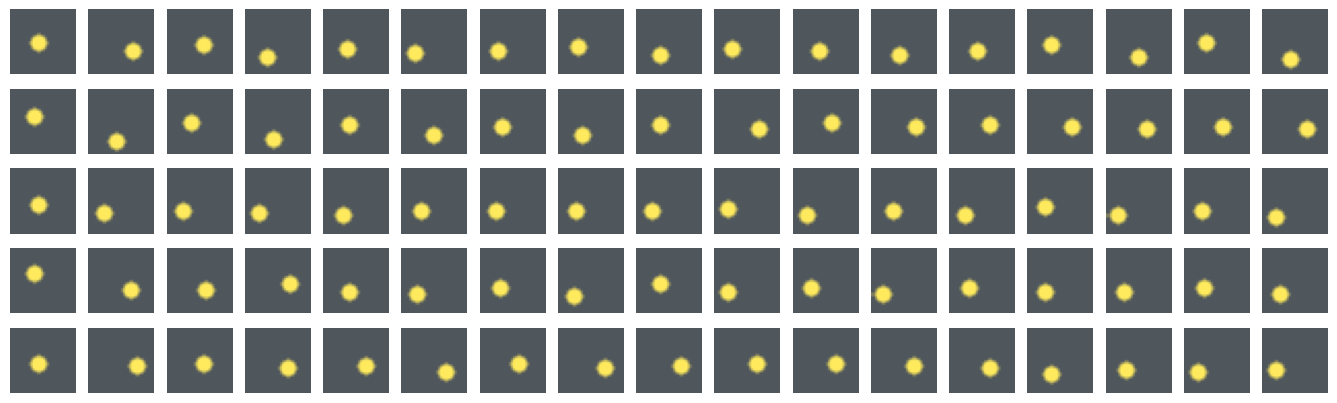

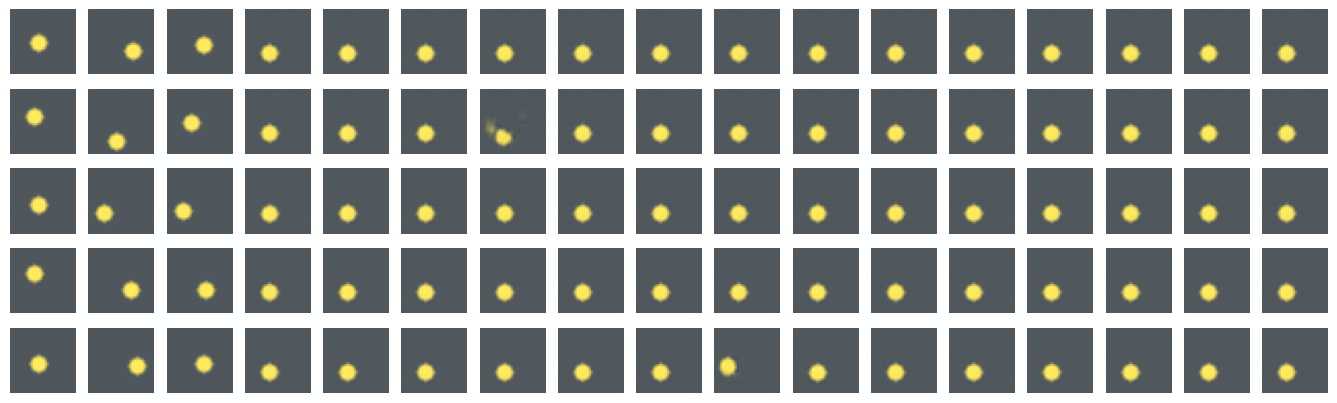

In [31]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE
with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device)) + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=17)
    preds = preds.reshape(B,17,3,32,32)
    preds = torch.clamp(preds,max=1.0)
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.cpu().numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=17, fig_size_a=17, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=17, fig_size_a=17, fig_size_b=5)

In [11]:
with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=17)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 17, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

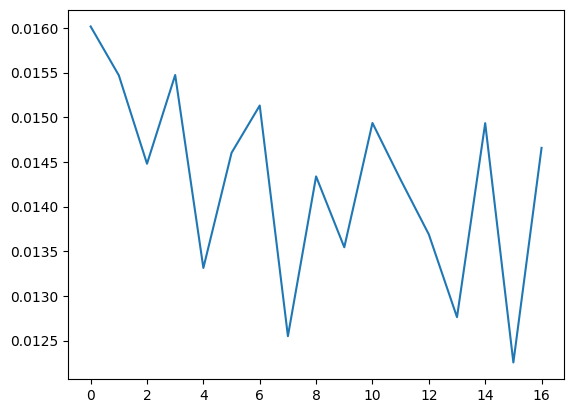

In [14]:
plt.plot(predict_mse[0])

# FIVO

In [19]:
epoch_num = 20
scheduler_epochs = 20
T = 20
N = 10
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][50/313]	Time 0.729	Loss 186618.5156	 
Epoch: [0][100/313]	Time 0.740	Loss 41500.2305	 
Epoch: [0][150/313]	Time 0.732	Loss -36239.7891	 
Epoch: [0][200/313]	Time 0.746	Loss -47890.2383	 
Epoch: [0][250/313]	Time 0.759	Loss -76186.5625	 
Epoch: [0][300/313]	Time 0.773	Loss -102363.8594	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
9.268593749999999


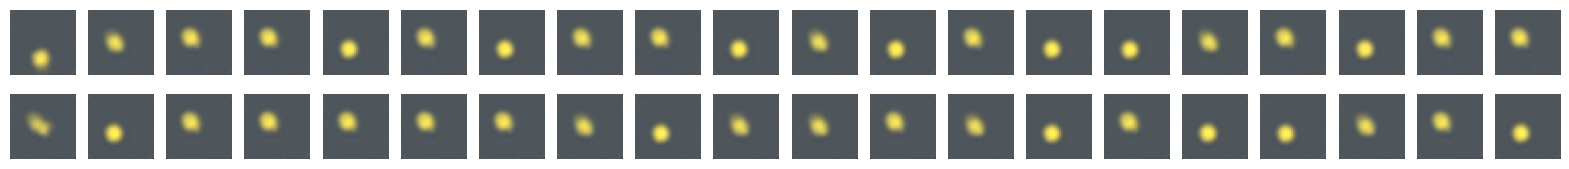

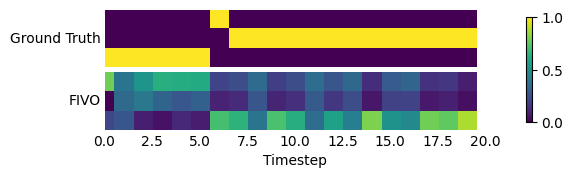

MSE: 0.00579
Pred MSE: 0.01471
Epoch: [1][50/313]	Time 0.779	Loss -114811.1875	 
Epoch: [1][100/313]	Time 0.785	Loss -133943.0781	 
Epoch: [1][150/313]	Time 0.749	Loss -144513.7188	 
Epoch: [1][200/313]	Time 0.872	Loss -144005.1094	 
Epoch: [1][250/313]	Time 0.926	Loss -141693.7344	 
Epoch: [1][300/313]	Time 0.777	Loss -151382.9688	 
MSE: 0.00445
Pred MSE: 0.01597
Epoch: [2][50/313]	Time 0.766	Loss -154104.7031	 
Epoch: [2][100/313]	Time 0.763	Loss -153401.0625	 
Epoch: [2][150/313]	Time 0.759	Loss -154019.7188	 
Epoch: [2][200/313]	Time 0.800	Loss -161619.2188	 
Epoch: [2][250/313]	Time 0.801	Loss -163925.4062	 
Epoch: [2][300/313]	Time 0.814	Loss -163151.5625	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
6.840206855639235


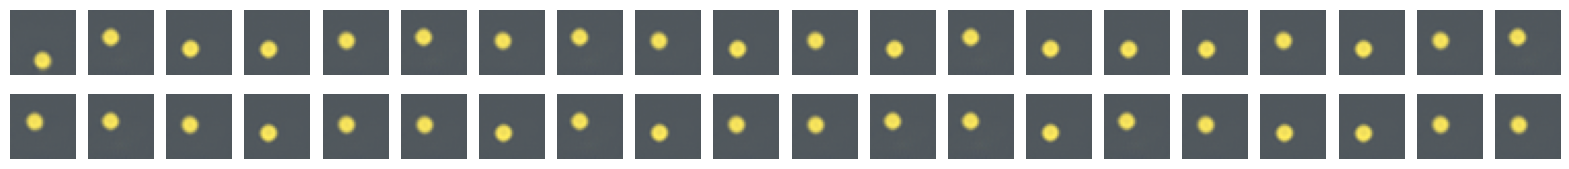

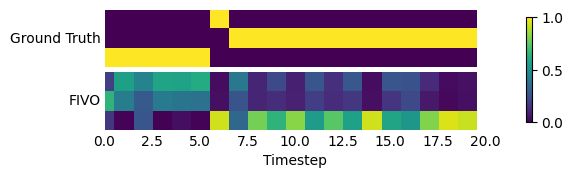

MSE: 0.00265
Pred MSE: 0.01625
Epoch: [3][50/313]	Time 0.752	Loss -164137.2344	 
Epoch: [3][100/313]	Time 0.798	Loss -169308.6875	 
Epoch: [3][150/313]	Time 0.807	Loss -166688.1562	 
Epoch: [3][200/313]	Time 0.812	Loss -169860.8594	 
Epoch: [3][250/313]	Time 0.794	Loss -167926.0156	 
Epoch: [3][300/313]	Time 0.778	Loss -168564.4062	 
MSE: 0.00085
Pred MSE: 0.01725
Epoch: [4][50/313]	Time 0.803	Loss -169938.0469	 
Epoch: [4][100/313]	Time 0.781	Loss -171220.1250	 
Epoch: [4][150/313]	Time 0.778	Loss -171723.4844	 
Epoch: [4][200/313]	Time 0.769	Loss -171575.4062	 
Epoch: [4][250/313]	Time 0.776	Loss -169916.5625	 
Epoch: [4][300/313]	Time 0.853	Loss -171110.6562	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
4.921859810959526


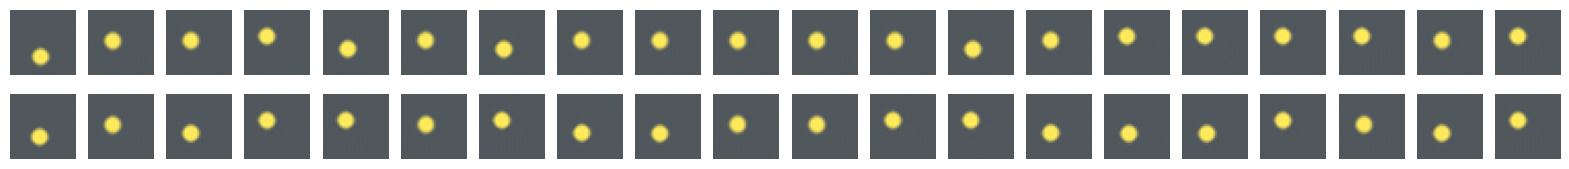

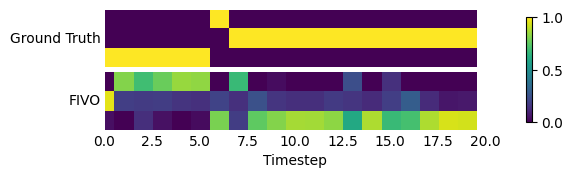

MSE: 0.00039
Pred MSE: 0.01754
Epoch: [5][50/313]	Time 0.760	Loss -172545.5625	 
Epoch: [5][100/313]	Time 0.780	Loss -171738.2031	 
Epoch: [5][150/313]	Time 0.766	Loss -172939.2188	 
Epoch: [5][200/313]	Time 0.882	Loss -171872.7031	 
Epoch: [5][250/313]	Time 0.774	Loss -173053.8125	 
Epoch: [5][300/313]	Time 0.779	Loss -172783.8750	 
MSE: 0.00030
Pred MSE: 0.01768
Epoch: [6][50/313]	Time 0.751	Loss -169964.7656	 
Epoch: [6][100/313]	Time 0.783	Loss -172779.8906	 
Epoch: [6][150/313]	Time 0.783	Loss -172685.1094	 
Epoch: [6][200/313]	Time 0.795	Loss -173385.4062	 
Epoch: [6][250/313]	Time 0.782	Loss -172471.6562	 
Epoch: [6][300/313]	Time 0.752	Loss -173478.1875	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
3.6323243988788025


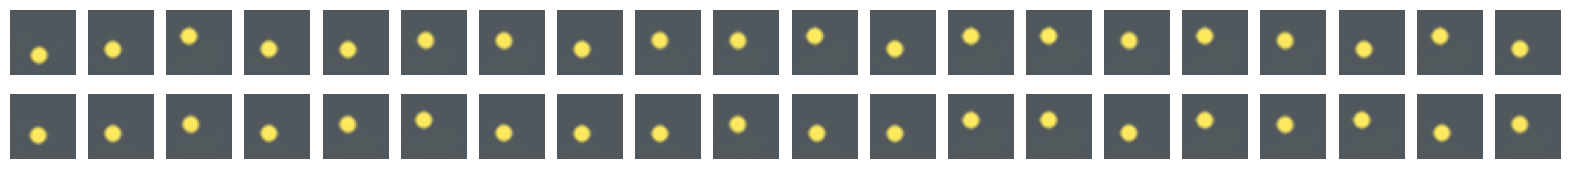

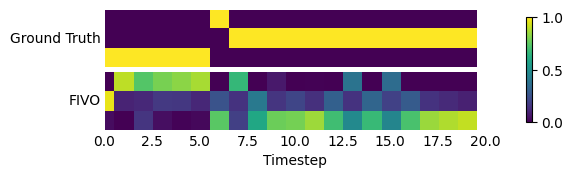

MSE: 0.00020
Pred MSE: 0.01738
Epoch: [7][50/313]	Time 0.774	Loss -173659.0625	 
Epoch: [7][100/313]	Time 0.782	Loss -173975.4062	 
Epoch: [7][150/313]	Time 0.763	Loss -169992.7656	 
Epoch: [7][200/313]	Time 0.840	Loss -172006.0156	 
Epoch: [7][250/313]	Time 0.778	Loss -173590.0781	 
Epoch: [7][300/313]	Time 0.791	Loss -164060.5312	 
MSE: 0.00018
Pred MSE: 0.01710
Epoch: [8][50/313]	Time 0.783	Loss -169005.9531	 
Epoch: [8][100/313]	Time 0.759	Loss -174285.0156	 
Epoch: [8][150/313]	Time 0.776	Loss -172586.1094	 
Epoch: [8][200/313]	Time 0.777	Loss -174134.7656	 
Epoch: [8][250/313]	Time 0.792	Loss -174473.5000	 
Epoch: [8][300/313]	Time 0.785	Loss -173607.4688	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
2.6136331629313823


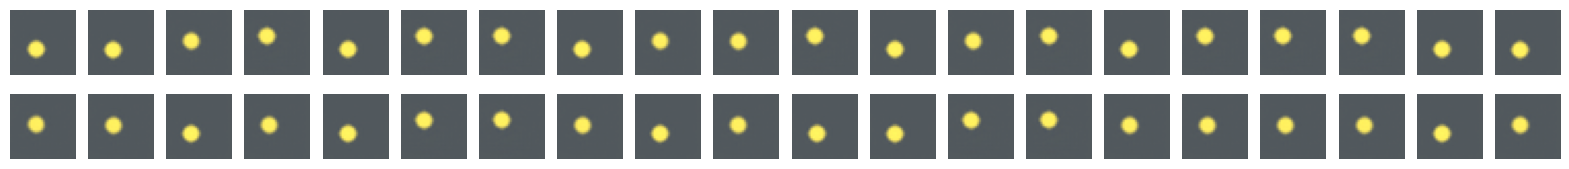

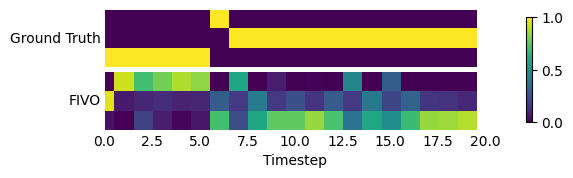

MSE: 0.00020
Pred MSE: 0.01800
Epoch: [9][50/313]	Time 0.783	Loss -171386.7031	 
Epoch: [9][100/313]	Time 0.775	Loss -173894.6875	 
Epoch: [9][150/313]	Time 0.816	Loss -173174.5000	 
Epoch: [9][200/313]	Time 0.803	Loss -174418.0312	 
Epoch: [9][250/313]	Time 0.830	Loss -173336.7031	 
Epoch: [9][300/313]	Time 0.786	Loss -175084.3125	 
MSE: 0.00011
Pred MSE: 0.01672
Epoch: [10][50/313]	Time 0.788	Loss -173524.9375	 
Epoch: [10][100/313]	Time 0.817	Loss -174571.3750	 
Epoch: [10][150/313]	Time 0.817	Loss -172896.7656	 
Epoch: [10][200/313]	Time 0.820	Loss -174903.6406	 
Epoch: [10][250/313]	Time 0.770	Loss -175167.4062	 
Epoch: [10][300/313]	Time 0.845	Loss -175218.5312	 
tensor([[0.3270, 0.3119, 0.3611],
        [0.3225, 0.3139, 0.3637],
        [0.3200, 0.3139, 0.3662]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3259, 0.3608, 0.3132], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.9288569508410385


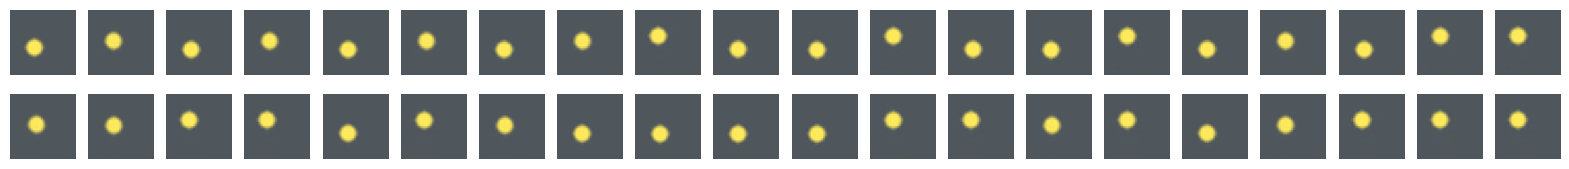

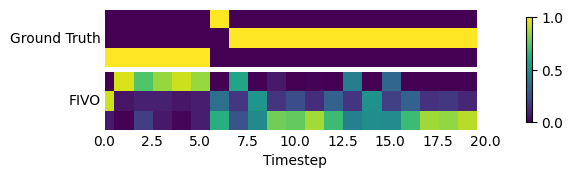

MSE: 0.00013
Pred MSE: 0.01693
Epoch: [11][50/313]	Time 0.773	Loss -174974.0156	 
Epoch: [11][100/313]	Time 0.797	Loss -175530.8906	 
Epoch: [11][150/313]	Time 0.890	Loss -174032.4375	 
Epoch: [11][200/313]	Time 0.780	Loss -174826.1250	 
Epoch: [11][250/313]	Time 0.785	Loss -175431.5000	 
Epoch: [11][300/313]	Time 0.782	Loss -175372.5938	 
MSE: 0.00009
Pred MSE: 0.01597
Epoch: [12][50/313]	Time 0.795	Loss -175527.0156	 
Epoch: [12][100/313]	Time 0.795	Loss -175626.2188	 
Epoch: [12][150/313]	Time 0.793	Loss -175508.1875	 
Epoch: [12][200/313]	Time 0.788	Loss -175810.0469	 
Epoch: [12][250/313]	Time 0.766	Loss -175480.4844	 
Epoch: [12][300/313]	Time 0.924	Loss -174219.8594	 
tensor([[0.3016, 0.2431, 0.4553],
        [0.2878, 0.2530, 0.4592],
        [0.2706, 0.2444, 0.4851]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2784, 0.4476, 0.2740], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.3879059080805012


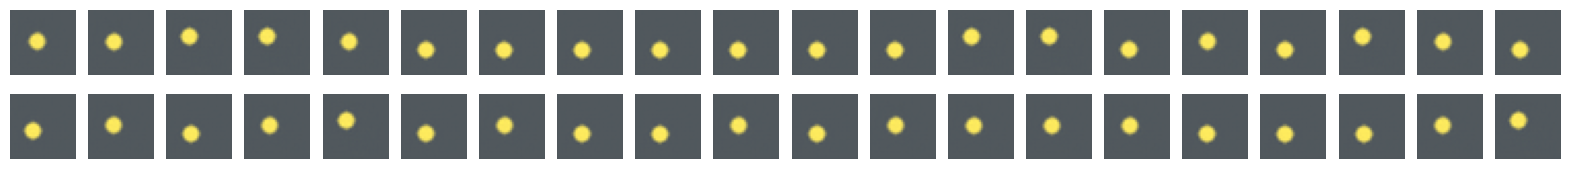

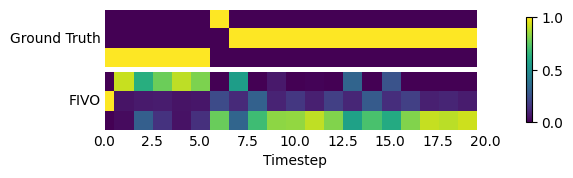

MSE: 0.00019
Pred MSE: 0.01595
Epoch: [13][50/313]	Time 0.777	Loss -174113.9219	 
Epoch: [13][100/313]	Time 0.796	Loss -175589.1562	 
Epoch: [13][150/313]	Time 0.771	Loss -175357.3125	 
Epoch: [13][200/313]	Time 0.785	Loss -174981.3125	 
Epoch: [13][250/313]	Time 0.785	Loss -175381.2656	 
Epoch: [13][300/313]	Time 0.866	Loss -175945.5156	 
MSE: 0.00007
Pred MSE: 0.01512
Epoch: [14][50/313]	Time 0.772	Loss -175750.0625	 
Epoch: [14][100/313]	Time 0.780	Loss -176009.5156	 
Epoch: [14][150/313]	Time 0.853	Loss -174980.4844	 
Epoch: [14][200/313]	Time 0.777	Loss -175525.7812	 
Epoch: [14][250/313]	Time 0.819	Loss -175756.5312	 
Epoch: [14][300/313]	Time 0.869	Loss -173607.6719	 
tensor([[0.2405, 0.1521, 0.6074],
        [0.2335, 0.1761, 0.5905],
        [0.1775, 0.1368, 0.6857]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2231, 0.5363, 0.2406], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.024272264326446


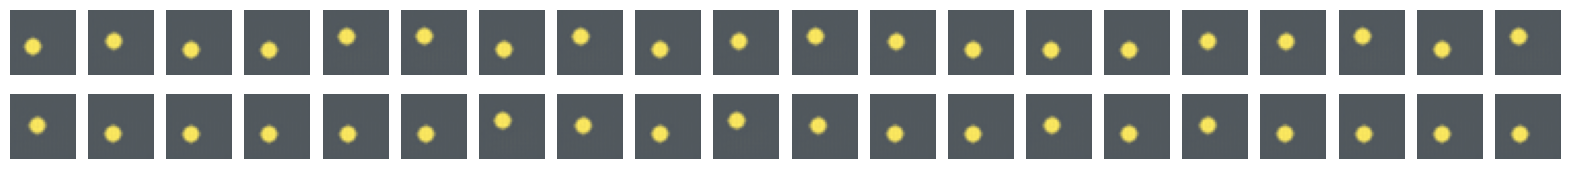

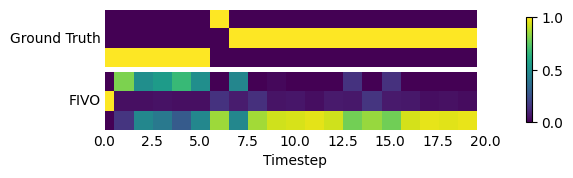

MSE: 0.00017
Pred MSE: 0.01451
Epoch: [15][50/313]	Time 0.777	Loss -168980.6406	 
Epoch: [15][100/313]	Time 0.892	Loss -175580.5312	 
Epoch: [15][150/313]	Time 0.796	Loss -175954.7969	 
Epoch: [15][200/313]	Time 0.894	Loss -175558.4531	 
Epoch: [15][250/313]	Time 0.819	Loss -175889.7500	 
Epoch: [15][300/313]	Time 0.999	Loss -175518.5000	 
MSE: 0.00005
Pred MSE: 0.01536
Epoch: [16][50/313]	Time 0.793	Loss -175872.3438	 
Epoch: [16][100/313]	Time 0.783	Loss -176015.5625	 
Epoch: [16][150/313]	Time 0.788	Loss -175561.7188	 
Epoch: [16][200/313]	Time 0.783	Loss -176315.4375	 
Epoch: [16][250/313]	Time 0.781	Loss -175798.5312	 
Epoch: [16][300/313]	Time 0.781	Loss -175548.2500	 
tensor([[0.1992, 0.1171, 0.6836],
        [0.2046, 0.1538, 0.6416],
        [0.1232, 0.0880, 0.7887]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2132, 0.5406, 0.2462], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


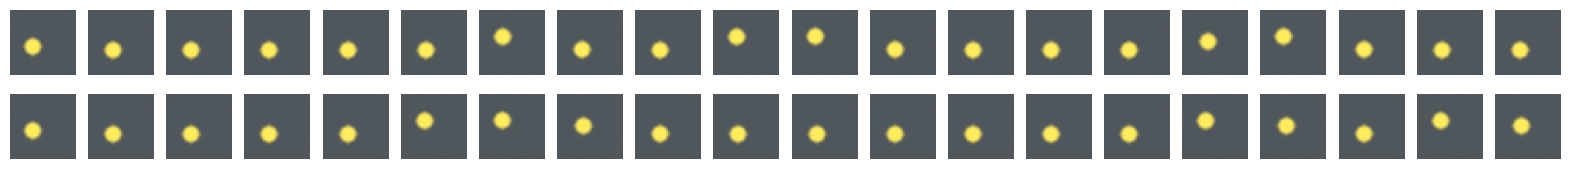

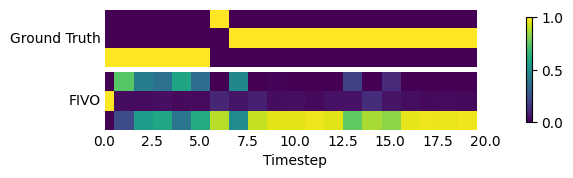

MSE: 0.00007
Pred MSE: 0.01474
Epoch: [17][50/313]	Time 0.788	Loss -174079.6406	 
Epoch: [17][100/313]	Time 0.784	Loss -171715.0000	 
Epoch: [17][150/313]	Time 0.782	Loss -174887.5312	 
Epoch: [17][200/313]	Time 0.780	Loss -175733.2812	 
Epoch: [17][250/313]	Time 0.795	Loss -176145.6406	 
Epoch: [17][300/313]	Time 0.776	Loss -175006.2188	 
MSE: 0.00007
Pred MSE: 0.01416
Epoch: [18][50/313]	Time 0.798	Loss -175619.9688	 
Epoch: [18][100/313]	Time 0.790	Loss -175987.8438	 
Epoch: [18][150/313]	Time 0.814	Loss -175927.1250	 
Epoch: [18][200/313]	Time 0.793	Loss -176138.5625	 
Epoch: [18][250/313]	Time 0.806	Loss -176118.7188	 
Epoch: [18][300/313]	Time 0.811	Loss -176091.1562	 
tensor([[0.1670, 0.0937, 0.7393],
        [0.1825, 0.1458, 0.6717],
        [0.0861, 0.0574, 0.8566]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2126, 0.5468, 0.2405], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


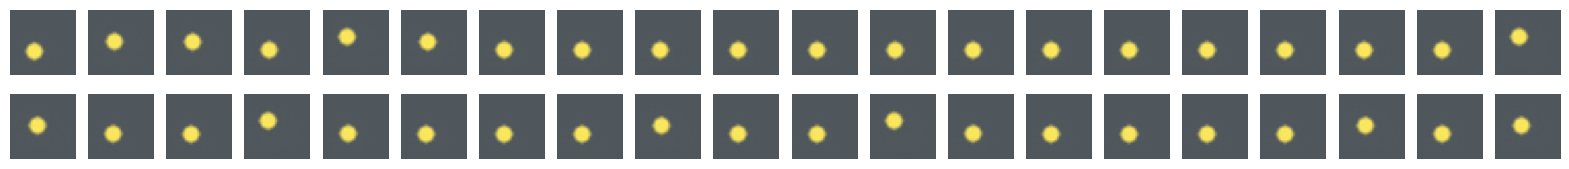

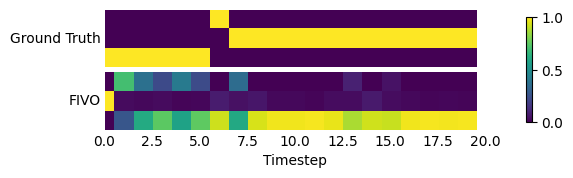

MSE: 0.00004
Pred MSE: 0.01378
Epoch: [19][50/313]	Time 0.773	Loss -174982.5938	 
Epoch: [19][100/313]	Time 0.779	Loss -175922.6562	 
Epoch: [19][150/313]	Time 0.803	Loss -174892.4531	 
Epoch: [19][200/313]	Time 0.773	Loss -175365.9219	 
Epoch: [19][250/313]	Time 0.786	Loss -175620.3281	 
Epoch: [19][300/313]	Time 0.792	Loss -176275.5312	 
MSE: 0.00009
Pred MSE: 0.01409
Epoch: [20][50/313]	Time 0.772	Loss -176108.3281	 
Epoch: [20][100/313]	Time 0.863	Loss -175903.6094	 
Epoch: [20][150/313]	Time 0.784	Loss -174641.9531	 
Epoch: [20][200/313]	Time 0.797	Loss -175882.8438	 
Epoch: [20][250/313]	Time 0.786	Loss -176180.3750	 
Epoch: [20][300/313]	Time 0.913	Loss -176496.4219	 
tensor([[0.1443, 0.0778, 0.7779],
        [0.1671, 0.1511, 0.6819],
        [0.0630, 0.0389, 0.8980]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2169, 0.5510, 0.2321], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


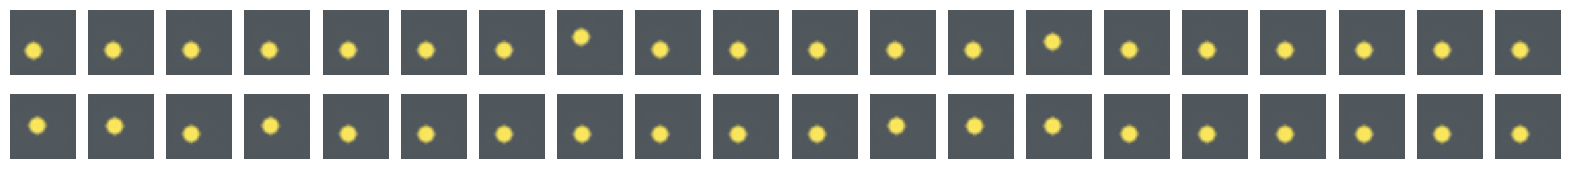

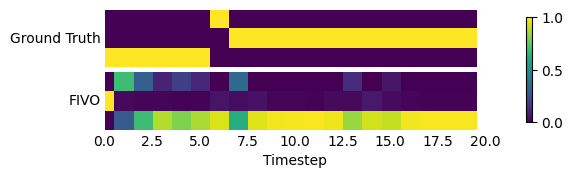

MSE: 0.00004
Pred MSE: 0.01345
Epoch: [21][50/313]	Time 0.792	Loss -176377.2031	 
Epoch: [21][100/313]	Time 0.861	Loss -176450.8281	 
Epoch: [21][150/313]	Time 0.797	Loss -173265.6875	 
Epoch: [21][200/313]	Time 0.808	Loss -175859.3750	 
Epoch: [21][250/313]	Time 0.784	Loss -176277.3750	 
Epoch: [21][300/313]	Time 0.790	Loss -176290.1250	 
MSE: 0.00004
Pred MSE: 0.01354
Epoch: [22][50/313]	Time 0.802	Loss -176376.9219	 
Epoch: [22][100/313]	Time 0.837	Loss -176445.6250	 
Epoch: [22][150/313]	Time 0.793	Loss -174158.7656	 
Epoch: [22][200/313]	Time 0.784	Loss -176131.9375	 
Epoch: [22][250/313]	Time 0.797	Loss -175699.0938	 
Epoch: [22][300/313]	Time 0.866	Loss -176252.8125	 
tensor([[0.1276, 0.0680, 0.8044],
        [0.1595, 0.1636, 0.6769],
        [0.0490, 0.0281, 0.9228]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2250, 0.5522, 0.2228], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


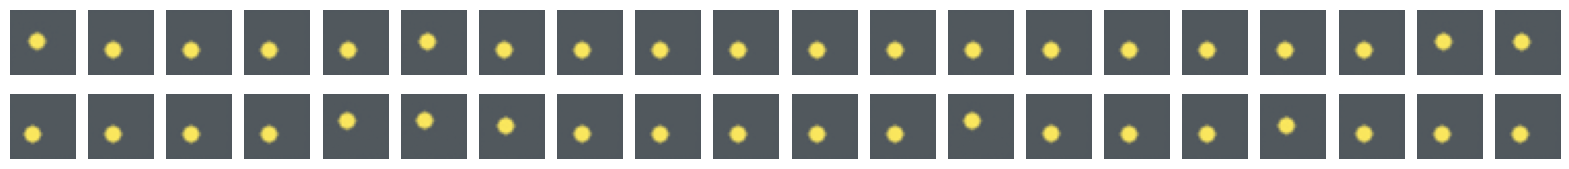

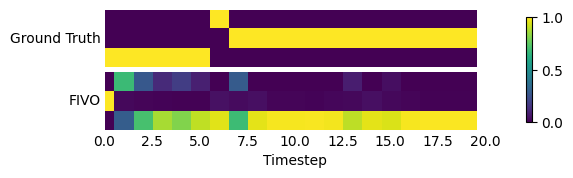

MSE: 0.00003
Pred MSE: 0.01328
Epoch: [23][50/313]	Time 0.798	Loss -176172.5938	 
Epoch: [23][100/313]	Time 0.791	Loss -175787.7031	 
Epoch: [23][150/313]	Time 0.796	Loss -176380.8438	 
Epoch: [23][200/313]	Time 0.837	Loss -174901.8281	 
Epoch: [23][250/313]	Time 0.763	Loss -175323.8281	 
Epoch: [23][300/313]	Time 0.774	Loss -175794.1875	 
MSE: 0.00025
Pred MSE: 0.01372
Epoch: [24][50/313]	Time 0.849	Loss -174525.0938	 
Epoch: [24][100/313]	Time 0.784	Loss -176211.5781	 
Epoch: [24][150/313]	Time 0.786	Loss -176101.5156	 
Epoch: [24][200/313]	Time 0.891	Loss -176239.2969	 
Epoch: [24][250/313]	Time 0.772	Loss -176331.5000	 
Epoch: [24][300/313]	Time 0.792	Loss -176273.6406	 
tensor([[0.1166, 0.0619, 0.8215],
        [0.1549, 0.1779, 0.6673],
        [0.0393, 0.0208, 0.9399]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2483, 0.5540, 0.1977], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


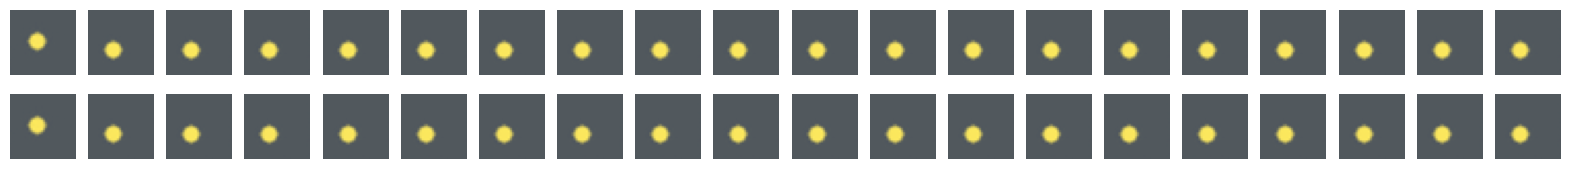

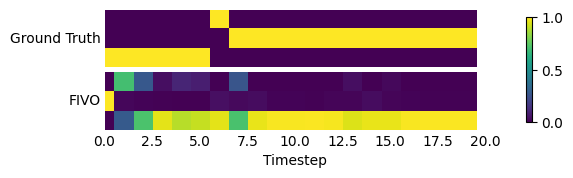

MSE: 0.00003
Pred MSE: 0.01326
Epoch: [25][50/313]	Time 0.789	Loss -176349.0938	 
Epoch: [25][100/313]	Time 0.788	Loss -174671.2344	 
Epoch: [25][150/313]	Time 0.759	Loss -176119.7500	 
Epoch: [25][200/313]	Time 0.855	Loss -176034.5625	 
Epoch: [25][250/313]	Time 0.862	Loss -176024.0312	 
Epoch: [25][300/313]	Time 0.799	Loss -176014.9688	 
MSE: 0.00007
Pred MSE: 0.01347
Epoch: [26][50/313]	Time 0.796	Loss -176409.6875	 
Epoch: [26][100/313]	Time 0.789	Loss -176520.5000	 
Epoch: [26][150/313]	Time 0.799	Loss -176238.1719	 
Epoch: [26][200/313]	Time 0.800	Loss -174374.1250	 
Epoch: [26][250/313]	Time 0.780	Loss -176288.1094	 
Epoch: [26][300/313]	Time 0.792	Loss -176311.5156	 
tensor([[0.1066, 0.0570, 0.8364],
        [0.1548, 0.1955, 0.6497],
        [0.0310, 0.0148, 0.9542]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2678, 0.5596, 0.1726], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


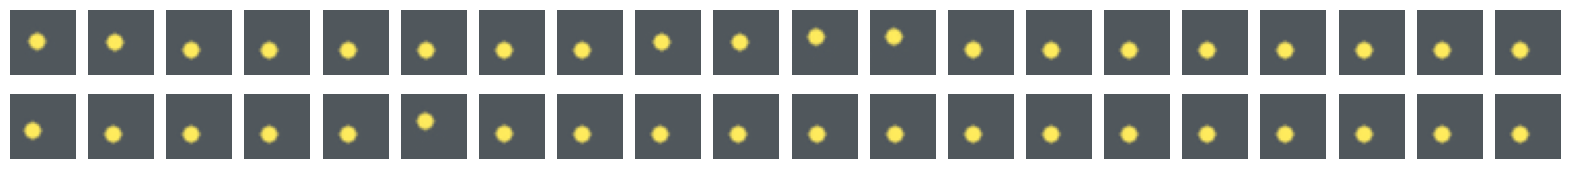

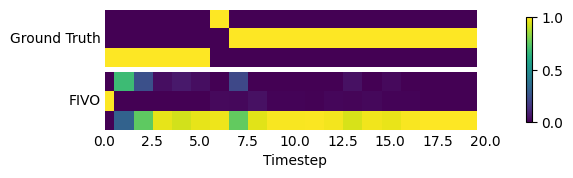

MSE: 0.00005
Pred MSE: 0.01341
Epoch: [27][50/313]	Time 0.769	Loss -174802.3906	 
Epoch: [27][100/313]	Time 0.802	Loss -175911.5156	 
Epoch: [27][150/313]	Time 0.815	Loss -175560.4531	 
Epoch: [27][200/313]	Time 0.793	Loss -176184.6875	 
Epoch: [27][250/313]	Time 0.801	Loss -175795.4375	 
Epoch: [27][300/313]	Time 0.788	Loss -176414.2500	 
MSE: 0.00002
Pred MSE: 0.01350
Epoch: [28][50/313]	Time 0.784	Loss -174710.3125	 
Epoch: [28][100/313]	Time 0.787	Loss -175564.3438	 
Epoch: [28][150/313]	Time 0.844	Loss -174795.7969	 
Epoch: [28][200/313]	Time 0.780	Loss -176068.5000	 
Epoch: [28][250/313]	Time 0.822	Loss -176550.8438	 
Epoch: [28][300/313]	Time 0.790	Loss -175588.0000	 
tensor([[0.1020, 0.0586, 0.8394],
        [0.1533, 0.1942, 0.6524],
        [0.0253, 0.0110, 0.9637]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2813, 0.5681, 0.1506], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


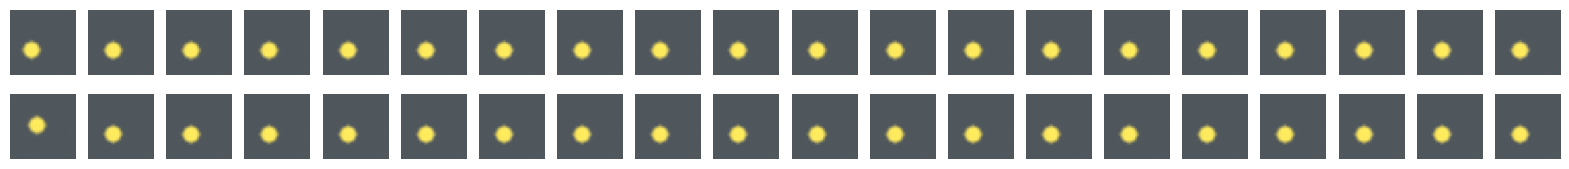

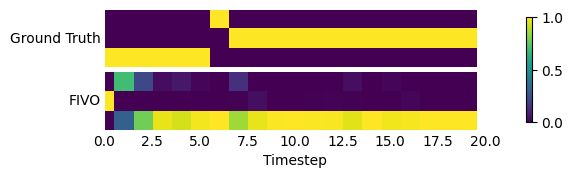

MSE: 0.00009
Pred MSE: 0.01329
Epoch: [29][50/313]	Time 0.806	Loss -176509.5781	 
Epoch: [29][100/313]	Time 0.783	Loss -176304.2500	 
Epoch: [29][150/313]	Time 0.865	Loss -176352.6719	 
Epoch: [29][200/313]	Time 0.827	Loss -176252.2344	 
Epoch: [29][250/313]	Time 0.799	Loss -176528.5781	 
Epoch: [29][300/313]	Time 0.773	Loss -176371.4688	 
MSE: 0.00003
Pred MSE: 0.01338
Epoch: [30][50/313]	Time 0.791	Loss -176610.4688	 
Epoch: [30][100/313]	Time 0.790	Loss -176245.0625	 
Epoch: [30][150/313]	Time 0.789	Loss -176630.2812	 
Epoch: [30][200/313]	Time 0.810	Loss -176524.6250	 
Epoch: [30][250/313]	Time 0.806	Loss -176605.6562	 
Epoch: [30][300/313]	Time 0.789	Loss -176341.0156	 
tensor([[0.1008, 0.0614, 0.8378],
        [0.1588, 0.2031, 0.6381],
        [0.0200, 0.0079, 0.9721]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2881, 0.5733, 0.1386], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


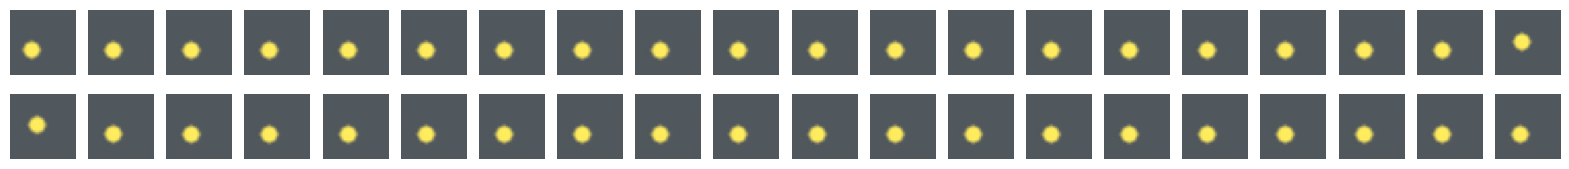

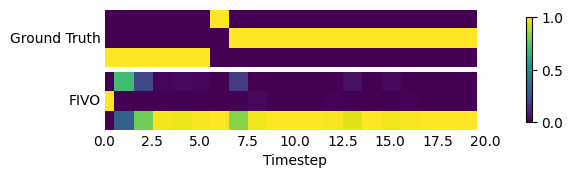

MSE: 0.00002
Pred MSE: 0.01343
Epoch: [31][50/313]	Time 0.789	Loss -176520.4375	 
Epoch: [31][100/313]	Time 0.794	Loss -176379.5625	 
Epoch: [31][150/313]	Time 0.779	Loss -174799.1250	 
Epoch: [31][200/313]	Time 0.779	Loss -175375.8750	 
Epoch: [31][250/313]	Time 0.765	Loss -175855.6250	 
Epoch: [31][300/313]	Time 0.791	Loss -176243.6719	 
MSE: 0.00006
Pred MSE: 0.01315
Epoch: [32][50/313]	Time 0.770	Loss -176405.0781	 
Epoch: [32][100/313]	Time 0.787	Loss -176101.1562	 
Epoch: [32][150/313]	Time 0.779	Loss -176509.2500	 
Epoch: [32][200/313]	Time 0.807	Loss -176572.5469	 
Epoch: [32][250/313]	Time 0.792	Loss -176544.3438	 
Epoch: [32][300/313]	Time 0.769	Loss -176538.5469	 
tensor([[0.0992, 0.0671, 0.8336],
        [0.1611, 0.2047, 0.6341],
        [0.0161, 0.0058, 0.9781]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2957, 0.5769, 0.1274], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


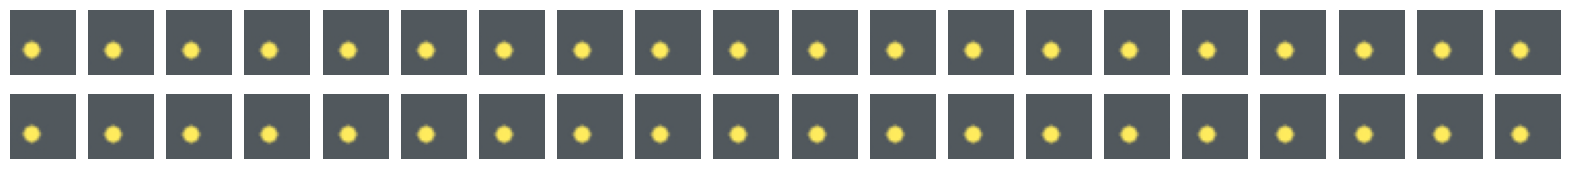

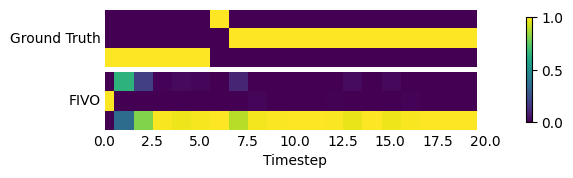

MSE: 0.00002
Pred MSE: 0.01329
Epoch: [33][50/313]	Time 0.812	Loss -176403.0312	 
Epoch: [33][100/313]	Time 0.826	Loss -176298.8906	 
Epoch: [33][150/313]	Time 1.052	Loss -176459.6875	 
Epoch: [33][200/313]	Time 0.799	Loss -176612.5938	 
Epoch: [33][250/313]	Time 0.782	Loss -176400.1875	 
Epoch: [33][300/313]	Time 0.799	Loss -175728.2500	 
MSE: 0.00004
Pred MSE: 0.01323
Epoch: [34][50/313]	Time 0.775	Loss -174900.4375	 
Epoch: [34][100/313]	Time 0.792	Loss -176252.0938	 
Epoch: [34][150/313]	Time 0.772	Loss -176492.2031	 
Epoch: [34][200/313]	Time 0.782	Loss -176673.2656	 
Epoch: [34][250/313]	Time 0.771	Loss -176488.6562	 
Epoch: [34][300/313]	Time 0.790	Loss -176657.0938	 
tensor([[0.1000, 0.0770, 0.8230],
        [0.1704, 0.2060, 0.6236],
        [0.0127, 0.0043, 0.9830]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2990, 0.5826, 0.1184], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


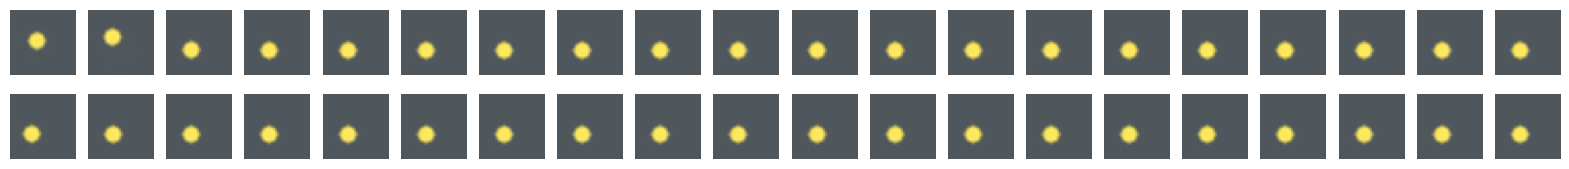

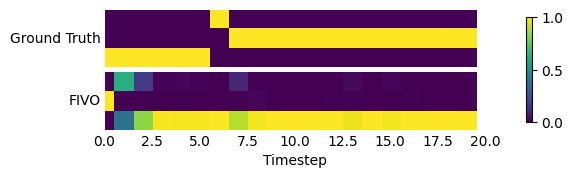

MSE: 0.00002
Pred MSE: 0.01296
Epoch: [35][50/313]	Time 0.830	Loss -176614.5000	 
Epoch: [35][100/313]	Time 0.789	Loss -176548.5312	 
Epoch: [35][150/313]	Time 0.791	Loss -176631.7656	 
Epoch: [35][200/313]	Time 0.801	Loss -176583.6250	 
Epoch: [35][250/313]	Time 0.822	Loss -176140.3750	 
Epoch: [35][300/313]	Time 0.777	Loss -175425.6562	 
MSE: 0.00010
Pred MSE: 0.01316
Epoch: [36][50/313]	Time 0.782	Loss -176161.8125	 
Epoch: [36][100/313]	Time 0.793	Loss -176262.5000	 
Epoch: [36][150/313]	Time 0.801	Loss -176601.7812	 
Epoch: [36][200/313]	Time 0.795	Loss -176647.1250	 
Epoch: [36][250/313]	Time 0.817	Loss -176652.4688	 
Epoch: [36][300/313]	Time 0.800	Loss -176590.2969	 
tensor([[0.1004, 0.0842, 0.8154],
        [0.1748, 0.2062, 0.6190],
        [0.0100, 0.0032, 0.9868]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3055, 0.5847, 0.1099], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


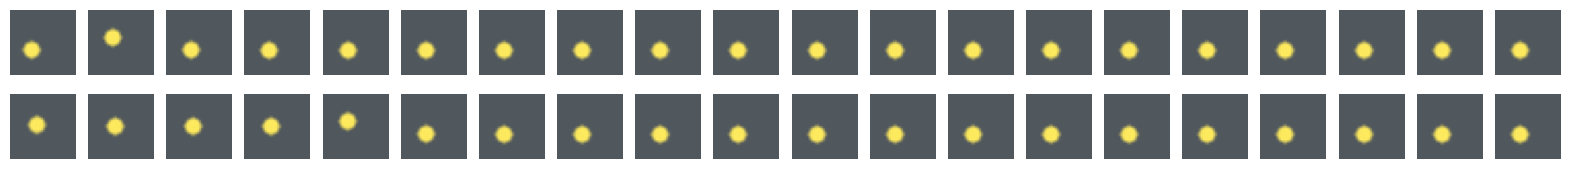

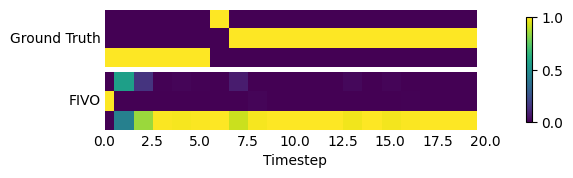

MSE: 0.00002
Pred MSE: 0.01300
Epoch: [37][50/313]	Time 0.790	Loss -174278.5781	 
Epoch: [37][100/313]	Time 0.825	Loss -175433.1250	 
Epoch: [37][150/313]	Time 0.763	Loss -174973.4688	 
Epoch: [37][200/313]	Time 0.811	Loss -175886.9375	 
Epoch: [37][250/313]	Time 0.774	Loss -176464.1250	 
Epoch: [37][300/313]	Time 0.805	Loss -176582.0781	 
MSE: 0.00008
Pred MSE: 0.01304
Epoch: [38][50/313]	Time 0.778	Loss -175977.7656	 
Epoch: [38][100/313]	Time 0.762	Loss -175180.9062	 
Epoch: [38][150/313]	Time 0.821	Loss -175487.9062	 
Epoch: [38][200/313]	Time 0.788	Loss -176377.4062	 
Epoch: [38][250/313]	Time 0.787	Loss -176590.2812	 
Epoch: [38][300/313]	Time 0.803	Loss -176540.4219	 
tensor([[0.1043, 0.0922, 0.8035],
        [0.1786, 0.2072, 0.6142],
        [0.0083, 0.0025, 0.9892]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3065, 0.5888, 0.1047], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


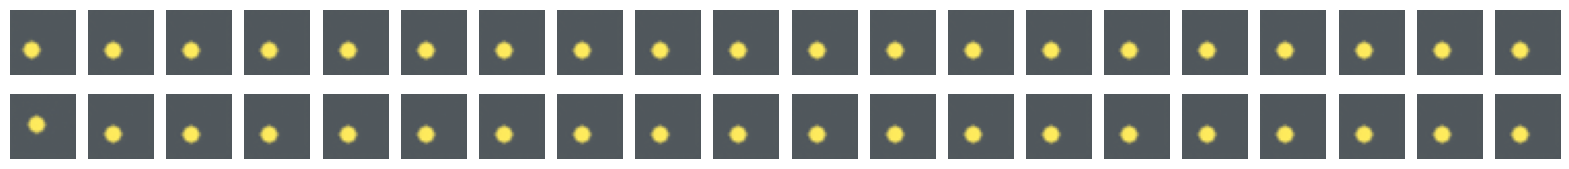

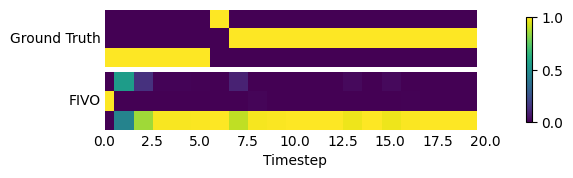

MSE: 0.00005
Pred MSE: 0.01313
Epoch: [39][50/313]	Time 1.094	Loss -176306.1562	 
Epoch: [39][100/313]	Time 0.785	Loss -176268.4062	 
Epoch: [39][150/313]	Time 0.853	Loss -176635.1094	 
Epoch: [39][200/313]	Time 0.797	Loss -176552.5469	 
Epoch: [39][250/313]	Time 0.791	Loss -176671.8750	 
Epoch: [39][300/313]	Time 0.857	Loss -176655.2188	 
MSE: 0.00001
Pred MSE: 0.01313
Epoch: [40][50/313]	Time 0.771	Loss -176617.6719	 
Epoch: [40][100/313]	Time 0.829	Loss -176653.9531	 
Epoch: [40][150/313]	Time 0.788	Loss -176657.4844	 
Epoch: [40][200/313]	Time 0.810	Loss -176666.5312	 
Epoch: [40][250/313]	Time 0.780	Loss -176644.0000	 
Epoch: [40][300/313]	Time 0.789	Loss -176639.6250	 
tensor([[0.1089, 0.1018, 0.7892],
        [0.1844, 0.2126, 0.6030],
        [0.0063, 0.0019, 0.9918]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3079, 0.5867, 0.1054], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


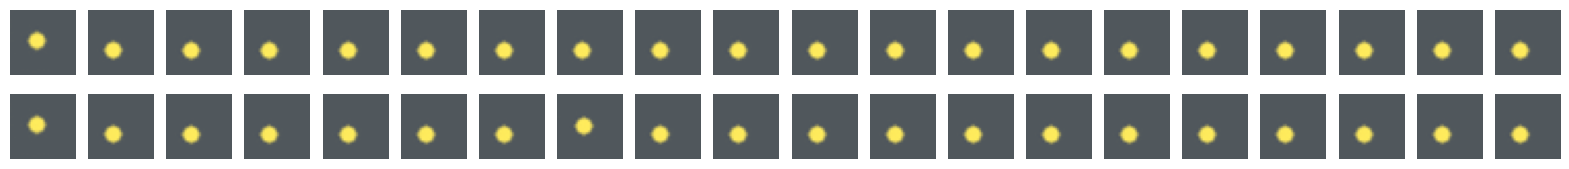

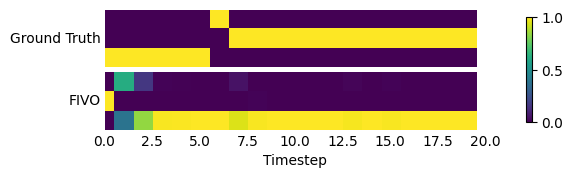

MSE: 0.00001
Pred MSE: 0.01313
Epoch: [41][50/313]	Time 0.811	Loss -176119.4062	 
Epoch: [41][100/313]	Time 0.779	Loss -176533.4062	 
Epoch: [41][150/313]	Time 0.996	Loss -176552.2656	 
Epoch: [41][200/313]	Time 0.789	Loss -176329.3438	 
Epoch: [41][250/313]	Time 0.786	Loss -175479.8750	 
Epoch: [41][300/313]	Time 0.788	Loss -176445.4375	 
MSE: 0.00005
Pred MSE: 0.01312
Epoch: [42][50/313]	Time 0.790	Loss -176553.9219	 
Epoch: [42][100/313]	Time 0.796	Loss -176632.9375	 
Epoch: [42][150/313]	Time 0.803	Loss -176568.8125	 
Epoch: [42][200/313]	Time 0.834	Loss -176637.7812	 
Epoch: [42][250/313]	Time 0.790	Loss -176682.9688	 
Epoch: [42][300/313]	Time 0.789	Loss -176650.6250	 
tensor([[0.1111, 0.1091, 0.7798],
        [0.1896, 0.2127, 0.5977],
        [0.0050, 0.0014, 0.9936]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3087, 0.5891, 0.1022], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1


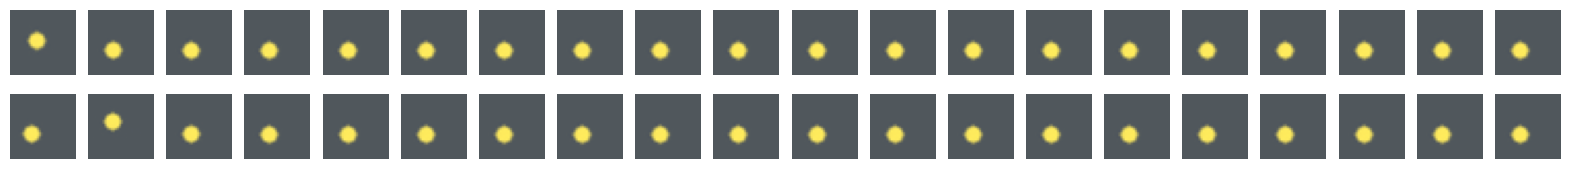

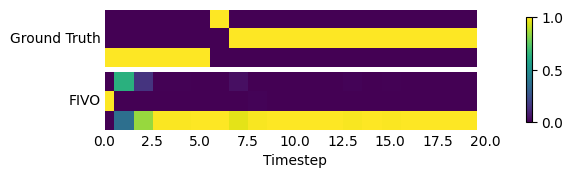

MSE: 0.00001
Pred MSE: 0.01306
Epoch: [43][50/313]	Time 0.867	Loss -176700.0938	 
Epoch: [43][100/313]	Time 0.790	Loss -176713.1250	 
Epoch: [43][150/313]	Time 0.765	Loss -174797.3438	 
Epoch: [43][200/313]	Time 0.821	Loss -175865.1719	 
Epoch: [43][250/313]	Time 0.953	Loss -176147.7031	 
Epoch: [43][300/313]	Time 0.785	Loss -176403.1719	 
MSE: 0.00004
Pred MSE: 0.01310
Epoch: [44][50/313]	Time 0.802	Loss -176582.3906	 


KeyboardInterrupt: 

In [15]:
fivo_losses, test_mse_fivo, pred_mse_fivo = train_fivo(N, model, optimizer,num_states, dim_latent, T)

In [16]:
# Save/Load model

PATH = 'snlds_video_20_fivo_2.pth'
torch.save(model.state_dict(), PATH)
# model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
# model.load_state_dict(torch.load(PATH))

Text(0, 0.5, 'Training Loss')

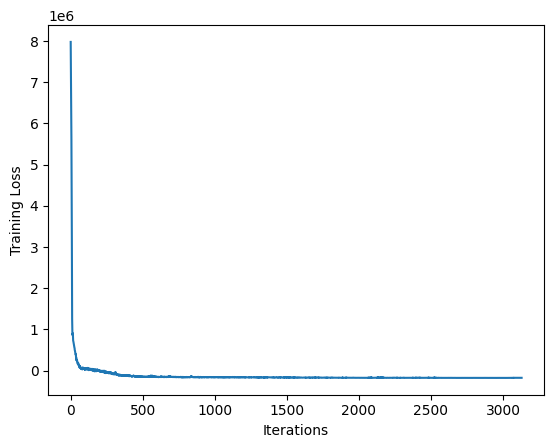

In [18]:
plt.plot(fivo_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

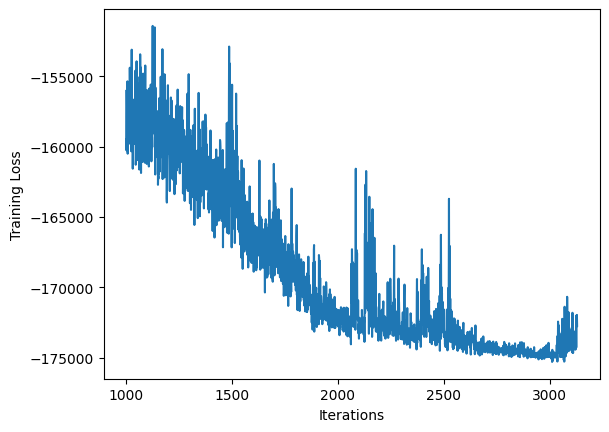

In [19]:
plt.plot(np.arange(1000,len(fivo_losses)),fivo_losses[1000:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

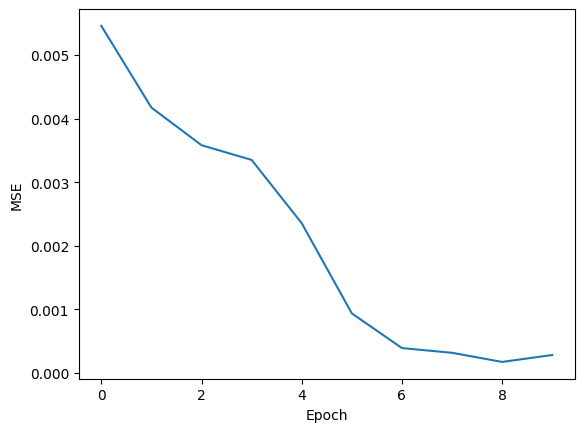

In [20]:
plt.plot(test_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'Pred MSE')

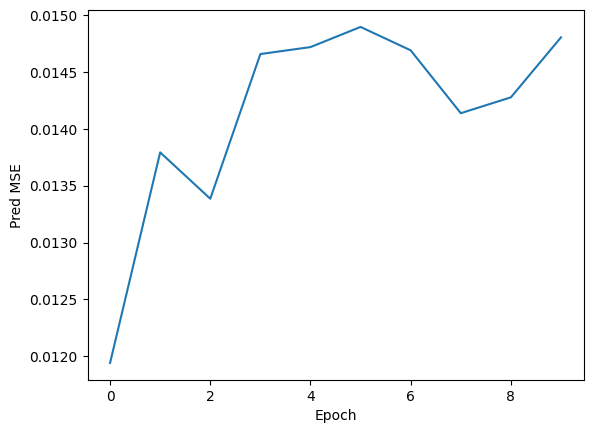

In [21]:
plt.plot(pred_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('Pred MSE')

In [22]:
# Training time: 41min
print(f"Last FIVO Loss: {fivo_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_fivo[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_fivo[-1]:.6f}")

Last FIVO Loss: -172739.9
Last Test MSE: 0.000283
Last Pred MSE: 0.014805


In [23]:
print(f"Best FIVO Loss: {min(fivo_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_fivo):.6f}")
print(f"Best Pred MSE: {min(pred_mse_fivo):.6f}")

Best FIVO Loss: -175307.3
Best Test MSE: 0.000174
Best Pred MSE: 0.011941


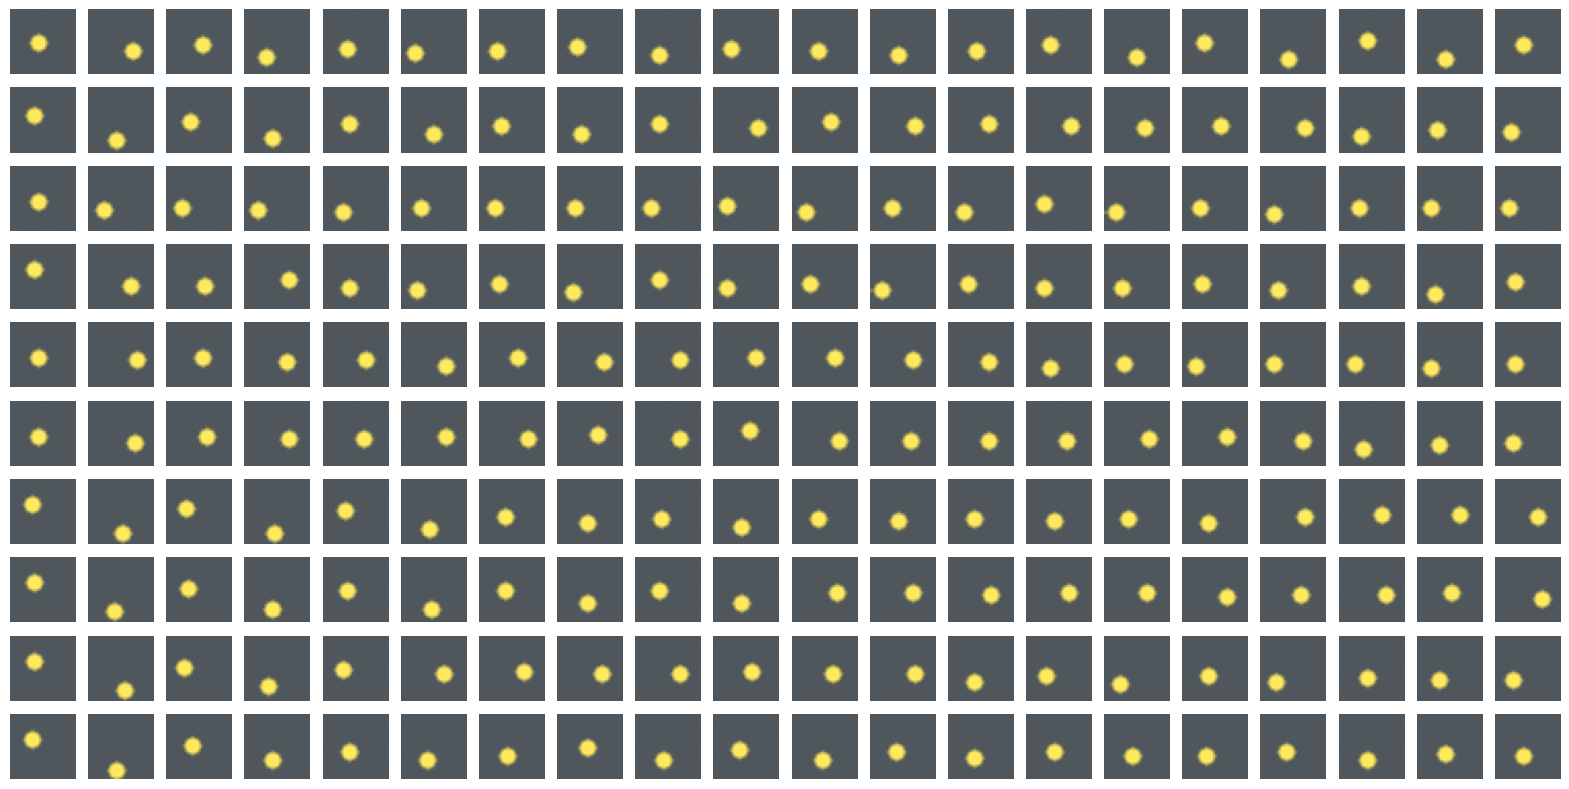

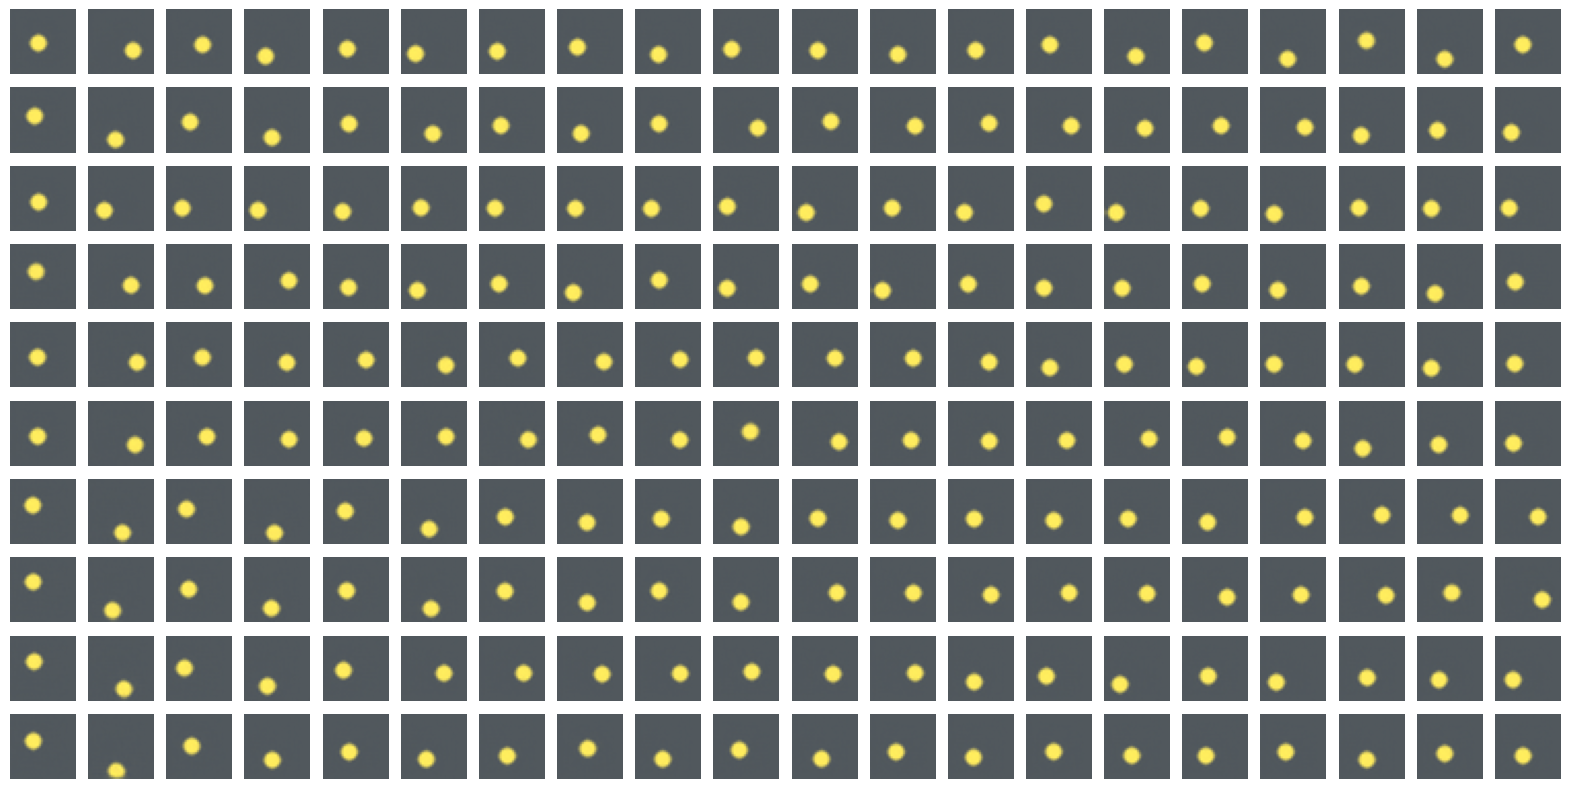

In [24]:
# Reconstructions

n_samples = 10
t = 20
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    x = x + 0.5
    (B,T,C,H,W) = x.shape
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = torch.clamp(recon_x,max=1.0)
    recon_x = recon_x.cpu().reshape(B,T,C,H,W).numpy()

imshow_grid((x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)
imshow_grid((recon_x-0.5)[0:n_samples], n_row=n_samples, n_col=t, fig_size_a=t)

In [25]:
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.5f}")

t=0 MSE per pixel:0.00043
t=1 MSE per pixel:0.00046
t=2 MSE per pixel:0.00023
t=3 MSE per pixel:0.00038
t=4 MSE per pixel:0.00025
t=5 MSE per pixel:0.00031
t=6 MSE per pixel:0.00020
t=7 MSE per pixel:0.00033
t=8 MSE per pixel:0.00031
t=9 MSE per pixel:0.00027
t=10 MSE per pixel:0.00031
t=11 MSE per pixel:0.00031
t=12 MSE per pixel:0.00031
t=13 MSE per pixel:0.00027
t=14 MSE per pixel:0.00024
t=15 MSE per pixel:0.00026
t=16 MSE per pixel:0.00029
t=17 MSE per pixel:0.00026
t=18 MSE per pixel:0.00028
t=19 MSE per pixel:0.00023


Text(0, 0.5, 'MSE per Pixel')

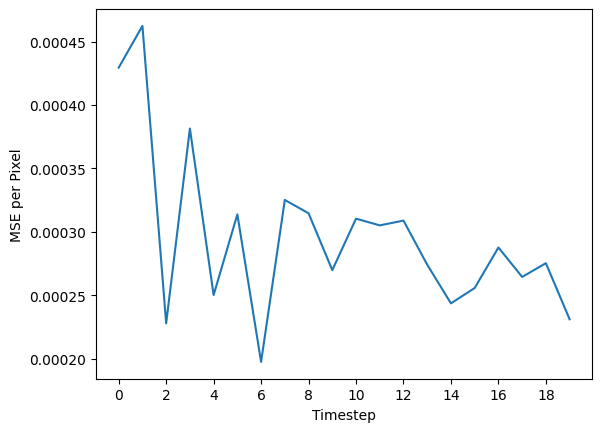

In [26]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,20,2))
plt.ylabel('MSE per Pixel')

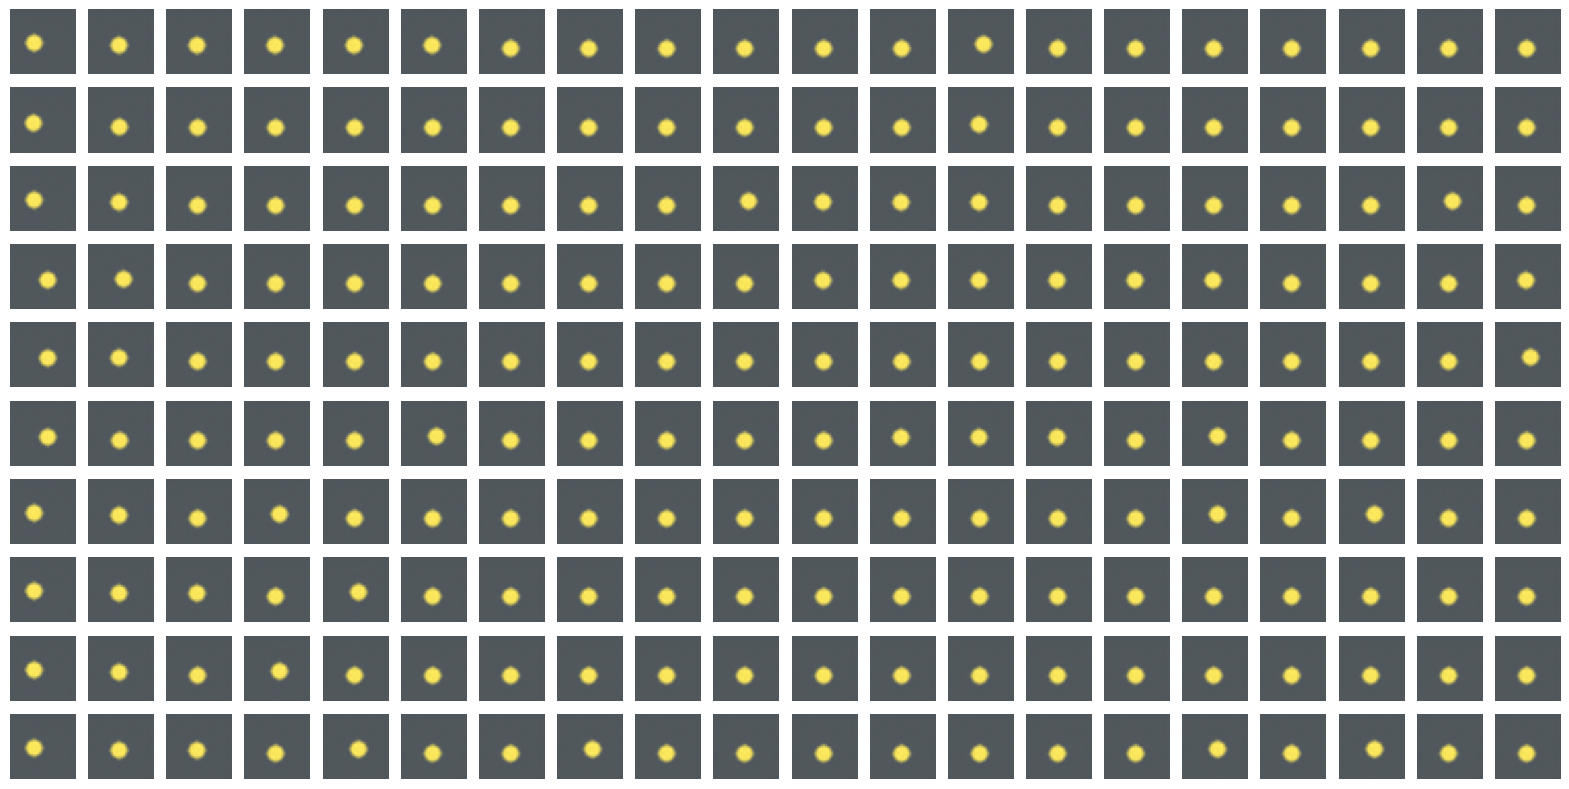

In [21]:
# Create samples

n_samples = 10
seq_len = 20
model.eval()
with torch.inference_mode():
    s = model.sample(n_samples,seq_len)
    s = s.cpu().reshape(n_samples,seq_len,3,32,32)
    s = torch.clamp(s - 0.5,max=0.5).numpy()

imshow_grid(s, n_row=n_samples, n_col=seq_len, fig_size_a=seq_len)      

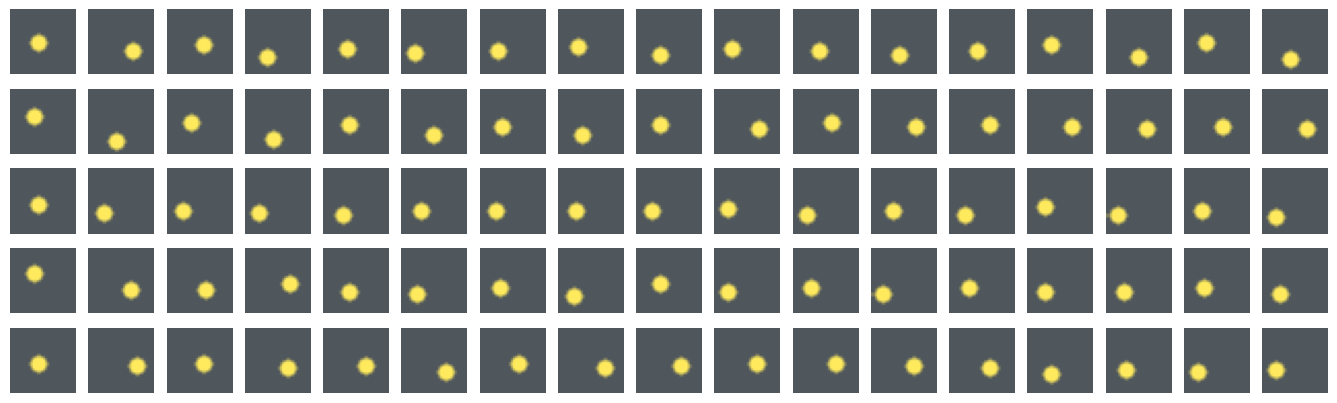

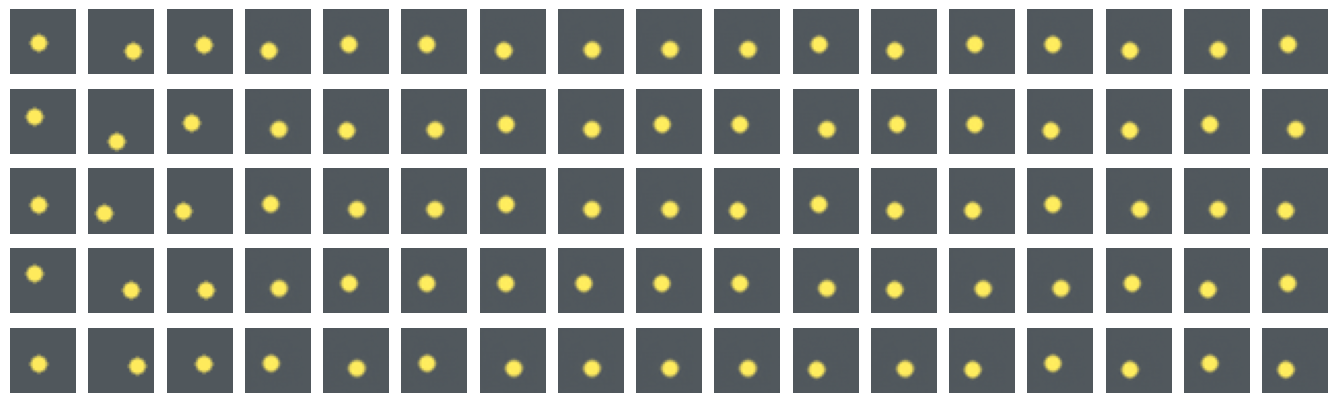

In [28]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE
with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device)) + 0.5
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=17)
    preds = preds.reshape(B,17,3,32,32)
    preds = torch.clamp(preds,max=1.0)
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.cpu().numpy()

imshow_grid((x[:5]-0.5), n_row=5, n_col=17, fig_size_a=17, fig_size_b=5)
imshow_grid((preds[:5]-0.5), n_row=5, n_col=17, fig_size_a=17, fig_size_b=5)

In [29]:
with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        preds = model.predict_sequence(obs_var[:,:3], seq_len=17)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 17, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

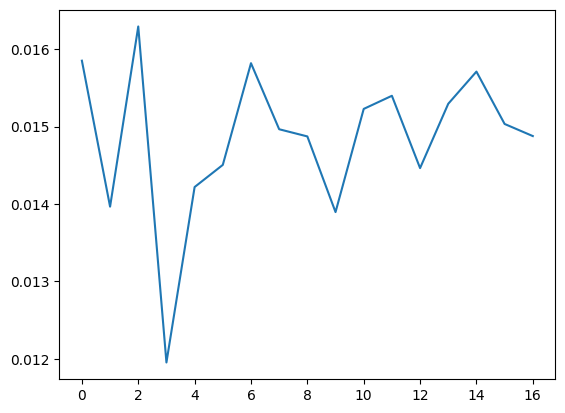

In [31]:
plt.plot(predict_mse[0])

# Final Tests

In [11]:
PATH = 'snlds_video_20_elbo.pth'
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [91]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO>IWAE>ELBO
model.beta = 1
with torch.inference_mode():
    elbo_list = []
    iwae_list = []
    iwae_2_list = []
    fivo_list = []
    for (sample,) in tqdm.tqdm(test_dataloader):
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        _, _, _, losses = model(obs_var)
        iwae, _ = model.iwae_efficient(obs_var, 10)
        iwae_2, _ = model.iwae(obs_var, 10)
        fivo, _ = model.fivo_efficient(obs_var, 10)
        elbo = losses['loss']
        elbo_list.append(-elbo)
        iwae_list.append(-iwae)
        iwae_2_list.append(-iwae_2)
        fivo_list.append(-fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.2f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.2f}")
    print(f"IWAE: {sum(iwae_2_list)/len(iwae_2_list):.2f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

100%|██████████| 8/8 [00:24<00:00,  3.05s/it]

ELBO: 176479.78
IWAE: 176675.53
IWAE: 176554.41
FIVO: 176579.70


In [18]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO>IWAE>ELBO
model.beta = 1
with torch.inference_mode():
    elbo_list = []
    iwae_list = []
    iwae_2_list = []
    fivo_list = []
    for (sample,) in tqdm.tqdm(test_dataloader):
        obs_var = sample.float().to(device)
        obs_var = obs_var + 0.5
        _, _, _, losses = model(obs_var)
        iwae, _ = model.iwae_efficient(obs_var, 10)
        iwae_2, _ = model.iwae(obs_var, 10)
        fivo, _ = model.fivo_efficient(obs_var, 10)
        elbo = losses['loss']
        elbo_list.append(-elbo)
        iwae_list.append(-iwae)
        iwae_2_list.append(-iwae_2)
        fivo_list.append(-fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.2f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.2f}")
    print(f"IWAE: {sum(iwae_2_list)/len(iwae_2_list):.2f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

  0%|          | 0/8 [00:00<?, ?it/s]/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 13.30 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv_transpose2d(
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 20.68 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv_transpose2d(
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 14.06 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/t

ELBO: 176489.41
IWAE: 176674.95
IWAE: 176550.78
FIVO: 176578.45


In [12]:
# First 20 timesteps. Probability of discrete states

latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables_im/states_test_N_500_T_20_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
latents_states = next(iter(latent_loader))[0]
obs = next(iter(test_dataloader))[0]
obs = obs + 0.5

# ELBO
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_video_20_elbo.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_elbo = model.gamma(obs[:,:].float().to(device))
# IWAE
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_video_20_iwae_2.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_iwae = model.gamma(obs[:,:].float().to(device))
# FIVO
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='video', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_video_20_fivo_2.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_fivo = model.gamma(obs[:,:].float().to(device))


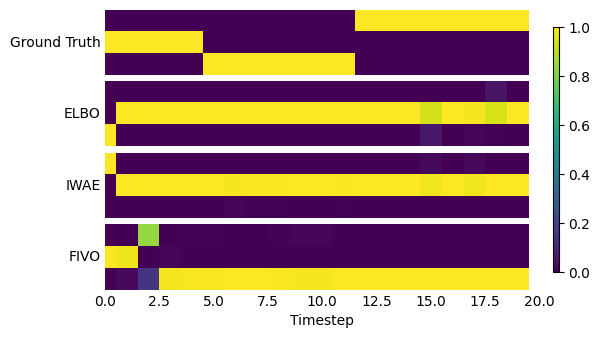

In [13]:
plot_models(gamma_elbo, gamma_iwae, gamma_fivo, latents_states,N=8)

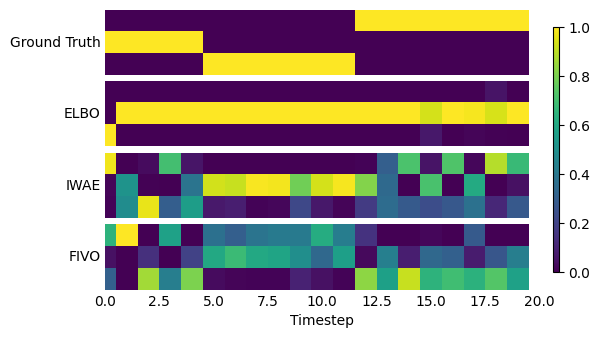

In [11]:
plot_models(gamma_elbo, gamma_iwae, gamma_fivo, latents_states,N=8)

In [15]:
latents_states = latents_states.cpu().numpy()
gamma_elbo = gamma_elbo.cpu().numpy()
gamma_iwae = gamma_iwae.cpu().numpy()
gamma_fivo = gamma_fivo.cpu().numpy()

In [18]:
print(f"ELBO:{best_f1_score(latents_states, gamma_elbo[:50]):.2f}")
print(f"IWAE:{best_f1_score(latents_states, gamma_iwae[:50]):.2f}")
print(f"FIVO:{best_f1_score(latents_states, gamma_fivo[:50]):.2f}")

ELBO:0.23
IWAE:0.20
FIVO:0.28


In [19]:
print(f"ELBO:{best_cross_entropy_loss(latents_states, gamma_elbo[:50]):.2f}")
print(f"IWAE:{best_cross_entropy_loss(latents_states, gamma_iwae[:50]):.2f}")
print(f"FIVO:{best_cross_entropy_loss(latents_states, gamma_fivo[:50]):.2f}")

ELBO:11.55
IWAE:7.99
FIVO:4.45
